## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 614)
Hypercube shape: (512, 614, 176)


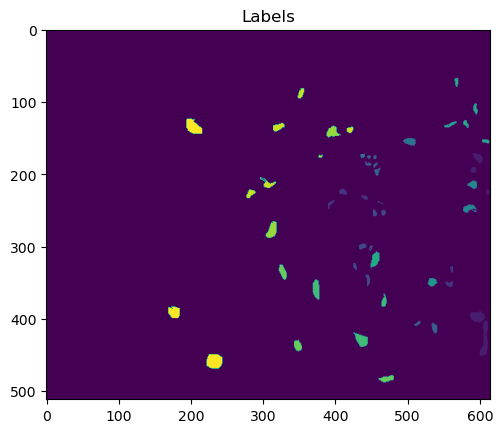

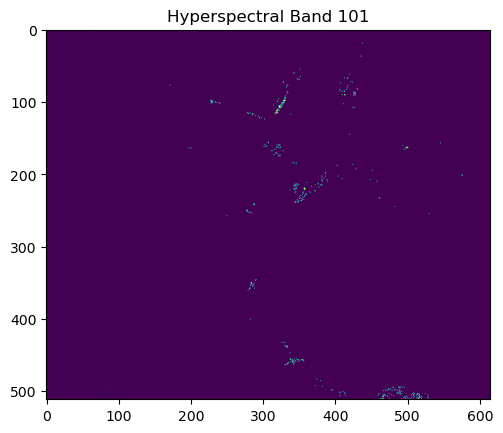

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'KSC_gt.mat'
data_files = 'KSC.mat'
label_files = 'KSC_gt'
hypercube_files = 'KSC'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 5211
Extracted windows shape: (5211, 5, 5, 176)
Corresponding labels shape: (5211,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 761 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 243 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 256 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 252 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 161 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 229 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 105 samples
Shuffled class indices for class '7'
Sele


All datasets saved to the 'indices' folder.
(520, 5, 5, 176)
(65, 5, 5, 176)
(4626, 5, 5, 176)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 260
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (4168, 5, 5, 176)
Validation data shape: (1043, 5, 5, 176)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

176


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/66], Loss: 0.2516, PSNR: 5.9933


Epoch [1/50] Training Loss: 0.2403, PSNR: 6.1951
	[Val]   Batch [1/17] Loss: 0.2261, PSNR: 6.4570
	[Val]   Batch [10/17] Loss: 0.2264, PSNR: 6.4504
Epoch [1/50] Validation Loss: 0.2263, PSNR: 6.4525

LOG: Epoch [2/50]
	 Training Batch [1/66], Loss: 0.2201, PSNR: 6.5743


Epoch [2/50] Training Loss: 0.2041, PSNR: 6.9074
	[Val]   Batch [1/17] Loss: 0.1808, PSNR: 7.4276
	[Val]   Batch [10/17] Loss: 0.1828, PSNR: 7.3814
Epoch [2/50] Validation Loss: 0.1821, PSNR: 7.3961

LOG: Epoch [3/50]
	 Training Batch [1/66], Loss: 0.1811, PSNR: 7.4198


Epoch [3/50] Training Loss: 0.1671, PSNR: 7.7767
	[Val]   Batch [1/17] Loss: 0.1464, PSNR: 8.3433
	[Val]   Batch [10/17] Loss: 0.1497, PSNR: 8.2471
Epoch [3/50] Validation Loss: 0.1487, PSNR: 8.2768

LOG: Epoch [4/50]
	 Training Batch [1/66], Loss: 0.1472, PSNR: 8.3203


Epoch [4/50] Training Loss: 0.1344, PSNR: 8.7229
	[Val]   Batch [1/17] Loss: 0.1169, PSNR: 9.3229
	[Val]   Batch [10/17] Loss: 0.1185, PSNR: 9.2642
Epoch [4/50] Validation Loss: 0.1180, PSNR: 9.2795

LOG: Epoch [5/50]
	 Training Batch [1/66], Loss: 0.1180, PSNR: 9.2800


Epoch [5/50] Training Loss: 0.1069, PSNR: 9.7176
	[Val]   Batch [1/17] Loss: 0.0938, PSNR: 10.2794
	[Val]   Batch [10/17] Loss: 0.0958, PSNR: 10.1858
Epoch [5/50] Validation Loss: 0.0954, PSNR: 10.2053

LOG: Epoch [6/50]
	 Training Batch [1/66], Loss: 0.0922, PSNR: 10.3540


Epoch [6/50] Training Loss: 0.0853, PSNR: 10.0126
	[Val]   Batch [1/17] Loss: 0.0761, PSNR: 11.1850
	[Val]   Batch [10/17] Loss: 0.0770, PSNR: 11.1347
Epoch [6/50] Validation Loss: 0.0769, PSNR: 11.1404

LOG: Epoch [7/50]
	 Training Batch [1/66], Loss: 0.0746, PSNR: 11.2725


Epoch [7/50] Training Loss: 0.0686, PSNR: 11.6417
	[Val]   Batch [1/17] Loss: 0.0615, PSNR: 12.1095
	[Val]   Batch [10/17] Loss: 0.0622, PSNR: 12.0647
Epoch [7/50] Validation Loss: 0.0621, PSNR: 12.0702

LOG: Epoch [8/50]
	 Training Batch [1/66], Loss: 0.0603, PSNR: 12.1994


Epoch [8/50] Training Loss: 0.0561, PSNR: 12.5154
	[Val]   Batch [1/17] Loss: 0.0511, PSNR: 12.9117
	[Val]   Batch [10/17] Loss: 0.0517, PSNR: 12.8651
Epoch [8/50] Validation Loss: 0.0516, PSNR: 12.8733

LOG: Epoch [9/50]
	 Training Batch [1/66], Loss: 0.0500, PSNR: 13.0102


Epoch [9/50] Training Loss: 0.0466, PSNR: 13.3223
	[Val]   Batch [1/17] Loss: 0.0428, PSNR: 13.6854
	[Val]   Batch [10/17] Loss: 0.0431, PSNR: 13.6600
Epoch [9/50] Validation Loss: 0.0431, PSNR: 13.6602

LOG: Epoch [10/50]
	 Training Batch [1/66], Loss: 0.0421, PSNR: 13.7545


Epoch [10/50] Training Loss: 0.0394, PSNR: 14.0489
	[Val]   Batch [1/17] Loss: 0.0367, PSNR: 14.3520
	[Val]   Batch [10/17] Loss: 0.0369, PSNR: 14.3314
Epoch [10/50] Validation Loss: 0.0369, PSNR: 14.3291

LOG: Epoch [11/50]
	 Training Batch [1/66], Loss: 0.0358, PSNR: 14.4567


Epoch [11/50] Training Loss: 0.0338, PSNR: 14.7142
	[Val]   Batch [1/17] Loss: 0.0319, PSNR: 14.9607
	[Val]   Batch [10/17] Loss: 0.0322, PSNR: 14.9266
Epoch [11/50] Validation Loss: 0.0321, PSNR: 14.9289

LOG: Epoch [12/50]
	 Training Batch [1/66], Loss: 0.0307, PSNR: 15.1352


Epoch [12/50] Training Loss: 0.0294, PSNR: 15.3174
	[Val]   Batch [1/17] Loss: 0.0280, PSNR: 15.5264
	[Val]   Batch [10/17] Loss: 0.0283, PSNR: 15.4804
Epoch [12/50] Validation Loss: 0.0283, PSNR: 15.4854

LOG: Epoch [13/50]
	 Training Batch [1/66], Loss: 0.0272, PSNR: 15.6487


Epoch [13/50] Training Loss: 0.0258, PSNR: 15.8844
	[Val]   Batch [1/17] Loss: 0.0251, PSNR: 16.0053
	[Val]   Batch [10/17] Loss: 0.0253, PSNR: 15.9618
Epoch [13/50] Validation Loss: 0.0253, PSNR: 15.9649

LOG: Epoch [14/50]
	 Training Batch [1/66], Loss: 0.0239, PSNR: 16.2239


Epoch [14/50] Training Loss: 0.0229, PSNR: 16.4086
	[Val]   Batch [1/17] Loss: 0.0222, PSNR: 16.5296
	[Val]   Batch [10/17] Loss: 0.0224, PSNR: 16.5043
Epoch [14/50] Validation Loss: 0.0224, PSNR: 16.5017

LOG: Epoch [15/50]
	 Training Batch [1/66], Loss: 0.0214, PSNR: 16.7002


Epoch [15/50] Training Loss: 0.0204, PSNR: 16.8968
	[Val]   Batch [1/17] Loss: 0.0198, PSNR: 17.0439
	[Val]   Batch [10/17] Loss: 0.0199, PSNR: 17.0158
Epoch [15/50] Validation Loss: 0.0199, PSNR: 17.0145

LOG: Epoch [16/50]
	 Training Batch [1/66], Loss: 0.0193, PSNR: 17.1375


Epoch [16/50] Training Loss: 0.0185, PSNR: 17.3362
	[Val]   Batch [1/17] Loss: 0.0180, PSNR: 17.4362
	[Val]   Batch [10/17] Loss: 0.0182, PSNR: 17.4044
Epoch [16/50] Validation Loss: 0.0182, PSNR: 17.4061

LOG: Epoch [17/50]
	 Training Batch [1/66], Loss: 0.0172, PSNR: 17.6395


Epoch [17/50] Training Loss: 0.0167, PSNR: 17.7701
	[Val]   Batch [1/17] Loss: 0.0163, PSNR: 17.8740
	[Val]   Batch [10/17] Loss: 0.0164, PSNR: 17.8398
Epoch [17/50] Validation Loss: 0.0164, PSNR: 17.8417

LOG: Epoch [18/50]
	 Training Batch [1/66], Loss: 0.0157, PSNR: 18.0272


Epoch [18/50] Training Loss: 0.0152, PSNR: 18.1727
	[Val]   Batch [1/17] Loss: 0.0151, PSNR: 18.2175
	[Val]   Batch [10/17] Loss: 0.0153, PSNR: 18.1610
Epoch [18/50] Validation Loss: 0.0152, PSNR: 18.1685

LOG: Epoch [19/50]
	 Training Batch [1/66], Loss: 0.0145, PSNR: 18.3833


Epoch [19/50] Training Loss: 0.0140, PSNR: 18.5539
	[Val]   Batch [1/17] Loss: 0.0137, PSNR: 18.6364
	[Val]   Batch [10/17] Loss: 0.0138, PSNR: 18.5961
Epoch [19/50] Validation Loss: 0.0138, PSNR: 18.6014

LOG: Epoch [20/50]
	 Training Batch [1/66], Loss: 0.0132, PSNR: 18.8005


Epoch [20/50] Training Loss: 0.0128, PSNR: 18.9199
	[Val]   Batch [1/17] Loss: 0.0127, PSNR: 18.9733
	[Val]   Batch [10/17] Loss: 0.0128, PSNR: 18.9266
Epoch [20/50] Validation Loss: 0.0128, PSNR: 18.9362

LOG: Epoch [21/50]
	 Training Batch [1/66], Loss: 0.0122, PSNR: 19.1400


Epoch [21/50] Training Loss: 0.0119, PSNR: 18.5950
	[Val]   Batch [1/17] Loss: 0.0118, PSNR: 19.2731
	[Val]   Batch [10/17] Loss: 0.0120, PSNR: 19.2122
Epoch [21/50] Validation Loss: 0.0120, PSNR: 19.2229

LOG: Epoch [22/50]
	 Training Batch [1/66], Loss: 0.0112, PSNR: 19.5202


Epoch [22/50] Training Loss: 0.0110, PSNR: 19.5935
	[Val]   Batch [1/17] Loss: 0.0109, PSNR: 19.6277
	[Val]   Batch [10/17] Loss: 0.0111, PSNR: 19.5592
Epoch [22/50] Validation Loss: 0.0110, PSNR: 19.5747

LOG: Epoch [23/50]
	 Training Batch [1/66], Loss: 0.0103, PSNR: 19.8679


Epoch [23/50] Training Loss: 0.0102, PSNR: 19.9056
	[Val]   Batch [1/17] Loss: 0.0101, PSNR: 19.9593
	[Val]   Batch [10/17] Loss: 0.0102, PSNR: 19.9058
Epoch [23/50] Validation Loss: 0.0102, PSNR: 19.9157

LOG: Epoch [24/50]
	 Training Batch [1/66], Loss: 0.0098, PSNR: 20.0860


Epoch [24/50] Training Loss: 0.0095, PSNR: 20.2012
	[Val]   Batch [1/17] Loss: 0.0095, PSNR: 20.2006
	[Val]   Batch [10/17] Loss: 0.0097, PSNR: 20.1247
Epoch [24/50] Validation Loss: 0.0097, PSNR: 20.1413

LOG: Epoch [25/50]
	 Training Batch [1/66], Loss: 0.0092, PSNR: 20.3717


Epoch [25/50] Training Loss: 0.0089, PSNR: 20.4936
	[Val]   Batch [1/17] Loss: 0.0088, PSNR: 20.5538
	[Val]   Batch [10/17] Loss: 0.0089, PSNR: 20.4899
Epoch [25/50] Validation Loss: 0.0089, PSNR: 20.5043

LOG: Epoch [26/50]
	 Training Batch [1/66], Loss: 0.0084, PSNR: 20.7565


Epoch [26/50] Training Loss: 0.0084, PSNR: 20.7806
	[Val]   Batch [1/17] Loss: 0.0083, PSNR: 20.8070
	[Val]   Batch [10/17] Loss: 0.0084, PSNR: 20.7391
Epoch [26/50] Validation Loss: 0.0084, PSNR: 20.7538

LOG: Epoch [27/50]
	 Training Batch [1/66], Loss: 0.0080, PSNR: 20.9789


Epoch [27/50] Training Loss: 0.0079, PSNR: 21.0466
	[Val]   Batch [1/17] Loss: 0.0078, PSNR: 21.0974
	[Val]   Batch [10/17] Loss: 0.0079, PSNR: 21.0181
Epoch [27/50] Validation Loss: 0.0079, PSNR: 21.0366

LOG: Epoch [28/50]
	 Training Batch [1/66], Loss: 0.0076, PSNR: 21.1811


Epoch [28/50] Training Loss: 0.0074, PSNR: 21.3033
	[Val]   Batch [1/17] Loss: 0.0074, PSNR: 21.3161
	[Val]   Batch [10/17] Loss: 0.0075, PSNR: 21.2459
Epoch [28/50] Validation Loss: 0.0075, PSNR: 21.2625

LOG: Epoch [29/50]
	 Training Batch [1/66], Loss: 0.0072, PSNR: 21.4218


Epoch [29/50] Training Loss: 0.0070, PSNR: 21.5593
	[Val]   Batch [1/17] Loss: 0.0070, PSNR: 21.5725
	[Val]   Batch [10/17] Loss: 0.0071, PSNR: 21.4958
Epoch [29/50] Validation Loss: 0.0071, PSNR: 21.5147

LOG: Epoch [30/50]
	 Training Batch [1/66], Loss: 0.0066, PSNR: 21.8320


Epoch [30/50] Training Loss: 0.0066, PSNR: 21.8088
	[Val]   Batch [1/17] Loss: 0.0066, PSNR: 21.8351
	[Val]   Batch [10/17] Loss: 0.0067, PSNR: 21.7425
Epoch [30/50] Validation Loss: 0.0067, PSNR: 21.7655

LOG: Epoch [31/50]
	 Training Batch [1/66], Loss: 0.0064, PSNR: 21.9427


Epoch [31/50] Training Loss: 0.0063, PSNR: 21.3597
	[Val]   Batch [1/17] Loss: 0.0063, PSNR: 21.9979
	[Val]   Batch [10/17] Loss: 0.0064, PSNR: 21.9080
Epoch [31/50] Validation Loss: 0.0064, PSNR: 21.9303

LOG: Epoch [32/50]
	 Training Batch [1/66], Loss: 0.0061, PSNR: 22.1135


Epoch [32/50] Training Loss: 0.0059, PSNR: 22.2696
	[Val]   Batch [1/17] Loss: 0.0060, PSNR: 22.2498
	[Val]   Batch [10/17] Loss: 0.0061, PSNR: 22.1455
Epoch [32/50] Validation Loss: 0.0061, PSNR: 22.1716

LOG: Epoch [33/50]
	 Training Batch [1/66], Loss: 0.0058, PSNR: 22.3701


Epoch [33/50] Training Loss: 0.0056, PSNR: 22.4813
	[Val]   Batch [1/17] Loss: 0.0056, PSNR: 22.5258
	[Val]   Batch [10/17] Loss: 0.0057, PSNR: 22.4199
Epoch [33/50] Validation Loss: 0.0057, PSNR: 22.4465

LOG: Epoch [34/50]
	 Training Batch [1/66], Loss: 0.0056, PSNR: 22.5437


Epoch [34/50] Training Loss: 0.0054, PSNR: 22.0260
	[Val]   Batch [1/17] Loss: 0.0055, PSNR: 22.6136
	[Val]   Batch [10/17] Loss: 0.0056, PSNR: 22.5123
Epoch [34/50] Validation Loss: 0.0056, PSNR: 22.5373

LOG: Epoch [35/50]
	 Training Batch [1/66], Loss: 0.0052, PSNR: 22.8174


Epoch [35/50] Training Loss: 0.0051, PSNR: 22.2427
	[Val]   Batch [1/17] Loss: 0.0051, PSNR: 22.8934
	[Val]   Batch [10/17] Loss: 0.0053, PSNR: 22.7654
Epoch [35/50] Validation Loss: 0.0053, PSNR: 22.7981

LOG: Epoch [36/50]
	 Training Batch [1/66], Loss: 0.0048, PSNR: 23.1803


Epoch [36/50] Training Loss: 0.0049, PSNR: 22.4561
	[Val]   Batch [1/17] Loss: 0.0049, PSNR: 23.0706
	[Val]   Batch [10/17] Loss: 0.0051, PSNR: 22.9593
Epoch [36/50] Validation Loss: 0.0050, PSNR: 22.9897

LOG: Epoch [37/50]
	 Training Batch [1/66], Loss: 0.0047, PSNR: 23.2494


Epoch [37/50] Training Loss: 0.0047, PSNR: 23.3232
	[Val]   Batch [1/17] Loss: 0.0047, PSNR: 23.3122
	[Val]   Batch [10/17] Loss: 0.0048, PSNR: 23.1949
Epoch [37/50] Validation Loss: 0.0048, PSNR: 23.2249

LOG: Epoch [38/50]
	 Training Batch [1/66], Loss: 0.0045, PSNR: 23.4559


Epoch [38/50] Training Loss: 0.0044, PSNR: 22.8364
	[Val]   Batch [1/17] Loss: 0.0045, PSNR: 23.4970
	[Val]   Batch [10/17] Loss: 0.0046, PSNR: 23.3701
Epoch [38/50] Validation Loss: 0.0046, PSNR: 23.4034

LOG: Epoch [39/50]
	 Training Batch [1/66], Loss: 0.0042, PSNR: 23.7317


Epoch [39/50] Training Loss: 0.0043, PSNR: 23.7153
	[Val]   Batch [1/17] Loss: 0.0042, PSNR: 23.7770
	[Val]   Batch [10/17] Loss: 0.0043, PSNR: 23.6487
Epoch [39/50] Validation Loss: 0.0043, PSNR: 23.6846

LOG: Epoch [40/50]
	 Training Batch [1/66], Loss: 0.0043, PSNR: 23.6277


Epoch [40/50] Training Loss: 0.0041, PSNR: 23.8887
	[Val]   Batch [1/17] Loss: 0.0040, PSNR: 23.9303
	[Val]   Batch [10/17] Loss: 0.0042, PSNR: 23.7969
Epoch [40/50] Validation Loss: 0.0041, PSNR: 23.8335

LOG: Epoch [41/50]
	 Training Batch [1/66], Loss: 0.0041, PSNR: 23.8957


Epoch [41/50] Training Loss: 0.0039, PSNR: 24.0904
	[Val]   Batch [1/17] Loss: 0.0039, PSNR: 24.1416
	[Val]   Batch [10/17] Loss: 0.0040, PSNR: 23.9970
Epoch [41/50] Validation Loss: 0.0039, PSNR: 24.0370

LOG: Epoch [42/50]
	 Training Batch [1/66], Loss: 0.0039, PSNR: 24.1012


Epoch [42/50] Training Loss: 0.0037, PSNR: 23.5926
	[Val]   Batch [1/17] Loss: 0.0038, PSNR: 24.2102
	[Val]   Batch [10/17] Loss: 0.0039, PSNR: 24.0537
Epoch [42/50] Validation Loss: 0.0039, PSNR: 24.0986

LOG: Epoch [43/50]
	 Training Batch [1/66], Loss: 0.0040, PSNR: 24.0278


Epoch [43/50] Training Loss: 0.0036, PSNR: 23.7489
	[Val]   Batch [1/17] Loss: 0.0036, PSNR: 24.4584
	[Val]   Batch [10/17] Loss: 0.0037, PSNR: 24.2833
Epoch [43/50] Validation Loss: 0.0037, PSNR: 24.3333

LOG: Epoch [44/50]
	 Training Batch [1/66], Loss: 0.0035, PSNR: 24.6120


Epoch [44/50] Training Loss: 0.0035, PSNR: 24.6034
	[Val]   Batch [1/17] Loss: 0.0035, PSNR: 24.6036
	[Val]   Batch [10/17] Loss: 0.0036, PSNR: 24.4461
Epoch [44/50] Validation Loss: 0.0036, PSNR: 24.4918

LOG: Epoch [45/50]
	 Training Batch [1/66], Loss: 0.0035, PSNR: 24.5768


Epoch [45/50] Training Loss: 0.0033, PSNR: 24.7684
	[Val]   Batch [1/17] Loss: 0.0033, PSNR: 24.7699
	[Val]   Batch [10/17] Loss: 0.0035, PSNR: 24.6021
Epoch [45/50] Validation Loss: 0.0034, PSNR: 24.6524

LOG: Epoch [46/50]
	 Training Batch [1/66], Loss: 0.0033, PSNR: 24.8027


Epoch [46/50] Training Loss: 0.0032, PSNR: 24.2574
	[Val]   Batch [1/17] Loss: 0.0032, PSNR: 24.9341
	[Val]   Batch [10/17] Loss: 0.0034, PSNR: 24.7489
Epoch [46/50] Validation Loss: 0.0033, PSNR: 24.8018

LOG: Epoch [47/50]
	 Training Batch [1/66], Loss: 0.0031, PSNR: 25.1356


Epoch [47/50] Training Loss: 0.0031, PSNR: 25.0814
	[Val]   Batch [1/17] Loss: 0.0031, PSNR: 25.1482
	[Val]   Batch [10/17] Loss: 0.0032, PSNR: 24.9769
Epoch [47/50] Validation Loss: 0.0031, PSNR: 25.0285

LOG: Epoch [48/50]
	 Training Batch [1/66], Loss: 0.0030, PSNR: 25.2559


Epoch [48/50] Training Loss: 0.0030, PSNR: 25.2314
	[Val]   Batch [1/17] Loss: 0.0030, PSNR: 25.2437
	[Val]   Batch [10/17] Loss: 0.0031, PSNR: 25.0601
Epoch [48/50] Validation Loss: 0.0031, PSNR: 25.1144

LOG: Epoch [49/50]
	 Training Batch [1/66], Loss: 0.0029, PSNR: 25.4296


Epoch [49/50] Training Loss: 0.0029, PSNR: 25.3769
	[Val]   Batch [1/17] Loss: 0.0029, PSNR: 25.4114
	[Val]   Batch [10/17] Loss: 0.0030, PSNR: 25.2103
Epoch [49/50] Validation Loss: 0.0030, PSNR: 25.2705

LOG: Epoch [50/50]
	 Training Batch [1/66], Loss: 0.0029, PSNR: 25.3789


Epoch [50/50] Training Loss: 0.0028, PSNR: 25.5206
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.5373
	[Val]   Batch [10/17] Loss: 0.0029, PSNR: 25.3376
Epoch [50/50] Validation Loss: 0.0029, PSNR: 25.3983


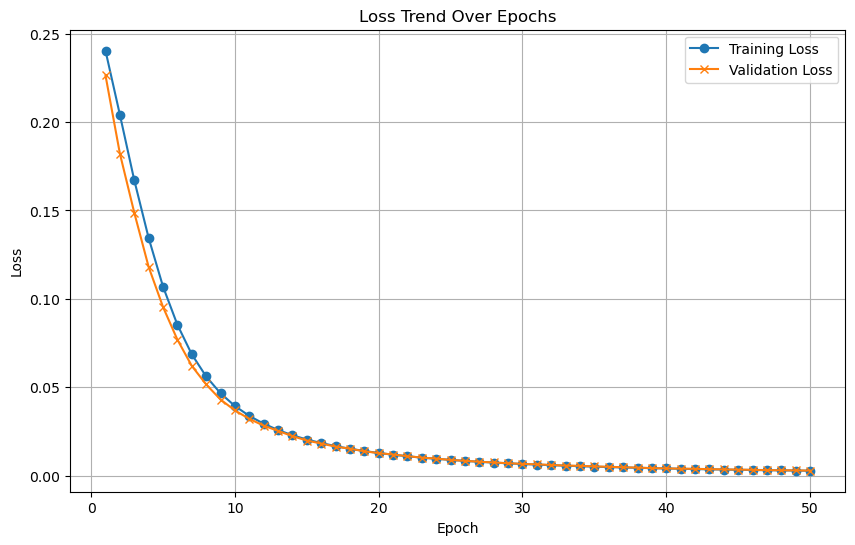

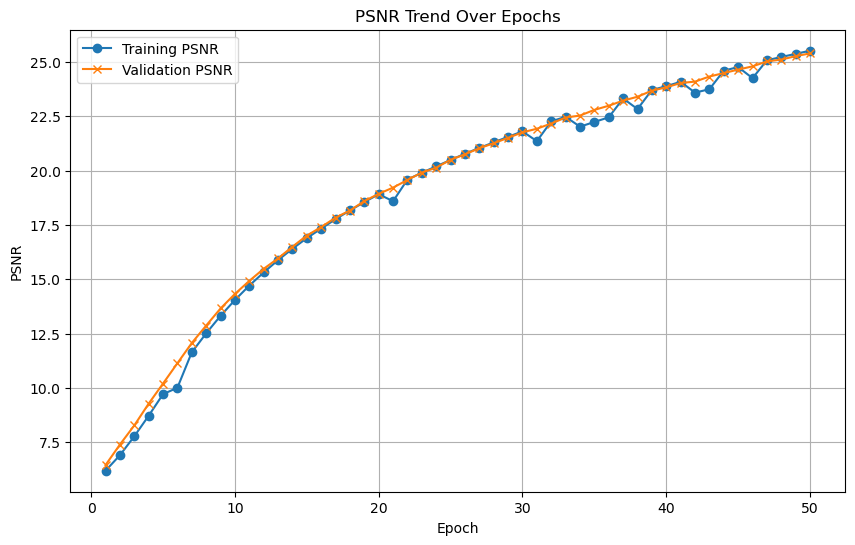

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/19 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.5881
    Validation Batch [1/1], Loss: 2.5730
Validation Loss: 2.5730, Validation Accuracy: 7.69%
Validation loss improved from inf to 2.5730. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5651
    Validation Batch [1/1], Loss: 2.5729
Validation Loss: 2.5729, Validation Accuracy: 7.69%
Validation loss improved from 2.5730 to 2.5729. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5605
    Validation Batch [1/1], Loss: 2.5728
Validation Loss: 2.5728, Validation Accuracy: 7.69%
Validation loss improved from 2.5729 to 2.5728. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5539
    Validation Batch [1/1], Loss: 2.5727
Validation Loss: 2.5727, Validation Accuracy: 7.69%
Validation loss improved from 2.5728 to 2.5727. Saving model...

LOG: Epoch [5/1000] - 

Epoch [6/1000] completed, Average Training Loss: 2.5355
    Validation Batch [1/1], Loss: 2.5725
Validation Loss: 2.5725, Validation Accuracy: 7.69%
Validation loss improved from 2.5726 to 2.5725. Saving model...

LOG: Epoch [7/1000] - Training
Epoch [7/1000] completed, Average Training Loss: 2.5323
    Validation Batch [1/1], Loss: 2.5723
Validation Loss: 2.5723, Validation Accuracy: 7.69%
Validation loss improved from 2.5725 to 2.5723. Saving model...

LOG: Epoch [8/1000] - Training
Epoch [8/1000] completed, Average Training Loss: 2.5232
    Validation Batch [1/1], Loss: 2.5721
Validation Loss: 2.5721, Validation Accuracy: 7.69%
Validation loss improved from 2.5723 to 2.5721. Saving model...

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 2.5129
    Validation Batch [1/1], Loss: 2.5720
Validation Loss: 2.5720, Validation Accuracy: 7.69%
Validation loss improved from 2.5721 to 2.5720. Saving model...

LOG: Epoch [10/1000] - Training


Epoch [10/1000] completed, Average Training Loss: 2.5059
    Validation Batch [1/1], Loss: 2.5718
Validation Loss: 2.5718, Validation Accuracy: 7.69%
Validation loss improved from 2.5720 to 2.5718. Saving model...

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.4877
    Validation Batch [1/1], Loss: 2.5715
Validation Loss: 2.5715, Validation Accuracy: 7.69%
Validation loss improved from 2.5718 to 2.5715. Saving model...

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 2.4787
    Validation Batch [1/1], Loss: 2.5713
Validation Loss: 2.5713, Validation Accuracy: 7.69%
Validation loss improved from 2.5715 to 2.5713. Saving model...

LOG: Epoch [13/1000] - Training
Epoch [13/1000] completed, Average Training Loss: 2.4736
    Validation Batch [1/1], Loss: 2.5711
Validation Loss: 2.5711, Validation Accuracy: 7.69%
Validation loss improved from 2.5713 to 2.5711. Saving model...

LOG: Epoch [14/1000] - Training
Epoch [14/10

Epoch [20/1000] completed, Average Training Loss: 2.3777
    Validation Batch [1/1], Loss: 2.5667
Validation Loss: 2.5667, Validation Accuracy: 7.69%
Validation loss improved from 2.5676 to 2.5667. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.3571
    Validation Batch [1/1], Loss: 2.5657
Validation Loss: 2.5657, Validation Accuracy: 7.69%
Validation loss improved from 2.5667 to 2.5657. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.3476
    Validation Batch [1/1], Loss: 2.5647
Validation Loss: 2.5647, Validation Accuracy: 7.69%
Validation loss improved from 2.5657 to 2.5647. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.3336
    Validation Batch [1/1], Loss: 2.5633
Validation Loss: 2.5633, Validation Accuracy: 7.69%
Validation loss improved from 2.5647 to 2.5633. Saving model...

LOG: Epoch [24/1000] - Training


Epoch [24/1000] completed, Average Training Loss: 2.3240
    Validation Batch [1/1], Loss: 2.5619
Validation Loss: 2.5619, Validation Accuracy: 7.69%
Validation loss improved from 2.5633 to 2.5619. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.3082
    Validation Batch [1/1], Loss: 2.5610
Validation Loss: 2.5610, Validation Accuracy: 7.69%
Validation loss improved from 2.5619 to 2.5610. Saving model...

LOG: Epoch [26/1000] - Training
Epoch [26/1000] completed, Average Training Loss: 2.2926
    Validation Batch [1/1], Loss: 2.5595
Validation Loss: 2.5595, Validation Accuracy: 7.69%
Validation loss improved from 2.5610 to 2.5595. Saving model...

LOG: Epoch [27/1000] - Training
Epoch [27/1000] completed, Average Training Loss: 2.2762
    Validation Batch [1/1], Loss: 2.5561
Validation Loss: 2.5561, Validation Accuracy: 7.69%
Validation loss improved from 2.5595 to 2.5561. Saving model...

LOG: Epoch [28/1000] - Training
Epoch [28/10

Epoch [36/1000] completed, Average Training Loss: 2.1484


    Validation Batch [1/1], Loss: 2.4866
Validation Loss: 2.4866, Validation Accuracy: 20.00%
Validation loss improved from 2.4997 to 2.4866. Saving model...

LOG: Epoch [37/1000] - Training
Epoch [37/1000] completed, Average Training Loss: 2.1261
    Validation Batch [1/1], Loss: 2.4680
Validation Loss: 2.4680, Validation Accuracy: 20.00%
Validation loss improved from 2.4866 to 2.4680. Saving model...

LOG: Epoch [38/1000] - Training
Epoch [38/1000] completed, Average Training Loss: 2.1237
    Validation Batch [1/1], Loss: 2.4442
Validation Loss: 2.4442, Validation Accuracy: 21.54%
Validation loss improved from 2.4680 to 2.4442. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 2.1027
    Validation Batch [1/1], Loss: 2.4198
Validation Loss: 2.4198, Validation Accuracy: 23.08%
Validation loss improved from 2.4442 to 2.4198. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 2.0995
    Vali

Epoch [51/1000] completed, Average Training Loss: 1.9622
    Validation Batch [1/1], Loss: 2.0778
Validation Loss: 2.0778, Validation Accuracy: 33.85%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 1.9273
    Validation Batch [1/1], Loss: 2.0558
Validation Loss: 2.0558, Validation Accuracy: 36.92%
Validation loss improved from 2.0773 to 2.0558. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 1.9212
    Validation Batch [1/1], Loss: 2.0193
Validation Loss: 2.0193, Validation Accuracy: 41.54%
Validation loss improved from 2.0558 to 2.0193. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 1.9178
    Validation Batch [1/1], Loss: 1.9918
Validation Loss: 1.9918, Validation Accuracy: 43.08%
Validation loss improved from 2.0193 to 1.9918. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] complet

Epoch [66/1000] completed, Average Training Loss: 1.7244
    Validation Batch [1/1], Loss: 1.8810
Validation Loss: 1.8810, Validation Accuracy: 41.54%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [67/1000] - Training
Epoch [67/1000] completed, Average Training Loss: 1.7061
    Validation Batch [1/1], Loss: 1.8610
Validation Loss: 1.8610, Validation Accuracy: 41.54%
Validation loss improved from 1.8624 to 1.8610. Saving model...

LOG: Epoch [68/1000] - Training
Epoch [68/1000] completed, Average Training Loss: 1.7048
    Validation Batch [1/1], Loss: 1.8152
Validation Loss: 1.8152, Validation Accuracy: 46.15%
Validation loss improved from 1.8610 to 1.8152. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 1.7065
    Validation Batch [1/1], Loss: 1.7769
Validation Loss: 1.7769, Validation Accuracy: 47.69%
Validation loss improved from 1.8152 to 1.7769. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [70/1000] complet

Epoch [80/1000] completed, Average Training Loss: 1.5118
    Validation Batch [1/1], Loss: 1.7384
Validation Loss: 1.7384, Validation Accuracy: 41.54%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [81/1000] - Training
Epoch [81/1000] completed, Average Training Loss: 1.5076
    Validation Batch [1/1], Loss: 1.6620
Validation Loss: 1.6620, Validation Accuracy: 46.15%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 1.4677
    Validation Batch [1/1], Loss: 1.5769
Validation Loss: 1.5769, Validation Accuracy: 50.77%
Validation loss improved from 1.6275 to 1.5769. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 1.4638
    Validation Batch [1/1], Loss: 1.5763
Validation Loss: 1.5763, Validation Accuracy: 52.31%
Validation loss improved from 1.5769 to 1.5763. Saving model...

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Tra


LOG: Epoch [95/1000] - Training
Epoch [95/1000] completed, Average Training Loss: 1.2523
    Validation Batch [1/1], Loss: 1.4053
Validation Loss: 1.4053, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [96/1000] - Training
Epoch [96/1000] completed, Average Training Loss: 1.2525
    Validation Batch [1/1], Loss: 1.3793
Validation Loss: 1.3793, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 1.2467
    Validation Batch [1/1], Loss: 1.3238
Validation Loss: 1.3238, Validation Accuracy: 69.23%
Validation loss improved from 1.3783 to 1.3238. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.2320
    Validation Batch [1/1], Loss: 1.3516
Validation Loss: 1.3516, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [99/1000] - Training
Epoch [99/1000] comp

Epoch [109/1000] completed, Average Training Loss: 1.0410
    Validation Batch [1/1], Loss: 1.1745
Validation Loss: 1.1745, Validation Accuracy: 72.31%
Validation loss improved from 1.2078 to 1.1745. Saving model...

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Training Loss: 1.0323
    Validation Batch [1/1], Loss: 1.2213
Validation Loss: 1.2213, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 1.0196
    Validation Batch [1/1], Loss: 1.1806
Validation Loss: 1.1806, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 1.0105
    Validation Batch [1/1], Loss: 1.1137
Validation Loss: 1.1137, Validation Accuracy: 76.92%
Validation loss improved from 1.1745 to 1.1137. Saving model...

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Av

Epoch [125/1000] completed, Average Training Loss: 0.8139
    Validation Batch [1/1], Loss: 0.9871
Validation Loss: 0.9871, Validation Accuracy: 75.38%
Validation loss improved from 0.9999 to 0.9871. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 0.7959
    Validation Batch [1/1], Loss: 1.0173
Validation Loss: 1.0173, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 0.7839
    Validation Batch [1/1], Loss: 0.9996
Validation Loss: 0.9996, Validation Accuracy: 75.38%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [128/1000] - Training
Epoch [128/1000] completed, Average Training Loss: 0.8105
    Validation Batch [1/1], Loss: 0.9560
Validation Loss: 0.9560, Validation Accuracy: 80.00%
Validation loss improved from 0.9871 to 0.9560. Saving model...

LOG: Epoch [129/1000] - Training
Epoch [129/1000] completed, Av

Epoch [140/1000] completed, Average Training Loss: 0.6694
    Validation Batch [1/1], Loss: 0.8346
Validation Loss: 0.8346, Validation Accuracy: 81.54%
Validation loss improved from 0.8480 to 0.8346. Saving model...

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 0.6098
    Validation Batch [1/1], Loss: 0.8002
Validation Loss: 0.8002, Validation Accuracy: 83.08%
Validation loss improved from 0.8346 to 0.8002. Saving model...

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 0.6178
    Validation Batch [1/1], Loss: 0.8171
Validation Loss: 0.8171, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Average Training Loss: 0.6138
    Validation Batch [1/1], Loss: 0.8256
Validation Loss: 0.8256, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [144/1000] - Training
Epoch [144/1000] completed, Av

Epoch [155/1000] completed, Average Training Loss: 0.4990
    Validation Batch [1/1], Loss: 0.7270
Validation Loss: 0.7270, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training Loss: 0.4748
    Validation Batch [1/1], Loss: 0.7498
Validation Loss: 0.7498, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 0.4527
    Validation Batch [1/1], Loss: 0.7050
Validation Loss: 0.7050, Validation Accuracy: 83.08%
Validation loss improved from 0.7073 to 0.7050. Saving model...

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Average Training Loss: 0.4788
    Validation Batch [1/1], Loss: 0.6990
Validation Loss: 0.6990, Validation Accuracy: 83.08%
Validation loss improved from 0.7050 to 0.6990. Saving model...

LOG: Epoch [159/1000] - Training
Epoch [159/1000] completed, Av

    Validation Batch [1/1], Loss: 0.6188
Validation Loss: 0.6188, Validation Accuracy: 86.15%
Validation loss improved from 0.6256 to 0.6188. Saving model...

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 0.3728
    Validation Batch [1/1], Loss: 0.6483
Validation Loss: 0.6483, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training Loss: 0.3444
    Validation Batch [1/1], Loss: 0.6255
Validation Loss: 0.6255, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [172/1000] - Training
Epoch [172/1000] completed, Average Training Loss: 0.3398
    Validation Batch [1/1], Loss: 0.5958
Validation Loss: 0.5958, Validation Accuracy: 83.08%
Validation loss improved from 0.6188 to 0.5958. Saving model...

LOG: Epoch [173/1000] - Training
Epoch [173/1000] completed, Average Training Loss: 0.3506
    Validation Batch [1/1], Lo

Epoch [184/1000] completed, Average Training Loss: 0.2670
    Validation Batch [1/1], Loss: 0.5428
Validation Loss: 0.5428, Validation Accuracy: 87.69%
Validation loss improved from 0.5627 to 0.5428. Saving model...

LOG: Epoch [185/1000] - Training
Epoch [185/1000] completed, Average Training Loss: 0.2630
    Validation Batch [1/1], Loss: 0.7798
Validation Loss: 0.7798, Validation Accuracy: 75.38%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training Loss: 0.2722
    Validation Batch [1/1], Loss: 0.5538
Validation Loss: 0.5538, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 0.2664
    Validation Batch [1/1], Loss: 0.5477
Validation Loss: 0.5477, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training 

Epoch [199/1000] completed, Average Training Loss: 0.2005
    Validation Batch [1/1], Loss: 0.5647
Validation Loss: 0.5647, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Training Loss: 0.2184
    Validation Batch [1/1], Loss: 0.5580
Validation Loss: 0.5580, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training Loss: 0.2123
    Validation Batch [1/1], Loss: 0.6812
Validation Loss: 0.6812, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training Loss: 0.1933
    Validation Batch [1/1], Loss: 0.5047
Validation Loss: 0.5047, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 0.2039
  

Epoch [209/1000] completed, Average Training Loss: 0.1691
    Validation Batch [1/1], Loss: 0.5026
Validation Loss: 0.5026, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 0.1693
    Validation Batch [1/1], Loss: 0.4848
Validation Loss: 0.4848, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.1793
    Validation Batch [1/1], Loss: 0.5116
Validation Loss: 0.5116, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 0.1690
    Validation Batch [1/1], Loss: 0.5142
Validation Loss: 0.5142, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.1681
  

Epoch [224/1000] completed, Average Training Loss: 0.1467
    Validation Batch [1/1], Loss: 0.4558
Validation Loss: 0.4558, Validation Accuracy: 89.23%
Validation loss improved from 0.4634 to 0.4558. Saving model...

LOG: Epoch [225/1000] - Training
Epoch [225/1000] completed, Average Training Loss: 0.1280
    Validation Batch [1/1], Loss: 0.5082
Validation Loss: 0.5082, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [226/1000] - Training
Epoch [226/1000] completed, Average Training Loss: 0.1414
    Validation Batch [1/1], Loss: 0.4830
Validation Loss: 0.4830, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.1349
    Validation Batch [1/1], Loss: 0.6373
Validation Loss: 0.6373, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training 

Epoch [239/1000] completed, Average Training Loss: 0.1117
    Validation Batch [1/1], Loss: 0.4691
Validation Loss: 0.4691, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.1035
    Validation Batch [1/1], Loss: 0.4640
Validation Loss: 0.4640, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [241/1000] - Training
Epoch [241/1000] completed, Average Training Loss: 0.1014
    Validation Batch [1/1], Loss: 0.5213
Validation Loss: 0.5213, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Average Training Loss: 0.1050
    Validation Batch [1/1], Loss: 0.5726
Validation Loss: 0.5726, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [243/1000] - Training
Epoch [243/1000] completed, Average Training Loss: 0.105

Epoch [254/1000] completed, Average Training Loss: 0.0932
    Validation Batch [1/1], Loss: 0.4582
Validation Loss: 0.4582, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [255/1000] - Training
Epoch [255/1000] completed, Average Training Loss: 0.0772
    Validation Batch [1/1], Loss: 0.4629
Validation Loss: 0.4629, Validation Accuracy: 90.77%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.0990
    Validation Batch [1/1], Loss: 0.5155
Validation Loss: 0.5155, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.0888
    Validation Batch [1/1], Loss: 0.5606
Validation Loss: 0.5606, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.084

Epoch [269/1000] completed, Average Training Loss: 0.0860
    Validation Batch [1/1], Loss: 0.4446
Validation Loss: 0.4446, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.0826
    Validation Batch [1/1], Loss: 0.4455
Validation Loss: 0.4455, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.0733
    Validation Batch [1/1], Loss: 0.4931
Validation Loss: 0.4931, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.0719
    Validation Batch [1/1], Loss: 0.4982
Validation Loss: 0.4982, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training Loss: 0.077

Epoch [284/1000] completed, Average Training Loss: 0.0651
    Validation Batch [1/1], Loss: 0.6313
Validation Loss: 0.6313, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [285/1000] - Training
Epoch [285/1000] completed, Average Training Loss: 0.0614
    Validation Batch [1/1], Loss: 0.6049
Validation Loss: 0.6049, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.0681
    Validation Batch [1/1], Loss: 0.5361
Validation Loss: 0.5361, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.0676
    Validation Batch [1/1], Loss: 0.5612
Validation Loss: 0.5612, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.052

Epoch [298/1000] completed, Average Training Loss: 0.0595
    Validation Batch [1/1], Loss: 0.5734
Validation Loss: 0.5734, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [299/1000] - Training
Epoch [299/1000] completed, Average Training Loss: 0.0524
    Validation Batch [1/1], Loss: 0.5377
Validation Loss: 0.5377, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [300/1000] - Training
Epoch [300/1000] completed, Average Training Loss: 0.0506
    Validation Batch [1/1], Loss: 0.5363
Validation Loss: 0.5363, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Average Training Loss: 0.0575
    Validation Batch [1/1], Loss: 0.5329
Validation Loss: 0.5329, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.051

Epoch [312/1000] completed, Average Training Loss: 0.0515
    Validation Batch [1/1], Loss: 0.5238
Validation Loss: 0.5238, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.0525
    Validation Batch [1/1], Loss: 0.4817
Validation Loss: 0.4817, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.0476
    Validation Batch [1/1], Loss: 0.4569
Validation Loss: 0.4569, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.0492
    Validation Batch [1/1], Loss: 0.4889
Validation Loss: 0.4889, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.050

Epoch [328/1000] completed, Average Training Loss: 0.0426
    Validation Batch [1/1], Loss: 0.5648
Validation Loss: 0.5648, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [329/1000] - Training
Epoch [329/1000] completed, Average Training Loss: 0.0389
    Validation Batch [1/1], Loss: 0.5543
Validation Loss: 0.5543, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training Loss: 0.0393
    Validation Batch [1/1], Loss: 0.5048
Validation Loss: 0.5048, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.0415
    Validation Batch [1/1], Loss: 0.5223
Validation Loss: 0.5223, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.042

    Validation Batch [1/1], Loss: 0.5859
Validation Loss: 0.5859, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 98/100

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Training Loss: 0.0349
    Validation Batch [1/1], Loss: 0.5904
Validation Loss: 0.5904, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 99/100

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Average Training Loss: 0.0376
    Validation Batch [1/1], Loss: 0.5646
Validation Loss: 0.5646, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 344. No improvement for 100 epochs.
Loading the best model weights...


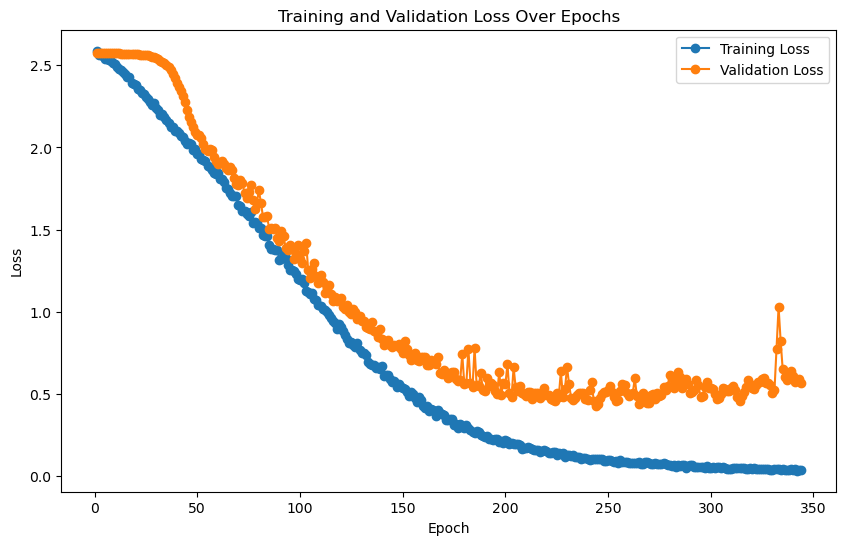

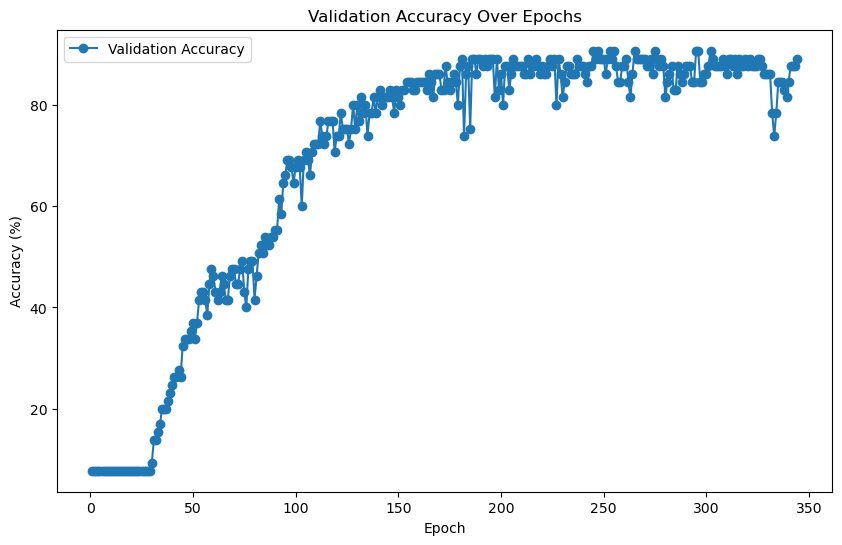


Evaluating on the test set...


    Test Batch [1/19], Loss: 0.3788

Final Test Loss: 0.5573, Test Accuracy: 87.92%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/19 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 520 samples with 64 features each
LOG: Labels shape: (520,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4626 samples with 64 features each
LOG: Labels shape: (4626,)

LOG: Training features shape: (520, 64), Training labels shape: (520,)
LOG: Validation features shape: (65, 64), Validation labels shape: (65,)
LOG: Test features shape: (4626, 64), Test labels shape: (4626,)

LOG: Training Logistic Regression model...


LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 35.38%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.40      0.31         5
           1       0.00      0.00      0.00         5
           2       0.18      0.40      0.25         5
           3       0.00      0.00      0.00         5
           4       1.00      0.20      0.33         5
           5       0.25      0.20      0.22         5
           6       0.00      0.00      0.00         5
           7       0.33      0.80      0.47         5
           8       0.36      0.80      0.50         5
           9       0.00      0.00      0.00         5
          10       0.80      0.80      0.80         5
          11       0.33      0.20      0.25         5
          12       0.50      0.80      0.62         5

    accuracy                           0.35        65
   macro avg       0.31      0.35     

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 520 samples with 64 features each
LOG: Labels shape: (520,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4626 samples with 64 features each
LOG: Labels shape: (4626,)
Train reps shape: (520, 64)
Train labels shape: (520,)
Val reps shape: (65, 64)
Val labels shape: (65,)
Test reps shape: (4626, 64)
Test labels shape: (4626,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6418  |  Val Loss: 2.5803
Validation loss improved from inf to 2.5803.
[Epoch 2/1000] Train Loss: 2.5550  |  Val Loss: 2.5513
Validation loss improved from 2.5803 to 2.5513.
[Epoch 3/1000] Train Loss: 2.5282  |  Val Loss: 2.5354
Validation loss improved from 2.5513 to 2.5354.
[Epoch 4/1000] Train Loss: 2.5146  |  Val Loss: 2.5216
Validation loss improved from 2.5354 to 2.5216.
[Epoch 5/1000] Train Loss: 2.5030  |  Val Loss: 2.5038
Validation loss improved from 2.5216 to 2.5038.
[Epoch 6/1000] Train Loss: 2.4893  |  Val Loss: 2.4894
Validation loss improved from 2.5038 to 2.4894.
[Epoch 7/1000] Train Loss: 2.4796  |  Val Loss: 2.4788
Validation loss improved from 2.4894 to 2.4788.


[Epoch 8/1000] Train Loss: 2.4650  |  Val Loss: 2.4602
Validation loss improved from 2.4788 to 2.4602.


[Epoch 9/1000] Train Loss: 2.4575  |  Val Loss: 2.4467
Validation loss improved from 2.4602 to 2.4467.
[Epoch 10/1000] Train Loss: 2.4429  |  Val Loss: 2.4399
Validation loss improved from 2.4467 to 2.4399.
[Epoch 11/1000] Train Loss: 2.4343  |  Val Loss: 2.4371
Validation loss improved from 2.4399 to 2.4371.
[Epoch 12/1000] Train Loss: 2.4354  |  Val Loss: 2.4313
Validation loss improved from 2.4371 to 2.4313.


[Epoch 13/1000] Train Loss: 2.4170  |  Val Loss: 2.4266
Validation loss improved from 2.4313 to 2.4266.
[Epoch 14/1000] Train Loss: 2.4084  |  Val Loss: 2.4182
Validation loss improved from 2.4266 to 2.4182.
[Epoch 15/1000] Train Loss: 2.4065  |  Val Loss: 2.4228
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 16/1000] Train Loss: 2.4070  |  Val Loss: 2.4189
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 17/1000] Train Loss: 2.3999  |  Val Loss: 2.4187
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 18/1000] Train Loss: 2.3855  |  Val Loss: 2.4155
Validation loss improved from 2.4182 to 2.4155.
[Epoch 19/1000] Train Loss: 2.3868  |  Val Loss: 2.4105
Validation loss improved from 2.4155 to 2.4105.


[Epoch 20/1000] Train Loss: 2.3722  |  Val Loss: 2.3961
Validation loss improved from 2.4105 to 2.3961.
[Epoch 21/1000] Train Loss: 2.3809  |  Val Loss: 2.3937
Validation loss improved from 2.3961 to 2.3937.
[Epoch 22/1000] Train Loss: 2.3763  |  Val Loss: 2.3980
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 23/1000] Train Loss: 2.3602  |  Val Loss: 2.3874
Validation loss improved from 2.3937 to 2.3874.
[Epoch 24/1000] Train Loss: 2.3530  |  Val Loss: 2.3808
Validation loss improved from 2.3874 to 2.3808.
[Epoch 25/1000] Train Loss: 2.3418  |  Val Loss: 2.3787
Validation loss improved from 2.3808 to 2.3787.


[Epoch 26/1000] Train Loss: 2.3395  |  Val Loss: 2.3740
Validation loss improved from 2.3787 to 2.3740.
[Epoch 27/1000] Train Loss: 2.3325  |  Val Loss: 2.3662
Validation loss improved from 2.3740 to 2.3662.
[Epoch 28/1000] Train Loss: 2.3227  |  Val Loss: 2.3559
Validation loss improved from 2.3662 to 2.3559.
[Epoch 29/1000] Train Loss: 2.3151  |  Val Loss: 2.3490
Validation loss improved from 2.3559 to 2.3490.
[Epoch 30/1000] Train Loss: 2.3093  |  Val Loss: 2.3434
Validation loss improved from 2.3490 to 2.3434.
[Epoch 31/1000] Train Loss: 2.2967  |  Val Loss: 2.3395
Validation loss improved from 2.3434 to 2.3395.
[Epoch 32/1000] Train Loss: 2.2807  |  Val Loss: 2.3257
Validation loss improved from 2.3395 to 2.3257.


[Epoch 33/1000] Train Loss: 2.2729  |  Val Loss: 2.3226
Validation loss improved from 2.3257 to 2.3226.
[Epoch 34/1000] Train Loss: 2.2728  |  Val Loss: 2.3339
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 35/1000] Train Loss: 2.2539  |  Val Loss: 2.3196
Validation loss improved from 2.3226 to 2.3196.
[Epoch 36/1000] Train Loss: 2.2475  |  Val Loss: 2.3280
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 37/1000] Train Loss: 2.2376  |  Val Loss: 2.2929
Validation loss improved from 2.3196 to 2.2929.
[Epoch 38/1000] Train Loss: 2.2138  |  Val Loss: 2.2959
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 39/1000] Train Loss: 2.2082  |  Val Loss: 2.2712
Validation loss improved from 2.2929 to 2.2712.
[Epoch 40/1000] Train Loss: 2.1812  |  Val Loss: 2.2501
Validation loss improved from 2.2712 to 2.2501.
[Epoch 41/1000] Train Loss: 2.1625  |  Val Loss: 2.2486
Validation loss improved from 2.2501 to 2.2486.
[Epoch 42/1000] Train Loss: 2.1653  |  Val Loss: 2.2283
Validation loss improved from 2.2486 to 2.2283.
[Epoch 43/1000] Train Loss: 2.1496  |  Val Loss: 2.2341
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 44/1000] Train Loss: 2.1542  |  Val Loss: 2.2264
Validation loss improved from 2.2283 to 2.2264.


[Epoch 45/1000] Train Loss: 2.1198  |  Val Loss: 2.1946
Validation loss improved from 2.2264 to 2.1946.
[Epoch 46/1000] Train Loss: 2.1013  |  Val Loss: 2.1864
Validation loss improved from 2.1946 to 2.1864.
[Epoch 47/1000] Train Loss: 2.0823  |  Val Loss: 2.1939
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 48/1000] Train Loss: 2.0787  |  Val Loss: 2.1663
Validation loss improved from 2.1864 to 2.1663.


[Epoch 49/1000] Train Loss: 2.0845  |  Val Loss: 2.1844
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 50/1000] Train Loss: 2.0925  |  Val Loss: 2.1851
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 51/1000] Train Loss: 2.0607  |  Val Loss: 2.1739
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 52/1000] Train Loss: 2.0488  |  Val Loss: 2.1552
Validation loss improved from 2.1663 to 2.1552.
[Epoch 53/1000] Train Loss: 2.0238  |  Val Loss: 2.1427
Validation loss improved from 2.1552 to 2.1427.
[Epoch 54/1000] Train Loss: 2.0416  |  Val Loss: 2.1886
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 55/1000] Train Loss: 2.0337  |  Val Loss: 2.1918
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 56/1000] Train Loss: 2.0323  |  Val Loss: 2.1934
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 57/1000] Train Loss: 2.0434  |  Val Loss: 2.1732
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 58/1000] Train Loss: 2.0180  |  Val Loss: 2.2753
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 59/1000] Train Loss: 2.0635  |  Val Loss: 2.2325
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 60/1000] Train Loss: 2.0479  |  Val Loss: 2.0995
Validation loss improved from 2.1427 to 2.0995.


[Epoch 61/1000] Train Loss: 2.0051  |  Val Loss: 2.1766
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 62/1000] Train Loss: 1.9706  |  Val Loss: 2.1566
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 63/1000] Train Loss: 1.9993  |  Val Loss: 2.0558
Validation loss improved from 2.0995 to 2.0558.
[Epoch 64/1000] Train Loss: 1.9460  |  Val Loss: 2.0712
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 65/1000] Train Loss: 1.9686  |  Val Loss: 2.0706
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 66/1000] Train Loss: 1.9391  |  Val Loss: 2.0383
Validation loss improved from 2.0558 to 2.0383.
[Epoch 67/1000] Train Loss: 1.9103  |  Val Loss: 2.0322
Validation loss improved from 2.0383 to 2.0322.
[Epoch 68/1000] Train Loss: 1.9003  |  Val Loss: 2.0083
Validation loss improved from 2.0322 to 2.0083.
[Epoch 69/1000] Train Loss: 1.8923  |  Val Loss: 2.0160
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 70/1000] Train Loss: 1.8828  |  Val Loss: 1.9916
Validation loss improved from 2.0083 to 1.9916.
[Epoch 71/1000] Train Loss: 1.8831  |  Val Loss: 2.0394
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 72/1000] Train Loss: 1.9487  |  Val Loss: 2.0154
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 73/1000] Train Loss: 1.9784  |  Val Loss: 1.9966
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 74/1000] Train Loss: 1.8862  |  Val Loss: 1.9867
Validation loss improved from 1.9916 to 1.9867.
[Epoch 75/1000] Train Loss: 1.8613  |  Val Loss: 1.9713
Validation loss improved from 1.9867 to 1.9713.
[Epoch 76/1000] Train Loss: 1.8486  |  Val Loss: 1.9751
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 77/1000] Train Loss: 1.8566  |  Val Loss: 1.9597
Validation loss improved from 1.9713 to 1.9597.
[Epoch 78/1000] Train Loss: 1.8436  |  Val Loss: 1.9582
Validation loss improved from 1.9597 to 1.9582.
[Epoch 79/1000] Train Loss: 1.8248  |  Val Loss: 1.9682
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 80/1000] Train Loss: 1.8223  |  Val Loss: 2.0057
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 81/1000] Train Loss: 1.8226  |  Val Loss: 2.0515
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 82/1000] Train Loss: 1.8223  |  Val Loss: 1.9231
Validation loss improved from 1.9582 to 1.9231.
[Epoch 83/1000] Train Loss: 1.8097  |  Val Loss: 1.9696
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 84/1000] Train Loss: 1.8097  |  Val Loss: 1.9224
Validation loss improved from 1.9231 to 1.9224.
[Epoch 85/1000] Train Loss: 1.7862  |  Val Loss: 1.9288
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 86/1000] Train Loss: 1.7873  |  Val Loss: 1.9620
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 87/1000] Train Loss: 1.7778  |  Val Loss: 1.9751
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 88/1000] Train Loss: 1.7754  |  Val Loss: 1.9106
Validation loss improved from 1.9224 to 1.9106.
[Epoch 89/1000] Train Loss: 1.7640  |  Val Loss: 1.9971
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 90/1000] Train Loss: 1.8209  |  Val Loss: 2.0781
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 91/1000] Train Loss: 1.8066  |  Val Loss: 1.9972
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 92/1000] Train Loss: 1.7580  |  Val Loss: 1.9128
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 93/1000] Train Loss: 1.7641  |  Val Loss: 1.9185
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 94/1000] Train Loss: 1.7961  |  Val Loss: 1.8651
Validation loss improved from 1.9106 to 1.8651.
[Epoch 95/1000] Train Loss: 1.7498  |  Val Loss: 1.9092
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 96/1000] Train Loss: 1.7896  |  Val Loss: 1.9848
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 97/1000] Train Loss: 1.8282  |  Val Loss: 1.9431
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 98/1000] Train Loss: 1.7650  |  Val Loss: 1.8950
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 99/1000] Train Loss: 1.7352  |  Val Loss: 1.8947
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 100/1000] Train Loss: 1.7238  |  Val Loss: 1.8789
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 101/1000] Train Loss: 1.7165  |  Val Loss: 1.8699
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 102/1000] Train Loss: 1.7104  |  Val Loss: 1.9542
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 103/1000] Train Loss: 1.7214  |  Val Loss: 1.8630
Validation loss improved from 1.8651 to 1.8630.


[Epoch 104/1000] Train Loss: 1.7078  |  Val Loss: 1.8568
Validation loss improved from 1.8630 to 1.8568.
[Epoch 105/1000] Train Loss: 1.7080  |  Val Loss: 1.8987
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 106/1000] Train Loss: 1.7671  |  Val Loss: 1.9236
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 107/1000] Train Loss: 1.7343  |  Val Loss: 1.8544
Validation loss improved from 1.8568 to 1.8544.
[Epoch 108/1000] Train Loss: 1.6949  |  Val Loss: 1.8527
Validation loss improved from 1.8544 to 1.8527.
[Epoch 109/1000] Train Loss: 1.7061  |  Val Loss: 1.8273
Validation loss improved from 1.8527 to 1.8273.
[Epoch 110/1000] Train Loss: 1.6727  |  Val Loss: 1.8557
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 111/1000] Train Loss: 1.6606  |  Val Loss: 1.8614
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 112/1000] Train Loss: 1.6682  |  Val Loss: 1.8757
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 113/1000] Train Loss: 1.6850  |  Val Loss: 1.8317
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 114/1000] Train Loss: 1.6559  |  Val Loss: 1.8567
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 115/1000] Train Loss: 1.6567  |  Val Loss: 1.8497
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 116/1000] Tr

[Epoch 117/1000] Train Loss: 1.6777  |  Val Loss: 1.8052
Validation loss improved from 1.8273 to 1.8052.
[Epoch 118/1000] Train Loss: 1.6476  |  Val Loss: 1.8641
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 119/1000] Train Loss: 1.6676  |  Val Loss: 1.9118
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 120/1000] Train Loss: 1.6829  |  Val Loss: 1.8663
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 121/1000] Train Loss: 1.6360  |  Val Loss: 1.8144
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 122/1000] Train Loss: 1.6422  |  Val Loss: 1.8487
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 123/1000] Train Loss: 1.6384  |  Val Loss: 1.8176
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 124/1000] Train Loss: 1.6601  |  Val Loss: 1.8520
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 125/1000] Train Loss: 1.6942  |  Val Loss: 2.2602
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 126/1000] Train Loss: 1.8103  |  Val Loss: 2.0998
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 127/1000] Train Loss: 1.7609  |  Val Loss: 2.1869
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 128/1000] Train Loss: 1.7764  |  Val Loss: 2.0480
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 129/1000] Train Loss: 1.6516  |  Val Loss: 2.0193
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 130/1000] Train Loss: 1.6925  |  Val Loss: 1.9426
!! Validation loss did NOT improve !! Patience: 13/100


[Epoch 131/1000] Train Loss: 1.6218  |  Val Loss: 1.8334
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 132/1000] Train Loss: 1.6153  |  Val Loss: 1.8499
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 133/1000] Train Loss: 1.5985  |  Val Loss: 1.8560
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 134/1000] Train Loss: 1.5947  |  Val Loss: 1.9175
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 135/1000] Train Loss: 1.6107  |  Val Loss: 1.9028
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 136/1000] Train Loss: 1.5954  |  Val Loss: 1.8235
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 137/1000] Train Loss: 1.5928  |  Val Loss: 1.8505
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 138/1000] Train Loss: 1.5808  |  Val Loss: 1.8203
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 139/1000] Train Loss: 1.5844  |  Val Loss: 1.8791
!! Validation loss did NOT improve !! Patience:

[Epoch 140/1000] Train Loss: 1.5815  |  Val Loss: 1.8234
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 141/1000] Train Loss: 1.5652  |  Val Loss: 1.8266
!! Validation loss did NOT improve !! Patience: 24/100


[Epoch 142/1000] Train Loss: 1.5666  |  Val Loss: 1.7997
Validation loss improved from 1.8052 to 1.7997.
[Epoch 143/1000] Train Loss: 1.5999  |  Val Loss: 1.8517
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 144/1000] Train Loss: 1.5891  |  Val Loss: 1.8170
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 145/1000] Train Loss: 1.5695  |  Val Loss: 1.8459
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 146/1000] Train Loss: 1.5749  |  Val Loss: 1.8079
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 147/1000] Train Loss: 1.5654  |  Val Loss: 1.8055
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 148/1000] Train Loss: 1.5670  |  Val Loss: 1.8035
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 149/1000] Train Loss: 1.6029  |  Val Loss: 1.8848
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 150/1000] Train Loss: 1.6088  |  Val Loss: 1.7837
Validation loss improved from 1.7997 to 1.7837.
[Epoch 151/10

[Epoch 152/1000] Train Loss: 1.5602  |  Val Loss: 1.7800
Validation loss improved from 1.7837 to 1.7800.
[Epoch 153/1000] Train Loss: 1.5494  |  Val Loss: 1.8369
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 154/1000] Train Loss: 1.5456  |  Val Loss: 1.7710
Validation loss improved from 1.7800 to 1.7710.


[Epoch 155/1000] Train Loss: 1.5548  |  Val Loss: 1.8431
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 156/1000] Train Loss: 1.5963  |  Val Loss: 1.8171
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 157/1000] Train Loss: 1.6072  |  Val Loss: 1.9772
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 158/1000] Train Loss: 1.5671  |  Val Loss: 1.8099
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 159/1000] Train Loss: 1.5474  |  Val Loss: 1.8917
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 160/1000] Train Loss: 1.5277  |  Val Loss: 1.7929
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 161/1000] Train Loss: 1.5588  |  Val Loss: 1.8881
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 162/1000] Train Loss: 1.5982  |  Val Loss: 1.8427
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 163/1000] Train Loss: 1.5420  |  Val Loss: 1.8726
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 166/1000] Train Loss: 1.5344  |  Val Loss: 1.9677
!! Validation loss did NOT improve !! Patience: 12/100


[Epoch 167/1000] Train Loss: 1.5556  |  Val Loss: 1.9192
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 168/1000] Train Loss: 1.5500  |  Val Loss: 1.8676
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 169/1000] Train Loss: 1.5492  |  Val Loss: 1.9313
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 170/1000] Train Loss: 1.5183  |  Val Loss: 1.8387
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 171/1000] Train Loss: 1.5450  |  Val Loss: 1.8594
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 172/1000] Train Loss: 1.5714  |  Val Loss: 1.8125
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 173/1000] Train Loss: 1.5433  |  Val Loss: 1.8091
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 174/1000] Train Loss: 1.5183  |  Val Loss: 1.8066
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 175/1000] Train Loss: 1.5374  |  Val Loss: 1.8277
!! Validation loss did NOT improve !! Patience:

[Epoch 178/1000] Train Loss: 1.5220  |  Val Loss: 1.9386
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 179/1000] Train Loss: 1.5225  |  Val Loss: 1.8842
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 180/1000] Train Loss: 1.5143  |  Val Loss: 1.8504
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 181/1000] Train Loss: 1.5274  |  Val Loss: 1.7459
Validation loss improved from 1.7710 to 1.7459.
[Epoch 182/1000] Train Loss: 1.5237  |  Val Loss: 2.0706
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 183/1000] Train Loss: 1.5075  |  Val Loss: 1.8183
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 184/1000] Train Loss: 1.4914  |  Val Loss: 1.8520
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 185/1000] Train Loss: 1.5103  |  Val Loss: 1.7823
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 186/1000] Train Loss: 1.5062  |  Val Loss: 1.8879
!! Validation loss did NOT improve !! Patience: 5/100
[Epo

[Epoch 191/1000] Train Loss: 1.5026  |  Val Loss: 1.8032
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 192/1000] Train Loss: 1.4930  |  Val Loss: 1.8148
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 193/1000] Train Loss: 1.5008  |  Val Loss: 1.8147
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 194/1000] Train Loss: 1.4835  |  Val Loss: 1.9179
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 195/1000] Train Loss: 1.4900  |  Val Loss: 1.8184
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 196/1000] Train Loss: 1.4723  |  Val Loss: 1.8170
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 197/1000] Train Loss: 1.4693  |  Val Loss: 1.8045
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 198/1000] Train Loss: 1.5129  |  Val Loss: 1.8834
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 199/1000] Train Loss: 1.5073  |  Val Loss: 1.8424
!! Validation loss did NOT improve !! Patience:

[Epoch 203/1000] Train Loss: 1.4909  |  Val Loss: 1.9873
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 204/1000] Train Loss: 1.4851  |  Val Loss: 1.9321
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 205/1000] Train Loss: 1.4720  |  Val Loss: 2.0856
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 206/1000] Train Loss: 1.5303  |  Val Loss: 2.1691
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 207/1000] Train Loss: 1.5128  |  Val Loss: 1.8831
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 208/1000] Train Loss: 1.4542  |  Val Loss: 1.8501
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 209/1000] Train Loss: 1.4494  |  Val Loss: 1.8641
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 210/1000] Train Loss: 1.4637  |  Val Loss: 1.9136
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 211/1000] Train Loss: 1.4697  |  Val Loss: 1.7932
!! Validation loss did NOT improve !! Patience:

[Epoch 216/1000] Train Loss: 1.5511  |  Val Loss: 2.1773
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 217/1000] Train Loss: 1.6318  |  Val Loss: 2.1027
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 218/1000] Train Loss: 1.6046  |  Val Loss: 2.0344
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 219/1000] Train Loss: 1.5323  |  Val Loss: 2.0333
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 220/1000] Train Loss: 1.5161  |  Val Loss: 1.8955
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 221/1000] Train Loss: 1.4748  |  Val Loss: 1.8315
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 222/1000] Train Loss: 1.4606  |  Val Loss: 1.8387
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 223/1000] Train Loss: 1.4833  |  Val Loss: 1.9283
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 224/1000] Train Loss: 1.5019  |  Val Loss: 1.8619
!! Validation loss did NOT improve !! Patience:

[Epoch 229/1000] Train Loss: 1.4317  |  Val Loss: 1.8081
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 230/1000] Train Loss: 1.4308  |  Val Loss: 1.8309
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 231/1000] Train Loss: 1.4981  |  Val Loss: 1.8735
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 232/1000] Train Loss: 1.4761  |  Val Loss: 1.8046
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 233/1000] Train Loss: 1.4364  |  Val Loss: 1.8261
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 234/1000] Train Loss: 1.4357  |  Val Loss: 1.8146
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 235/1000] Train Loss: 1.4632  |  Val Loss: 1.9023
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 236/1000] Train Loss: 1.4517  |  Val Loss: 1.8558
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 237/1000] Train Loss: 1.4345  |  Val Loss: 1.9774
!! Validation loss did NOT improve !! Patience:

[Epoch 241/1000] Train Loss: 1.4561  |  Val Loss: 1.8819
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 242/1000] Train Loss: 1.4564  |  Val Loss: 1.7650
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 243/1000] Train Loss: 1.4289  |  Val Loss: 1.8137
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 244/1000] Train Loss: 1.4221  |  Val Loss: 1.8712
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 245/1000] Train Loss: 1.4122  |  Val Loss: 1.9047
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 246/1000] Train Loss: 1.4063  |  Val Loss: 1.8374
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 247/1000] Train Loss: 1.4096  |  Val Loss: 1.9001
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 248/1000] Train Loss: 1.4151  |  Val Loss: 1.8456
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 249/1000] Train Loss: 1.4024  |  Val Loss: 1.8385
!! Validation loss did NOT improve !! Patience:

[Epoch 252/1000] Train Loss: 1.4210  |  Val Loss: 1.9214
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 253/1000] Train Loss: 1.4302  |  Val Loss: 2.1218
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 254/1000] Train Loss: 1.4821  |  Val Loss: 1.9204
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 255/1000] Train Loss: 1.4684  |  Val Loss: 1.8838
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 256/1000] Train Loss: 1.4315  |  Val Loss: 1.7451
Validation loss improved from 1.7459 to 1.7451.
[Epoch 257/1000] Train Loss: 1.4857  |  Val Loss: 1.7783
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 258/1000] Train Loss: 1.4107  |  Val Loss: 1.7986
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 259/1000] Train Loss: 1.4255  |  Val Loss: 1.8835
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 260/1000] Train Loss: 1.4236  |  Val Loss: 1.9300
!! Validation loss did NOT improve !! Patience: 4/100
[Ep

[Epoch 264/1000] Train Loss: 1.4101  |  Val Loss: 1.7933
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 265/1000] Train Loss: 1.4094  |  Val Loss: 1.9096
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 266/1000] Train Loss: 1.4210  |  Val Loss: 1.8275
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 267/1000] Train Loss: 1.4230  |  Val Loss: 1.8476
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 268/1000] Train Loss: 1.4116  |  Val Loss: 1.9572
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 269/1000] Train Loss: 1.4007  |  Val Loss: 2.0481
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 270/1000] Train Loss: 1.4404  |  Val Loss: 2.0035
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 271/1000] Train Loss: 1.4471  |  Val Loss: 2.0012
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 272/1000] Train Loss: 1.4273  |  Val Loss: 1.9554
!! Validation loss did NOT improve !! Patience: 1

[Epoch 277/1000] Train Loss: 1.4020  |  Val Loss: 1.8763
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 278/1000] Train Loss: 1.3792  |  Val Loss: 1.9316
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 279/1000] Train Loss: 1.3955  |  Val Loss: 1.7943
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 280/1000] Train Loss: 1.3764  |  Val Loss: 1.9089
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 281/1000] Train Loss: 1.3682  |  Val Loss: 1.8457
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 282/1000] Train Loss: 1.3834  |  Val Loss: 1.9619
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 283/1000] Train Loss: 1.4213  |  Val Loss: 1.8653
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 284/1000] Train Loss: 1.4351  |  Val Loss: 1.8949
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 285/1000] Train Loss: 1.3850  |  Val Loss: 1.8456
!! Validation loss did NOT improve !! Patience:

[Epoch 287/1000] Train Loss: 1.3691  |  Val Loss: 1.9071
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 288/1000] Train Loss: 1.3766  |  Val Loss: 1.9228
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 289/1000] Train Loss: 1.4273  |  Val Loss: 1.8423
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 290/1000] Train Loss: 1.4194  |  Val Loss: 1.8969
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 291/1000] Train Loss: 1.3881  |  Val Loss: 1.9268
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 292/1000] Train Loss: 1.3784  |  Val Loss: 1.8776
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 293/1000] Train Loss: 1.3664  |  Val Loss: 1.8932
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 294/1000] Train Loss: 1.3546  |  Val Loss: 1.8313
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 295/1000] Train Loss: 1.3976  |  Val Loss: 1.8092
!! Validation loss did NOT improve !! Patience:

[Epoch 298/1000] Train Loss: 1.4150  |  Val Loss: 1.8265
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 299/1000] Train Loss: 1.3555  |  Val Loss: 1.9013
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 300/1000] Train Loss: 1.3590  |  Val Loss: 1.9890
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 301/1000] Train Loss: 1.3719  |  Val Loss: 1.8866
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 302/1000] Train Loss: 1.3625  |  Val Loss: 1.8414
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 303/1000] Train Loss: 1.3734  |  Val Loss: 1.8554
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 304/1000] Train Loss: 1.3752  |  Val Loss: 1.8382
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 305/1000] Train Loss: 1.3984  |  Val Loss: 1.9073
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 306/1000] Train Loss: 1.3524  |  Val Loss: 1.9692
!! Validation loss did NOT improve !! Patience:

[Epoch 309/1000] Train Loss: 1.3541  |  Val Loss: 1.8269
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 310/1000] Train Loss: 1.3664  |  Val Loss: 1.8750
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 311/1000] Train Loss: 1.3949  |  Val Loss: 1.8684
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 312/1000] Train Loss: 1.4172  |  Val Loss: 1.9187
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 313/1000] Train Loss: 1.4153  |  Val Loss: 1.9653
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 314/1000] Train Loss: 1.5244  |  Val Loss: 1.8486
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 315/1000] Train Loss: 1.4123  |  Val Loss: 1.9143
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 316/1000] Train Loss: 1.4177  |  Val Loss: 1.8941
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 317/1000] Train Loss: 1.3989  |  Val Loss: 1.7942
!! Validation loss did NOT improve !! Patience:

[Epoch 321/1000] Train Loss: 1.3443  |  Val Loss: 1.9043
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 322/1000] Train Loss: 1.3489  |  Val Loss: 1.8908
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 323/1000] Train Loss: 1.3636  |  Val Loss: 1.8686
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 324/1000] Train Loss: 1.3263  |  Val Loss: 1.8248
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 325/1000] Train Loss: 1.3615  |  Val Loss: 1.8348
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 326/1000] Train Loss: 1.3238  |  Val Loss: 1.8894
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 327/1000] Train Loss: 1.3264  |  Val Loss: 1.9084
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 328/1000] Train Loss: 1.3552  |  Val Loss: 1.9884
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 329/1000] Train Loss: 1.3803  |  Val Loss: 1.9264
!! Validation loss did NOT improve !! Patience:

[Epoch 334/1000] Train Loss: 1.4008  |  Val Loss: 1.8612
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 335/1000] Train Loss: 1.3718  |  Val Loss: 2.0051
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 336/1000] Train Loss: 1.3952  |  Val Loss: 1.9288
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 337/1000] Train Loss: 1.3498  |  Val Loss: 1.8850
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 338/1000] Train Loss: 1.3662  |  Val Loss: 1.9834
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 339/1000] Train Loss: 1.4096  |  Val Loss: 2.2297
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 340/1000] Train Loss: 1.5274  |  Val Loss: 2.0533
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 341/1000] Train Loss: 1.4172  |  Val Loss: 1.9051
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 342/1000] Train Loss: 1.3521  |  Val Loss: 1.8535
!! Validation loss did NOT improve !! Patience:

[Epoch 346/1000] Train Loss: 1.3206  |  Val Loss: 1.8953
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 347/1000] Train Loss: 1.3018  |  Val Loss: 2.0374
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 348/1000] Train Loss: 1.3430  |  Val Loss: 1.9137
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 349/1000] Train Loss: 1.3272  |  Val Loss: 1.9750
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 350/1000] Train Loss: 1.3388  |  Val Loss: 1.9717
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 351/1000] Train Loss: 1.3294  |  Val Loss: 1.8483
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 352/1000] Train Loss: 1.3077  |  Val Loss: 1.8540
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 353/1000] Train Loss: 1.2943  |  Val Loss: 1.8646
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 354/1000] Train Loss: 1.2912  |  Val Loss: 2.0024
!! Validation loss did NOT improve !! Patience:

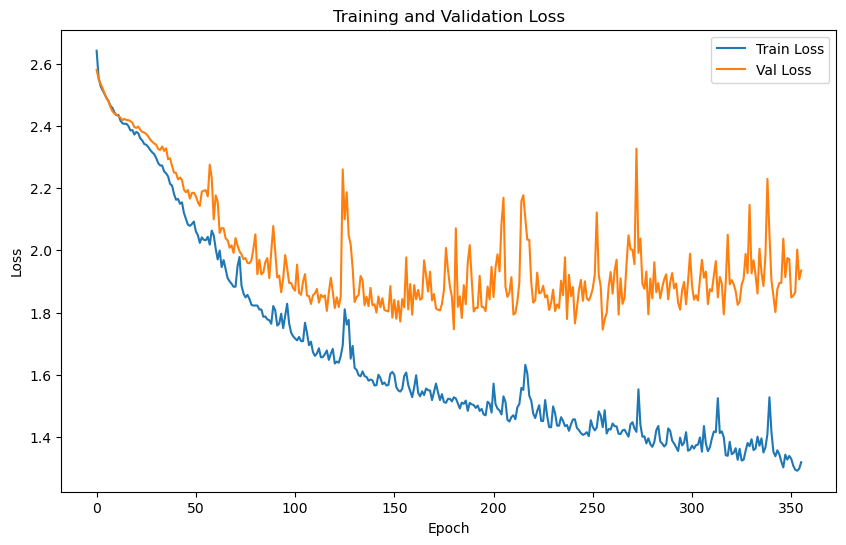

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.7895 | Test Accuracy: 46.04%


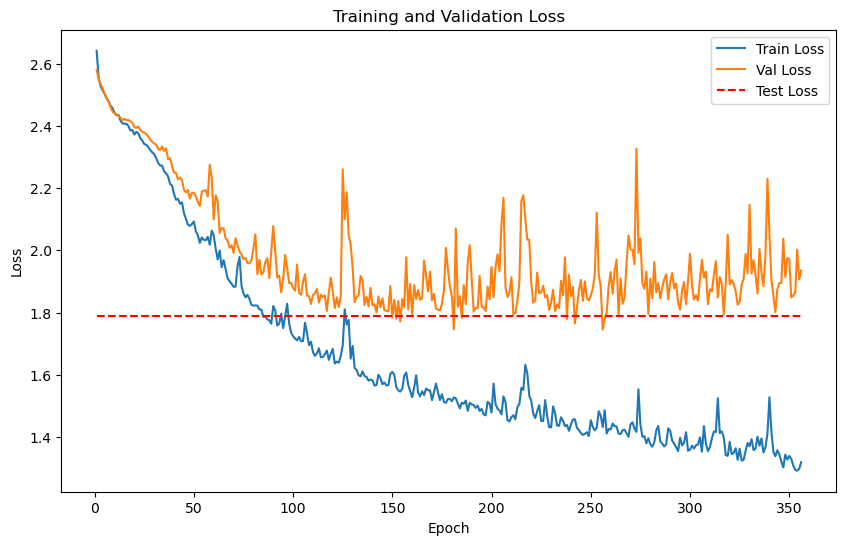

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 520 samples with 64 features each
LOG: Labels shape: (520,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4626 samples with 64 features each
LOG: Labels shape: (4626,)


Train embeddings shape: (520, 64), 
Train labels shape: (520,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (4626, 64), 
Test labels shape: (4626,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}
Training batch size: 260


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/2], Train Loss: 8.4361
    Batch [2/2], Train Loss: 8.2378
Epoch [1/2000], Avg Train Loss: 8.3370
Epoch [1/2000], Avg Val Loss: 5.7213
Validation loss improved from inf to 5.7213. Saving model...

LOG: Epoch [2/2000] - Training


    Batch [1/2], Train Loss: 8.3792
    Batch [2/2], Train Loss: 8.0473
Epoch [2/2000], Avg Train Loss: 8.2133
Epoch [2/2000], Avg Val Loss: 5.6626
Validation loss improved from 5.7213 to 5.6626. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 8.1396
    Batch [2/2], Train Loss: 8.0948
Epoch [3/2000], Avg Train Loss: 8.1172
Epoch [3/2000], Avg Val Loss: 5.6037
Validation loss improved from 5.6626 to 5.6037. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 8.0321
    Batch [2/2], Train Loss: 7.8471
Epoch [4/2000], Avg Train Loss: 7.9396
Epoch [4/2000], Avg Val Loss: 5.5447
Validation loss improved from 5.6037 to 5.5447. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss: 7.7961
    Batch [2/2], Train Loss: 7.8772
Epoch [5/2000], Avg Train Loss: 7.8367
Epoch [5/2000], Avg Val Loss: 5.4855
Validation loss improved from 5.5447 to 5.4855. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/2], Train L

    Batch [2/2], Train Loss: 7.4690
Epoch [9/2000], Avg Train Loss: 7.4595


Epoch [9/2000], Avg Val Loss: 5.2503
Validation loss improved from 5.3099 to 5.2503. Saving model...

LOG: Epoch [10/2000] - Training
    Batch [1/2], Train Loss: 7.4215
    Batch [2/2], Train Loss: 7.1854
Epoch [10/2000], Avg Train Loss: 7.3035
Epoch [10/2000], Avg Val Loss: 5.1904
Validation loss improved from 5.2503 to 5.1904. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 7.1328
    Batch [2/2], Train Loss: 7.2562
Epoch [11/2000], Avg Train Loss: 7.1945
Epoch [11/2000], Avg Val Loss: 5.1308
Validation loss improved from 5.1904 to 5.1308. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 7.2469
    Batch [2/2], Train Loss: 7.0905
Epoch [12/2000], Avg Train Loss: 7.1687
Epoch [12/2000], Avg Val Loss: 5.0712
Validation loss improved from 5.1308 to 5.0712. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 7.1582
    Batch [2/2], Train Loss: 7.0976
Epoch [13/2000], Avg Train Loss: 7.1279


Epoch [13/2000], Avg Val Loss: 5.0126
Validation loss improved from 5.0712 to 5.0126. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 6.9369
    Batch [2/2], Train Loss: 7.0256
Epoch [14/2000], Avg Train Loss: 6.9813
Epoch [14/2000], Avg Val Loss: 4.9556
Validation loss improved from 5.0126 to 4.9556. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 6.8874
    Batch [2/2], Train Loss: 6.8888
Epoch [15/2000], Avg Train Loss: 6.8881
Epoch [15/2000], Avg Val Loss: 4.8997
Validation loss improved from 4.9556 to 4.8997. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/2], Train Loss: 6.7974
    Batch [2/2], Train Loss: 6.7307
Epoch [16/2000], Avg Train Loss: 6.7641
Epoch [16/2000], Avg Val Loss: 4.8459
Validation loss improved from 4.8997 to 4.8459. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/2], Train Loss: 6.9423
    Batch [2/2], Train Loss: 6.6946
Epoch [17/2000], Avg Train Loss: 6.8185
Epoch [17/20

    Batch [2/2], Train Loss: 6.3455
Epoch [24/2000], Avg Train Loss: 6.4197
Epoch [24/2000], Avg Val Loss: 4.4786
Validation loss improved from 4.5167 to 4.4786. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/2], Train Loss: 6.2986
    Batch [2/2], Train Loss: 6.2501
Epoch [25/2000], Avg Train Loss: 6.2743
Epoch [25/2000], Avg Val Loss: 4.4426
Validation loss improved from 4.4786 to 4.4426. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/2], Train Loss: 6.3990
    Batch [2/2], Train Loss: 6.2926
Epoch [26/2000], Avg Train Loss: 6.3458
Epoch [26/2000], Avg Val Loss: 4.4087
Validation loss improved from 4.4426 to 4.4087. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/2], Train Loss: 6.2579
    Batch [2/2], Train Loss: 6.3281
Epoch [27/2000], Avg Train Loss: 6.2930
Epoch [27/2000], Avg Val Loss: 4.3769
Validation loss improved from 4.4087 to 4.3769. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/2], Train Loss: 6.2026
    Batch [2

    Batch [2/2], Train Loss: 6.0555
Epoch [31/2000], Avg Train Loss: 6.0781
Epoch [31/2000], Avg Val Loss: 4.2688
Validation loss improved from 4.2929 to 4.2688. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/2], Train Loss: 6.0912
    Batch [2/2], Train Loss: 6.0533
Epoch [32/2000], Avg Train Loss: 6.0723
Epoch [32/2000], Avg Val Loss: 4.2460
Validation loss improved from 4.2688 to 4.2460. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/2], Train Loss: 6.0853
    Batch [2/2], Train Loss: 5.9951
Epoch [33/2000], Avg Train Loss: 6.0402
Epoch [33/2000], Avg Val Loss: 4.2249
Validation loss improved from 4.2460 to 4.2249. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 6.0113
    Batch [2/2], Train Loss: 5.9881
Epoch [34/2000], Avg Train Loss: 5.9997
Epoch [34/2000], Avg Val Loss: 4.2053
Validation loss improved from 4.2249 to 4.2053. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 5.9582
    Batch [2

    Batch [2/2], Train Loss: 5.7880
Epoch [44/2000], Avg Train Loss: 5.7778
Epoch [44/2000], Avg Val Loss: 4.0638
Validation loss improved from 4.0747 to 4.0638. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/2], Train Loss: 5.7326
    Batch [2/2], Train Loss: 5.7896
Epoch [45/2000], Avg Train Loss: 5.7611
Epoch [45/2000], Avg Val Loss: 4.0533
Validation loss improved from 4.0638 to 4.0533. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/2], Train Loss: 5.8044
    Batch [2/2], Train Loss: 5.7915
Epoch [46/2000], Avg Train Loss: 5.7980
Epoch [46/2000], Avg Val Loss: 4.0432
Validation loss improved from 4.0533 to 4.0432. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/2], Train Loss: 5.7908
    Batch [2/2], Train Loss: 5.7082
Epoch [47/2000], Avg Train Loss: 5.7495
Epoch [47/2000], Avg Val Loss: 4.0336
Validation loss improved from 4.0432 to 4.0336. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/2], Train Loss: 5.7212
    Batch [2

    Batch [1/2], Train Loss: 5.7272
    Batch [2/2], Train Loss: 5.7117
Epoch [52/2000], Avg Train Loss: 5.7194
Epoch [52/2000], Avg Val Loss: 3.9901
Validation loss improved from 3.9982 to 3.9901. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 5.6997
    Batch [2/2], Train Loss: 5.6716
Epoch [53/2000], Avg Train Loss: 5.6857
Epoch [53/2000], Avg Val Loss: 3.9823
Validation loss improved from 3.9901 to 3.9823. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/2], Train Loss: 5.6662
    Batch [2/2], Train Loss: 5.6544
Epoch [54/2000], Avg Train Loss: 5.6603
Epoch [54/2000], Avg Val Loss: 3.9747
Validation loss improved from 3.9823 to 3.9747. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 5.6773
    Batch [2/2], Train Loss: 5.6550
Epoch [55/2000], Avg Train Loss: 5.6661
Epoch [55/2000], Avg Val Loss: 3.9673
Validation loss improved from 3.9747 to 3.9673. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 5.5567
    Batch [2/2], Train Loss: 5.5408
Epoch [67/2000], Avg Train Loss: 5.5487
Epoch [67/2000], Avg Val Loss: 3.8815
Validation loss improved from 3.8884 to 3.8815. Saving model...

LOG: Epoch [68/2000] - Training
    Batch [1/2], Train Loss: 5.5655
    Batch [2/2], Train Loss: 5.5225
Epoch [68/2000], Avg Train Loss: 5.5440
Epoch [68/2000], Avg Val Loss: 3.8749
Validation loss improved from 3.8815 to 3.8749. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 5.5336
    Batch [2/2], Train Loss: 5.4964
Epoch [69/2000], Avg Train Loss: 5.5150
Epoch [69/2000], Avg Val Loss: 3.8685
Validation loss improved from 3.8749 to 3.8685. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/2], Train Loss: 5.5186
    Batch [2/2], Train Loss: 5.5110
Epoch [70/2000], Avg Train Loss: 5.5148
Epoch [70/2000], Avg Val Loss: 3.8624
Validation loss improved from 3.8685 to 3.8624. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 5.4847
Epoch [73/2000], Avg Train Loss: 5.4764
Epoch [73/2000], Avg Val Loss: 3.8449
Validation loss improved from 3.8506 to 3.8449. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/2], Train Loss: 5.5055
    Batch [2/2], Train Loss: 5.5034
Epoch [74/2000], Avg Train Loss: 5.5044
Epoch [74/2000], Avg Val Loss: 3.8394
Validation loss improved from 3.8449 to 3.8394. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 5.4353
    Batch [2/2], Train Loss: 5.4638
Epoch [75/2000], Avg Train Loss: 5.4495
Epoch [75/2000], Avg Val Loss: 3.8338
Validation loss improved from 3.8394 to 3.8338. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/2], Train Loss: 5.4851
    Batch [2/2], Train Loss: 5.4687
Epoch [76/2000], Avg Train Loss: 5.4769
Epoch [76/2000], Avg Val Loss: 3.8282
Validation loss improved from 3.8338 to 3.8282. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 5.5077
    Batch [2

    Batch [2/2], Train Loss: 5.3532
Epoch [88/2000], Avg Train Loss: 5.3646
Epoch [88/2000], Avg Val Loss: 3.7671
Validation loss improved from 3.7718 to 3.7671. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/2], Train Loss: 5.3945
    Batch [2/2], Train Loss: 5.3773
Epoch [89/2000], Avg Train Loss: 5.3859
Epoch [89/2000], Avg Val Loss: 3.7627
Validation loss improved from 3.7671 to 3.7627. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/2], Train Loss: 5.3655
    Batch [2/2], Train Loss: 5.3918
Epoch [90/2000], Avg Train Loss: 5.3786
Epoch [90/2000], Avg Val Loss: 3.7584
Validation loss improved from 3.7627 to 3.7584. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/2], Train Loss: 5.3797
    Batch [2/2], Train Loss: 5.3219
Epoch [91/2000], Avg Train Loss: 5.3508
Epoch [91/2000], Avg Val Loss: 3.7542
Validation loss improved from 3.7584 to 3.7542. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/2], Train Loss: 5.3809
    Batch [2

    Batch [1/2], Train Loss: 5.3407
    Batch [2/2], Train Loss: 5.3362
Epoch [96/2000], Avg Train Loss: 5.3384
Epoch [96/2000], Avg Val Loss: 3.7349
Validation loss improved from 3.7385 to 3.7349. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/2], Train Loss: 5.3132
    Batch [2/2], Train Loss: 5.3382
Epoch [97/2000], Avg Train Loss: 5.3257
Epoch [97/2000], Avg Val Loss: 3.7313
Validation loss improved from 3.7349 to 3.7313. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/2], Train Loss: 5.3119
    Batch [2/2], Train Loss: 5.3736
Epoch [98/2000], Avg Train Loss: 5.3427
Epoch [98/2000], Avg Val Loss: 3.7279
Validation loss improved from 3.7313 to 3.7279. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/2], Train Loss: 5.3311
    Batch [2/2], Train Loss: 5.2887
Epoch [99/2000], Avg Train Loss: 5.3099
Epoch [99/2000], Avg Val Loss: 3.7246
Validation loss improved from 3.7279 to 3.7246. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [

Epoch [109/2000], Avg Val Loss: 3.6982
Validation loss improved from 3.7006 to 3.6982. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/2], Train Loss: 5.2808
    Batch [2/2], Train Loss: 5.3003
Epoch [110/2000], Avg Train Loss: 5.2906
Epoch [110/2000], Avg Val Loss: 3.6960
Validation loss improved from 3.6982 to 3.6960. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/2], Train Loss: 5.2945
    Batch [2/2], Train Loss: 5.2336
Epoch [111/2000], Avg Train Loss: 5.2640
Epoch [111/2000], Avg Val Loss: 3.6938
Validation loss improved from 3.6960 to 3.6938. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/2], Train Loss: 5.2966
    Batch [2/2], Train Loss: 5.2561
Epoch [112/2000], Avg Train Loss: 5.2763
Epoch [112/2000], Avg Val Loss: 3.6918
Validation loss improved from 3.6938 to 3.6918. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/2], Train Loss: 5.2649
    Batch [2/2], Train Loss: 5.2849
Epoch [113/2000], Avg Train Loss: 5.2749


    Batch [1/2], Train Loss: 5.2189
    Batch [2/2], Train Loss: 5.2948
Epoch [118/2000], Avg Train Loss: 5.2569
Epoch [118/2000], Avg Val Loss: 3.6797
Validation loss improved from 3.6818 to 3.6797. Saving model...

LOG: Epoch [119/2000] - Training
    Batch [1/2], Train Loss: 5.2347
    Batch [2/2], Train Loss: 5.2894
Epoch [119/2000], Avg Train Loss: 5.2620
Epoch [119/2000], Avg Val Loss: 3.6776
Validation loss improved from 3.6797 to 3.6776. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/2], Train Loss: 5.2316
    Batch [2/2], Train Loss: 5.2626
Epoch [120/2000], Avg Train Loss: 5.2471
Epoch [120/2000], Avg Val Loss: 3.6754
Validation loss improved from 3.6776 to 3.6754. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 5.2139
    Batch [2/2], Train Loss: 5.2581
Epoch [121/2000], Avg Train Loss: 5.2360
Epoch [121/2000], Avg Val Loss: 3.6733
Validation loss improved from 3.6754 to 3.6733. Saving model...

LOG: Epoch [122/2000] - Training


    Batch [2/2], Train Loss: 5.2067
Epoch [132/2000], Avg Train Loss: 5.2286
Epoch [132/2000], Avg Val Loss: 3.6534
Validation loss improved from 3.6550 to 3.6534. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/2], Train Loss: 5.2067
    Batch [2/2], Train Loss: 5.2441
Epoch [133/2000], Avg Train Loss: 5.2254
Epoch [133/2000], Avg Val Loss: 3.6519
Validation loss improved from 3.6534 to 3.6519. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/2], Train Loss: 5.2101
    Batch [2/2], Train Loss: 5.1404
Epoch [134/2000], Avg Train Loss: 5.1752
Epoch [134/2000], Avg Val Loss: 3.6505
Validation loss improved from 3.6519 to 3.6505. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 5.1856
    Batch [2/2], Train Loss: 5.1604
Epoch [135/2000], Avg Train Loss: 5.1730
Epoch [135/2000], Avg Val Loss: 3.6491
Validation loss improved from 3.6505 to 3.6491. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/2], Train Loss: 5.1856


    Batch [2/2], Train Loss: 5.1845
Epoch [142/2000], Avg Train Loss: 5.1695
Epoch [142/2000], Avg Val Loss: 3.6390
Validation loss improved from 3.6405 to 3.6390. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 5.1813
    Batch [2/2], Train Loss: 5.1437
Epoch [143/2000], Avg Train Loss: 5.1625
Epoch [143/2000], Avg Val Loss: 3.6372
Validation loss improved from 3.6390 to 3.6372. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/2], Train Loss: 5.2137
    Batch [2/2], Train Loss: 5.1642
Epoch [144/2000], Avg Train Loss: 5.1889
Epoch [144/2000], Avg Val Loss: 3.6353
Validation loss improved from 3.6372 to 3.6353. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/2], Train Loss: 5.1455
    Batch [2/2], Train Loss: 5.1387
Epoch [145/2000], Avg Train Loss: 5.1421
Epoch [145/2000], Avg Val Loss: 3.6332
Validation loss improved from 3.6353 to 3.6332. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/2], Train Loss: 5.1286


    Batch [1/2], Train Loss: 5.1524
    Batch [2/2], Train Loss: 5.1283
Epoch [155/2000], Avg Train Loss: 5.1403
Epoch [155/2000], Avg Val Loss: 3.6110
Validation loss improved from 3.6133 to 3.6110. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/2], Train Loss: 5.1810
    Batch [2/2], Train Loss: 5.1154
Epoch [156/2000], Avg Train Loss: 5.1482
Epoch [156/2000], Avg Val Loss: 3.6091
Validation loss improved from 3.6110 to 3.6091. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 5.0769
    Batch [2/2], Train Loss: 5.1299
Epoch [157/2000], Avg Train Loss: 5.1034
Epoch [157/2000], Avg Val Loss: 3.6072
Validation loss improved from 3.6091 to 3.6072. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 5.1137
    Batch [2/2], Train Loss: 5.1498
Epoch [158/2000], Avg Train Loss: 5.1317
Epoch [158/2000], Avg Val Loss: 3.6051
Validation loss improved from 3.6072 to 3.6051. Saving model...

LOG: Epoch [159/2000] - Training


    Batch [1/2], Train Loss: 5.1179
    Batch [2/2], Train Loss: 5.1294
Epoch [165/2000], Avg Train Loss: 5.1236
Epoch [165/2000], Avg Val Loss: 3.5922
Validation loss improved from 3.5942 to 3.5922. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 5.1230
    Batch [2/2], Train Loss: 5.1477
Epoch [166/2000], Avg Train Loss: 5.1353
Epoch [166/2000], Avg Val Loss: 3.5903
Validation loss improved from 3.5922 to 3.5903. Saving model...

LOG: Epoch [167/2000] - Training
    Batch [1/2], Train Loss: 5.1105
    Batch [2/2], Train Loss: 5.0592
Epoch [167/2000], Avg Train Loss: 5.0848
Epoch [167/2000], Avg Val Loss: 3.5885
Validation loss improved from 3.5903 to 3.5885. Saving model...

LOG: Epoch [168/2000] - Training
    Batch [1/2], Train Loss: 5.0814
    Batch [2/2], Train Loss: 5.1870
Epoch [168/2000], Avg Train Loss: 5.1342
Epoch [168/2000], Avg Val Loss: 3.5865
Validation loss improved from 3.5885 to 3.5865. Saving model...

LOG: Epoch [169/2000] - Training


    Batch [2/2], Train Loss: 5.0344
Epoch [180/2000], Avg Train Loss: 5.0263
Epoch [180/2000], Avg Val Loss: 3.5657
Validation loss improved from 3.5672 to 3.5657. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/2], Train Loss: 5.0571
    Batch [2/2], Train Loss: 5.0745
Epoch [181/2000], Avg Train Loss: 5.0658
Epoch [181/2000], Avg Val Loss: 3.5641
Validation loss improved from 3.5657 to 3.5641. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/2], Train Loss: 5.0635
    Batch [2/2], Train Loss: 5.0445
Epoch [182/2000], Avg Train Loss: 5.0540
Epoch [182/2000], Avg Val Loss: 3.5625
Validation loss improved from 3.5641 to 3.5625. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/2], Train Loss: 5.0599
    Batch [2/2], Train Loss: 5.0658
Epoch [183/2000], Avg Train Loss: 5.0629
Epoch [183/2000], Avg Val Loss: 3.5607
Validation loss improved from 3.5625 to 3.5607. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/2], Train Loss: 5.0696


    Batch [2/2], Train Loss: 5.0312
Epoch [187/2000], Avg Train Loss: 5.0668
Epoch [187/2000], Avg Val Loss: 3.5539
Validation loss improved from 3.5553 to 3.5539. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/2], Train Loss: 5.0147
    Batch [2/2], Train Loss: 5.0394
Epoch [188/2000], Avg Train Loss: 5.0270
Epoch [188/2000], Avg Val Loss: 3.5525
Validation loss improved from 3.5539 to 3.5525. Saving model...

LOG: Epoch [189/2000] - Training
    Batch [1/2], Train Loss: 5.0733
    Batch [2/2], Train Loss: 5.0678
Epoch [189/2000], Avg Train Loss: 5.0706
Epoch [189/2000], Avg Val Loss: 3.5512
Validation loss improved from 3.5525 to 3.5512. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/2], Train Loss: 5.0497
    Batch [2/2], Train Loss: 5.0507
Epoch [190/2000], Avg Train Loss: 5.0502
Epoch [190/2000], Avg Val Loss: 3.5499
Validation loss improved from 3.5512 to 3.5499. Saving model...

LOG: Epoch [191/2000] - Training
    Batch [1/2], Train Loss: 5.0911


    Batch [2/2], Train Loss: 4.9593
Epoch [202/2000], Avg Train Loss: 4.9973
Epoch [202/2000], Avg Val Loss: 3.5302
Validation loss improved from 3.5317 to 3.5302. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/2], Train Loss: 5.0573
    Batch [2/2], Train Loss: 5.0257
Epoch [203/2000], Avg Train Loss: 5.0415
Epoch [203/2000], Avg Val Loss: 3.5289
Validation loss improved from 3.5302 to 3.5289. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/2], Train Loss: 5.0581
    Batch [2/2], Train Loss: 5.0406
Epoch [204/2000], Avg Train Loss: 5.0493
Epoch [204/2000], Avg Val Loss: 3.5278
Validation loss improved from 3.5289 to 3.5278. Saving model...

LOG: Epoch [205/2000] - Training
    Batch [1/2], Train Loss: 5.0079
    Batch [2/2], Train Loss: 5.0364
Epoch [205/2000], Avg Train Loss: 5.0222
Epoch [205/2000], Avg Val Loss: 3.5267
Validation loss improved from 3.5278 to 3.5267. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/2], Train Loss: 5.0131


    Batch [1/2], Train Loss: 4.9941
    Batch [2/2], Train Loss: 5.0340
Epoch [211/2000], Avg Train Loss: 5.0140
Epoch [211/2000], Avg Val Loss: 3.5195
Validation loss improved from 3.5205 to 3.5195. Saving model...

LOG: Epoch [212/2000] - Training
    Batch [1/2], Train Loss: 4.9709
    Batch [2/2], Train Loss: 4.9594
Epoch [212/2000], Avg Train Loss: 4.9652
Epoch [212/2000], Avg Val Loss: 3.5184
Validation loss improved from 3.5195 to 3.5184. Saving model...

LOG: Epoch [213/2000] - Training
    Batch [1/2], Train Loss: 4.9934
    Batch [2/2], Train Loss: 5.0162
Epoch [213/2000], Avg Train Loss: 5.0048
Epoch [213/2000], Avg Val Loss: 3.5173
Validation loss improved from 3.5184 to 3.5173. Saving model...

LOG: Epoch [214/2000] - Training
    Batch [1/2], Train Loss: 4.9937
    Batch [2/2], Train Loss: 4.9555
Epoch [214/2000], Avg Train Loss: 4.9746
Epoch [214/2000], Avg Val Loss: 3.5163
Validation loss improved from 3.5173 to 3.5163. Saving model...

LOG: Epoch [215/2000] - Training


    Batch [2/2], Train Loss: 4.9727
Epoch [221/2000], Avg Train Loss: 4.9631
Epoch [221/2000], Avg Val Loss: 3.5066
Validation loss improved from 3.5085 to 3.5066. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/2], Train Loss: 4.9485
    Batch [2/2], Train Loss: 4.9475
Epoch [222/2000], Avg Train Loss: 4.9480
Epoch [222/2000], Avg Val Loss: 3.5049
Validation loss improved from 3.5066 to 3.5049. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/2], Train Loss: 4.9012
    Batch [2/2], Train Loss: 4.9452
Epoch [223/2000], Avg Train Loss: 4.9232
Epoch [223/2000], Avg Val Loss: 3.5034
Validation loss improved from 3.5049 to 3.5034. Saving model...

LOG: Epoch [224/2000] - Training
    Batch [1/2], Train Loss: 4.9362
    Batch [2/2], Train Loss: 4.9808
Epoch [224/2000], Avg Train Loss: 4.9585
Epoch [224/2000], Avg Val Loss: 3.5021
Validation loss improved from 3.5034 to 3.5021. Saving model...

LOG: Epoch [225/2000] - Training
    Batch [1/2], Train Loss: 4.9956


Epoch [229/2000], Avg Val Loss: 3.4959
Validation loss improved from 3.4971 to 3.4959. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 4.9031
    Batch [2/2], Train Loss: 4.9545
Epoch [230/2000], Avg Train Loss: 4.9288
Epoch [230/2000], Avg Val Loss: 3.4950
Validation loss improved from 3.4959 to 3.4950. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/2], Train Loss: 4.9380
    Batch [2/2], Train Loss: 4.9197
Epoch [231/2000], Avg Train Loss: 4.9289
Epoch [231/2000], Avg Val Loss: 3.4937
Validation loss improved from 3.4950 to 3.4937. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/2], Train Loss: 4.9764
    Batch [2/2], Train Loss: 4.9622
Epoch [232/2000], Avg Train Loss: 4.9693
Epoch [232/2000], Avg Val Loss: 3.4926
Validation loss improved from 3.4937 to 3.4926. Saving model...

LOG: Epoch [233/2000] - Training
    Batch [1/2], Train Loss: 4.9848
    Batch [2/2], Train Loss: 4.9962
Epoch [233/2000], Avg Train Loss: 4.9905


    Batch [2/2], Train Loss: 4.8589
Epoch [239/2000], Avg Train Loss: 4.9080
Epoch [239/2000], Avg Val Loss: 3.4858
Validation loss improved from 3.4866 to 3.4858. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/2], Train Loss: 5.0092
    Batch [2/2], Train Loss: 4.9361
Epoch [240/2000], Avg Train Loss: 4.9727
Epoch [240/2000], Avg Val Loss: 3.4845
Validation loss improved from 3.4858 to 3.4845. Saving model...

LOG: Epoch [241/2000] - Training
    Batch [1/2], Train Loss: 4.9307
    Batch [2/2], Train Loss: 4.9172
Epoch [241/2000], Avg Train Loss: 4.9240
Epoch [241/2000], Avg Val Loss: 3.4830
Validation loss improved from 3.4845 to 3.4830. Saving model...

LOG: Epoch [242/2000] - Training
    Batch [1/2], Train Loss: 4.9135
    Batch [2/2], Train Loss: 4.9733
Epoch [242/2000], Avg Train Loss: 4.9434
Epoch [242/2000], Avg Val Loss: 3.4813
Validation loss improved from 3.4830 to 3.4813. Saving model...

LOG: Epoch [243/2000] - Training
    Batch [1/2], Train Loss: 4.9416


Epoch [251/2000], Avg Val Loss: 3.4697
Validation loss improved from 3.4706 to 3.4697. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/2], Train Loss: 4.9140
    Batch [2/2], Train Loss: 4.8427
Epoch [252/2000], Avg Train Loss: 4.8784
Epoch [252/2000], Avg Val Loss: 3.4689
Validation loss improved from 3.4697 to 3.4689. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/2], Train Loss: 4.8515
    Batch [2/2], Train Loss: 4.9137
Epoch [253/2000], Avg Train Loss: 4.8826
Epoch [253/2000], Avg Val Loss: 3.4681
Validation loss improved from 3.4689 to 3.4681. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/2], Train Loss: 4.8944
    Batch [2/2], Train Loss: 4.9171
Epoch [254/2000], Avg Train Loss: 4.9057
Epoch [254/2000], Avg Val Loss: 3.4669
Validation loss improved from 3.4681 to 3.4669. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/2], Train Loss: 4.9323
    Batch [2/2], Train Loss: 4.8678
Epoch [255/2000], Avg Train Loss: 4.9001


    Batch [1/2], Train Loss: 4.8652
    Batch [2/2], Train Loss: 4.9058
Epoch [262/2000], Avg Train Loss: 4.8855
Epoch [262/2000], Avg Val Loss: 3.4563
Validation loss improved from 3.4574 to 3.4563. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/2], Train Loss: 4.8833
    Batch [2/2], Train Loss: 4.9128
Epoch [263/2000], Avg Train Loss: 4.8980
Epoch [263/2000], Avg Val Loss: 3.4549
Validation loss improved from 3.4563 to 3.4549. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/2], Train Loss: 4.8332
    Batch [2/2], Train Loss: 4.9228
Epoch [264/2000], Avg Train Loss: 4.8780
Epoch [264/2000], Avg Val Loss: 3.4542
Validation loss improved from 3.4549 to 3.4542. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/2], Train Loss: 4.8935
    Batch [2/2], Train Loss: 4.8724
Epoch [265/2000], Avg Train Loss: 4.8830
Epoch [265/2000], Avg Val Loss: 3.4533
Validation loss improved from 3.4542 to 3.4533. Saving model...

LOG: Epoch [266/2000] - Training


    Batch [1/2], Train Loss: 4.8679
    Batch [2/2], Train Loss: 4.8878
Epoch [273/2000], Avg Train Loss: 4.8779
Epoch [273/2000], Avg Val Loss: 3.4429
Validation loss improved from 3.4435 to 3.4429. Saving model...

LOG: Epoch [274/2000] - Training
    Batch [1/2], Train Loss: 4.8563
    Batch [2/2], Train Loss: 4.8366
Epoch [274/2000], Avg Train Loss: 4.8465
Epoch [274/2000], Avg Val Loss: 3.4429
Validation loss improved from 3.4429 to 3.4429. Saving model...

LOG: Epoch [275/2000] - Training
    Batch [1/2], Train Loss: 4.8674
    Batch [2/2], Train Loss: 4.8910
Epoch [275/2000], Avg Train Loss: 4.8792
Epoch [275/2000], Avg Val Loss: 3.4431
Validation loss did not improve. Patience: 1/100

LOG: Epoch [276/2000] - Training
    Batch [1/2], Train Loss: 4.8985
    Batch [2/2], Train Loss: 4.8704
Epoch [276/2000], Avg Train Loss: 4.8845
Epoch [276/2000], Avg Val Loss: 3.4431
Validation loss did not improve. Patience: 2/100

LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 4

    Batch [2/2], Train Loss: 4.8354
Epoch [283/2000], Avg Train Loss: 4.8715
Epoch [283/2000], Avg Val Loss: 3.4433
Validation loss did not improve. Patience: 9/100

LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 4.8350
    Batch [2/2], Train Loss: 4.9056
Epoch [284/2000], Avg Train Loss: 4.8703
Epoch [284/2000], Avg Val Loss: 3.4431
Validation loss did not improve. Patience: 10/100

LOG: Epoch [285/2000] - Training
    Batch [1/2], Train Loss: 4.8031
    Batch [2/2], Train Loss: 4.8132
Epoch [285/2000], Avg Train Loss: 4.8081
Epoch [285/2000], Avg Val Loss: 3.4432
Validation loss did not improve. Patience: 11/100

LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 4.9225
    Batch [2/2], Train Loss: 4.8758
Epoch [286/2000], Avg Train Loss: 4.8992
Epoch [286/2000], Avg Val Loss: 3.4428
Validation loss improved from 3.4429 to 3.4428. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/2], Train Loss: 4.8672
    Batch [2/2], Train Loss: 4.8860
Epoch [

    Batch [1/2], Train Loss: 4.8469
    Batch [2/2], Train Loss: 4.8887
Epoch [297/2000], Avg Train Loss: 4.8678
Epoch [297/2000], Avg Val Loss: 3.4342
Validation loss improved from 3.4348 to 3.4342. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/2], Train Loss: 4.8337
    Batch [2/2], Train Loss: 4.8215
Epoch [298/2000], Avg Train Loss: 4.8276
Epoch [298/2000], Avg Val Loss: 3.4333
Validation loss improved from 3.4342 to 3.4333. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/2], Train Loss: 4.8932
    Batch [2/2], Train Loss: 4.8347
Epoch [299/2000], Avg Train Loss: 4.8639
Epoch [299/2000], Avg Val Loss: 3.4324
Validation loss improved from 3.4333 to 3.4324. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/2], Train Loss: 4.7917
    Batch [2/2], Train Loss: 4.8788
Epoch [300/2000], Avg Train Loss: 4.8353
Epoch [300/2000], Avg Val Loss: 3.4317
Validation loss improved from 3.4324 to 3.4317. Saving model...

LOG: Epoch [301/2000] - Training


    Batch [1/2], Train Loss: 4.8292
    Batch [2/2], Train Loss: 4.8049
Epoch [306/2000], Avg Train Loss: 4.8170
Epoch [306/2000], Avg Val Loss: 3.4273
Validation loss improved from 3.4289 to 3.4273. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/2], Train Loss: 4.8348
    Batch [2/2], Train Loss: 4.8148
Epoch [307/2000], Avg Train Loss: 4.8248
Epoch [307/2000], Avg Val Loss: 3.4255
Validation loss improved from 3.4273 to 3.4255. Saving model...

LOG: Epoch [308/2000] - Training
    Batch [1/2], Train Loss: 4.8496
    Batch [2/2], Train Loss: 4.7890
Epoch [308/2000], Avg Train Loss: 4.8193
Epoch [308/2000], Avg Val Loss: 3.4237
Validation loss improved from 3.4255 to 3.4237. Saving model...

LOG: Epoch [309/2000] - Training
    Batch [1/2], Train Loss: 4.8683
    Batch [2/2], Train Loss: 4.8721
Epoch [309/2000], Avg Train Loss: 4.8702
Epoch [309/2000], Avg Val Loss: 3.4221
Validation loss improved from 3.4237 to 3.4221. Saving model...

LOG: Epoch [310/2000] - Training


    Batch [2/2], Train Loss: 4.7953
Epoch [318/2000], Avg Train Loss: 4.8075
Epoch [318/2000], Avg Val Loss: 3.4101
Validation loss improved from 3.4107 to 3.4101. Saving model...

LOG: Epoch [319/2000] - Training
    Batch [1/2], Train Loss: 4.8262
    Batch [2/2], Train Loss: 4.8113
Epoch [319/2000], Avg Train Loss: 4.8187
Epoch [319/2000], Avg Val Loss: 3.4096
Validation loss improved from 3.4101 to 3.4096. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/2], Train Loss: 4.8057
    Batch [2/2], Train Loss: 4.8636
Epoch [320/2000], Avg Train Loss: 4.8346
Epoch [320/2000], Avg Val Loss: 3.4098
Validation loss did not improve. Patience: 1/100

LOG: Epoch [321/2000] - Training
    Batch [1/2], Train Loss: 4.7776
    Batch [2/2], Train Loss: 4.8370
Epoch [321/2000], Avg Train Loss: 4.8073
Epoch [321/2000], Avg Val Loss: 3.4102
Validation loss did not improve. Patience: 2/100

LOG: Epoch [322/2000] - Training
    Batch [1/2], Train Loss: 4.7828
    Batch [2/2], Train Loss: 4

    Batch [2/2], Train Loss: 4.8067
Epoch [327/2000], Avg Train Loss: 4.7715
Epoch [327/2000], Avg Val Loss: 3.4057
Validation loss improved from 3.4067 to 3.4057. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/2], Train Loss: 4.8037
    Batch [2/2], Train Loss: 4.7800
Epoch [328/2000], Avg Train Loss: 4.7919
Epoch [328/2000], Avg Val Loss: 3.4049
Validation loss improved from 3.4057 to 3.4049. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/2], Train Loss: 4.8325
    Batch [2/2], Train Loss: 4.8109
Epoch [329/2000], Avg Train Loss: 4.8217
Epoch [329/2000], Avg Val Loss: 3.4042
Validation loss improved from 3.4049 to 3.4042. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/2], Train Loss: 4.8544
    Batch [2/2], Train Loss: 4.7988
Epoch [330/2000], Avg Train Loss: 4.8266
Epoch [330/2000], Avg Val Loss: 3.4043
Validation loss did not improve. Patience: 1/100

LOG: Epoch [331/2000] - Training
    Batch [1/2], Train Loss: 4.8260
    Batch [2/2]

    Batch [2/2], Train Loss: 4.8053
Epoch [341/2000], Avg Train Loss: 4.7984
Epoch [341/2000], Avg Val Loss: 3.3954
Validation loss improved from 3.3971 to 3.3954. Saving model...

LOG: Epoch [342/2000] - Training
    Batch [1/2], Train Loss: 4.8199
    Batch [2/2], Train Loss: 4.7669
Epoch [342/2000], Avg Train Loss: 4.7934
Epoch [342/2000], Avg Val Loss: 3.3937
Validation loss improved from 3.3954 to 3.3937. Saving model...

LOG: Epoch [343/2000] - Training
    Batch [1/2], Train Loss: 4.7746
    Batch [2/2], Train Loss: 4.8147
Epoch [343/2000], Avg Train Loss: 4.7947
Epoch [343/2000], Avg Val Loss: 3.3922
Validation loss improved from 3.3937 to 3.3922. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 4.7464
    Batch [2/2], Train Loss: 4.7353
Epoch [344/2000], Avg Train Loss: 4.7409
Epoch [344/2000], Avg Val Loss: 3.3915
Validation loss improved from 3.3922 to 3.3915. Saving model...

LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 4.8339


    Batch [1/2], Train Loss: 4.8121
    Batch [2/2], Train Loss: 4.7584
Epoch [349/2000], Avg Train Loss: 4.7852
Epoch [349/2000], Avg Val Loss: 3.3920
Validation loss did not improve. Patience: 4/100

LOG: Epoch [350/2000] - Training
    Batch [1/2], Train Loss: 4.7518
    Batch [2/2], Train Loss: 4.7490
Epoch [350/2000], Avg Train Loss: 4.7504
Epoch [350/2000], Avg Val Loss: 3.3921
Validation loss did not improve. Patience: 5/100

LOG: Epoch [351/2000] - Training
    Batch [1/2], Train Loss: 4.8306
    Batch [2/2], Train Loss: 4.8216
Epoch [351/2000], Avg Train Loss: 4.8261
Epoch [351/2000], Avg Val Loss: 3.3920
Validation loss did not improve. Patience: 6/100

LOG: Epoch [352/2000] - Training
    Batch [1/2], Train Loss: 4.8156
    Batch [2/2], Train Loss: 4.8193
Epoch [352/2000], Avg Train Loss: 4.8175
Epoch [352/2000], Avg Val Loss: 3.3915
Validation loss did not improve. Patience: 7/100

LOG: Epoch [353/2000] - Training
    Batch [1/2], Train Loss: 4.8242
    Batch [2/2], Train L

    Batch [2/2], Train Loss: 4.7460
Epoch [362/2000], Avg Train Loss: 4.7719
Epoch [362/2000], Avg Val Loss: 3.3852
Validation loss improved from 3.3860 to 3.3852. Saving model...

LOG: Epoch [363/2000] - Training
    Batch [1/2], Train Loss: 4.6893
    Batch [2/2], Train Loss: 4.7099
Epoch [363/2000], Avg Train Loss: 4.6996
Epoch [363/2000], Avg Val Loss: 3.3845
Validation loss improved from 3.3852 to 3.3845. Saving model...

LOG: Epoch [364/2000] - Training
    Batch [1/2], Train Loss: 4.7335
    Batch [2/2], Train Loss: 4.7953
Epoch [364/2000], Avg Train Loss: 4.7644
Epoch [364/2000], Avg Val Loss: 3.3833
Validation loss improved from 3.3845 to 3.3833. Saving model...

LOG: Epoch [365/2000] - Training
    Batch [1/2], Train Loss: 4.7410
    Batch [2/2], Train Loss: 4.7400
Epoch [365/2000], Avg Train Loss: 4.7405
Epoch [365/2000], Avg Val Loss: 3.3824
Validation loss improved from 3.3833 to 3.3824. Saving model...

LOG: Epoch [366/2000] - Training
    Batch [1/2], Train Loss: 4.7727


    Batch [1/2], Train Loss: 4.7860
    Batch [2/2], Train Loss: 4.7413
Epoch [372/2000], Avg Train Loss: 4.7637
Epoch [372/2000], Avg Val Loss: 3.3787
Validation loss improved from 3.3792 to 3.3787. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/2], Train Loss: 4.7444
    Batch [2/2], Train Loss: 4.7465
Epoch [373/2000], Avg Train Loss: 4.7454
Epoch [373/2000], Avg Val Loss: 3.3785
Validation loss improved from 3.3787 to 3.3785. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/2], Train Loss: 4.7733
    Batch [2/2], Train Loss: 4.7296
Epoch [374/2000], Avg Train Loss: 4.7515
Epoch [374/2000], Avg Val Loss: 3.3785
Validation loss did not improve. Patience: 1/100

LOG: Epoch [375/2000] - Training
    Batch [1/2], Train Loss: 4.8279
    Batch [2/2], Train Loss: 4.7264
Epoch [375/2000], Avg Train Loss: 4.7772
Epoch [375/2000], Avg Val Loss: 3.3788
Validation loss did not improve. Patience: 2/100

LOG: Epoch [376/2000] - Training
    Batch [1/2], Train Loss: 4

    Batch [2/2], Train Loss: 4.8138
Epoch [385/2000], Avg Train Loss: 4.7494
Epoch [385/2000], Avg Val Loss: 3.3734
Validation loss improved from 3.3741 to 3.3734. Saving model...

LOG: Epoch [386/2000] - Training
    Batch [1/2], Train Loss: 4.7493
    Batch [2/2], Train Loss: 4.7519
Epoch [386/2000], Avg Train Loss: 4.7506
Epoch [386/2000], Avg Val Loss: 3.3727
Validation loss improved from 3.3734 to 3.3727. Saving model...

LOG: Epoch [387/2000] - Training
    Batch [1/2], Train Loss: 4.7739
    Batch [2/2], Train Loss: 4.7806
Epoch [387/2000], Avg Train Loss: 4.7773
Epoch [387/2000], Avg Val Loss: 3.3721
Validation loss improved from 3.3727 to 3.3721. Saving model...

LOG: Epoch [388/2000] - Training
    Batch [1/2], Train Loss: 4.7755
    Batch [2/2], Train Loss: 4.7674
Epoch [388/2000], Avg Train Loss: 4.7715
Epoch [388/2000], Avg Val Loss: 3.3717
Validation loss improved from 3.3721 to 3.3717. Saving model...

LOG: Epoch [389/2000] - Training
    Batch [1/2], Train Loss: 4.7183


Epoch [394/2000], Avg Val Loss: 3.3661
Validation loss improved from 3.3669 to 3.3661. Saving model...

LOG: Epoch [395/2000] - Training
    Batch [1/2], Train Loss: 4.6779
    Batch [2/2], Train Loss: 4.7928
Epoch [395/2000], Avg Train Loss: 4.7353
Epoch [395/2000], Avg Val Loss: 3.3654
Validation loss improved from 3.3661 to 3.3654. Saving model...

LOG: Epoch [396/2000] - Training
    Batch [1/2], Train Loss: 4.6397
    Batch [2/2], Train Loss: 4.7210
Epoch [396/2000], Avg Train Loss: 4.6803
Epoch [396/2000], Avg Val Loss: 3.3648
Validation loss improved from 3.3654 to 3.3648. Saving model...

LOG: Epoch [397/2000] - Training
    Batch [1/2], Train Loss: 4.6840
    Batch [2/2], Train Loss: 4.7207
Epoch [397/2000], Avg Train Loss: 4.7023
Epoch [397/2000], Avg Val Loss: 3.3640
Validation loss improved from 3.3648 to 3.3640. Saving model...

LOG: Epoch [398/2000] - Training
    Batch [1/2], Train Loss: 4.7008
    Batch [2/2], Train Loss: 4.7525
Epoch [398/2000], Avg Train Loss: 4.7266


    Batch [2/2], Train Loss: 4.7764
Epoch [407/2000], Avg Train Loss: 4.7085
Epoch [407/2000], Avg Val Loss: 3.3598
Validation loss improved from 3.3598 to 3.3598. Saving model...

LOG: Epoch [408/2000] - Training
    Batch [1/2], Train Loss: 4.7532
    Batch [2/2], Train Loss: 4.7627
Epoch [408/2000], Avg Train Loss: 4.7580
Epoch [408/2000], Avg Val Loss: 3.3595
Validation loss improved from 3.3598 to 3.3595. Saving model...

LOG: Epoch [409/2000] - Training
    Batch [1/2], Train Loss: 4.6766
    Batch [2/2], Train Loss: 4.7418
Epoch [409/2000], Avg Train Loss: 4.7092
Epoch [409/2000], Avg Val Loss: 3.3591
Validation loss improved from 3.3595 to 3.3591. Saving model...

LOG: Epoch [410/2000] - Training
    Batch [1/2], Train Loss: 4.7005
    Batch [2/2], Train Loss: 4.6389
Epoch [410/2000], Avg Train Loss: 4.6697
Epoch [410/2000], Avg Val Loss: 3.3589
Validation loss improved from 3.3591 to 3.3589. Saving model...

LOG: Epoch [411/2000] - Training
    Batch [1/2], Train Loss: 4.7236


    Batch [1/2], Train Loss: 4.7481
    Batch [2/2], Train Loss: 4.6769
Epoch [416/2000], Avg Train Loss: 4.7125
Epoch [416/2000], Avg Val Loss: 3.3570
Validation loss improved from 3.3572 to 3.3570. Saving model...

LOG: Epoch [417/2000] - Training
    Batch [1/2], Train Loss: 4.6828
    Batch [2/2], Train Loss: 4.7351
Epoch [417/2000], Avg Train Loss: 4.7090
Epoch [417/2000], Avg Val Loss: 3.3567
Validation loss improved from 3.3570 to 3.3567. Saving model...

LOG: Epoch [418/2000] - Training
    Batch [1/2], Train Loss: 4.7197
    Batch [2/2], Train Loss: 4.6816
Epoch [418/2000], Avg Train Loss: 4.7006
Epoch [418/2000], Avg Val Loss: 3.3565
Validation loss improved from 3.3567 to 3.3565. Saving model...

LOG: Epoch [419/2000] - Training
    Batch [1/2], Train Loss: 4.7577
    Batch [2/2], Train Loss: 4.6959
Epoch [419/2000], Avg Train Loss: 4.7268
Epoch [419/2000], Avg Val Loss: 3.3566
Validation loss did not improve. Patience: 1/100

LOG: Epoch [420/2000] - Training
    Batch [1/2]

    Batch [2/2], Train Loss: 4.6664
Epoch [428/2000], Avg Train Loss: 4.7064
Epoch [428/2000], Avg Val Loss: 3.3523
Validation loss improved from 3.3532 to 3.3523. Saving model...

LOG: Epoch [429/2000] - Training
    Batch [1/2], Train Loss: 4.7175
    Batch [2/2], Train Loss: 4.7451
Epoch [429/2000], Avg Train Loss: 4.7313
Epoch [429/2000], Avg Val Loss: 3.3514
Validation loss improved from 3.3523 to 3.3514. Saving model...

LOG: Epoch [430/2000] - Training
    Batch [1/2], Train Loss: 4.7279
    Batch [2/2], Train Loss: 4.6708
Epoch [430/2000], Avg Train Loss: 4.6993
Epoch [430/2000], Avg Val Loss: 3.3500
Validation loss improved from 3.3514 to 3.3500. Saving model...

LOG: Epoch [431/2000] - Training
    Batch [1/2], Train Loss: 4.6012
    Batch [2/2], Train Loss: 4.6219
Epoch [431/2000], Avg Train Loss: 4.6116
Epoch [431/2000], Avg Val Loss: 3.3487
Validation loss improved from 3.3500 to 3.3487. Saving model...

LOG: Epoch [432/2000] - Training
    Batch [1/2], Train Loss: 4.7301


    Batch [2/2], Train Loss: 4.7491
Epoch [437/2000], Avg Train Loss: 4.7281
Epoch [437/2000], Avg Val Loss: 3.3454
Validation loss improved from 3.3457 to 3.3454. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/2], Train Loss: 4.6863
    Batch [2/2], Train Loss: 4.6635
Epoch [438/2000], Avg Train Loss: 4.6749
Epoch [438/2000], Avg Val Loss: 3.3451
Validation loss improved from 3.3454 to 3.3451. Saving model...

LOG: Epoch [439/2000] - Training
    Batch [1/2], Train Loss: 4.7073
    Batch [2/2], Train Loss: 4.7189
Epoch [439/2000], Avg Train Loss: 4.7131
Epoch [439/2000], Avg Val Loss: 3.3450
Validation loss improved from 3.3451 to 3.3450. Saving model...

LOG: Epoch [440/2000] - Training
    Batch [1/2], Train Loss: 4.6525
    Batch [2/2], Train Loss: 4.7228
Epoch [440/2000], Avg Train Loss: 4.6877
Epoch [440/2000], Avg Val Loss: 3.3448
Validation loss improved from 3.3450 to 3.3448. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/2], Train Loss: 4.7057


    Batch [2/2], Train Loss: 4.7012
Epoch [452/2000], Avg Train Loss: 4.7172
Epoch [452/2000], Avg Val Loss: 3.3452
Validation loss did not improve. Patience: 12/100

LOG: Epoch [453/2000] - Training
    Batch [1/2], Train Loss: 4.6312
    Batch [2/2], Train Loss: 4.7432
Epoch [453/2000], Avg Train Loss: 4.6872
Epoch [453/2000], Avg Val Loss: 3.3449
Validation loss did not improve. Patience: 13/100

LOG: Epoch [454/2000] - Training
    Batch [1/2], Train Loss: 4.7671
    Batch [2/2], Train Loss: 4.6665
Epoch [454/2000], Avg Train Loss: 4.7168
Epoch [454/2000], Avg Val Loss: 3.3437
Validation loss improved from 3.3448 to 3.3437. Saving model...

LOG: Epoch [455/2000] - Training
    Batch [1/2], Train Loss: 4.6614
    Batch [2/2], Train Loss: 4.7557
Epoch [455/2000], Avg Train Loss: 4.7085
Epoch [455/2000], Avg Val Loss: 3.3426
Validation loss improved from 3.3437 to 3.3426. Saving model...

LOG: Epoch [456/2000] - Training
    Batch [1/2], Train Loss: 4.6882
    Batch [2/2], Train Loss:

    Batch [1/2], Train Loss: 4.6804
    Batch [2/2], Train Loss: 4.5874
Epoch [461/2000], Avg Train Loss: 4.6339
Epoch [461/2000], Avg Val Loss: 3.3351
Validation loss improved from 3.3356 to 3.3351. Saving model...

LOG: Epoch [462/2000] - Training
    Batch [1/2], Train Loss: 4.6587
    Batch [2/2], Train Loss: 4.6558
Epoch [462/2000], Avg Train Loss: 4.6572
Epoch [462/2000], Avg Val Loss: 3.3352
Validation loss did not improve. Patience: 1/100

LOG: Epoch [463/2000] - Training
    Batch [1/2], Train Loss: 4.7397
    Batch [2/2], Train Loss: 4.6949
Epoch [463/2000], Avg Train Loss: 4.7173
Epoch [463/2000], Avg Val Loss: 3.3353
Validation loss did not improve. Patience: 2/100

LOG: Epoch [464/2000] - Training
    Batch [1/2], Train Loss: 4.6913
    Batch [2/2], Train Loss: 4.6818
Epoch [464/2000], Avg Train Loss: 4.6866
Epoch [464/2000], Avg Val Loss: 3.3354
Validation loss did not improve. Patience: 3/100

LOG: Epoch [465/2000] - Training
    Batch [1/2], Train Loss: 4.6858
    Batch

    Batch [1/2], Train Loss: 4.6229
    Batch [2/2], Train Loss: 4.6559
Epoch [475/2000], Avg Train Loss: 4.6394
Epoch [475/2000], Avg Val Loss: 3.3327
Validation loss improved from 3.3332 to 3.3327. Saving model...

LOG: Epoch [476/2000] - Training
    Batch [1/2], Train Loss: 4.6258
    Batch [2/2], Train Loss: 4.6568
Epoch [476/2000], Avg Train Loss: 4.6413
Epoch [476/2000], Avg Val Loss: 3.3323
Validation loss improved from 3.3327 to 3.3323. Saving model...

LOG: Epoch [477/2000] - Training
    Batch [1/2], Train Loss: 4.6956
    Batch [2/2], Train Loss: 4.6001
Epoch [477/2000], Avg Train Loss: 4.6479
Epoch [477/2000], Avg Val Loss: 3.3321
Validation loss improved from 3.3323 to 3.3321. Saving model...

LOG: Epoch [478/2000] - Training
    Batch [1/2], Train Loss: 4.6818
    Batch [2/2], Train Loss: 4.6330
Epoch [478/2000], Avg Train Loss: 4.6574
Epoch [478/2000], Avg Val Loss: 3.3323
Validation loss did not improve. Patience: 1/100

LOG: Epoch [479/2000] - Training
    Batch [1/2]

    Batch [1/2], Train Loss: 4.6591
    Batch [2/2], Train Loss: 4.6481
Epoch [483/2000], Avg Train Loss: 4.6536
Epoch [483/2000], Avg Val Loss: 3.3323
Validation loss did not improve. Patience: 6/100

LOG: Epoch [484/2000] - Training
    Batch [1/2], Train Loss: 4.6937
    Batch [2/2], Train Loss: 4.6625
Epoch [484/2000], Avg Train Loss: 4.6781
Epoch [484/2000], Avg Val Loss: 3.3315
Validation loss improved from 3.3321 to 3.3315. Saving model...

LOG: Epoch [485/2000] - Training
    Batch [1/2], Train Loss: 4.6975
    Batch [2/2], Train Loss: 4.6528
Epoch [485/2000], Avg Train Loss: 4.6751
Epoch [485/2000], Avg Val Loss: 3.3309
Validation loss improved from 3.3315 to 3.3309. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/2], Train Loss: 4.7312
    Batch [2/2], Train Loss: 4.6220
Epoch [486/2000], Avg Train Loss: 4.6766
Epoch [486/2000], Avg Val Loss: 3.3308
Validation loss improved from 3.3309 to 3.3308. Saving model...

LOG: Epoch [487/2000] - Training
    Batch [1/2]

    Batch [1/2], Train Loss: 4.6236
    Batch [2/2], Train Loss: 4.7159
Epoch [499/2000], Avg Train Loss: 4.6698
Epoch [499/2000], Avg Val Loss: 3.3247
Validation loss improved from 3.3251 to 3.3247. Saving model...

LOG: Epoch [500/2000] - Training
    Batch [1/2], Train Loss: 4.6238
    Batch [2/2], Train Loss: 4.6389
Epoch [500/2000], Avg Train Loss: 4.6313
Epoch [500/2000], Avg Val Loss: 3.3245
Validation loss improved from 3.3247 to 3.3245. Saving model...

LOG: Epoch [501/2000] - Training
    Batch [1/2], Train Loss: 4.6175
    Batch [2/2], Train Loss: 4.6226
Epoch [501/2000], Avg Train Loss: 4.6200
Epoch [501/2000], Avg Val Loss: 3.3251
Validation loss did not improve. Patience: 1/100

LOG: Epoch [502/2000] - Training
    Batch [1/2], Train Loss: 4.7042
    Batch [2/2], Train Loss: 4.6535
Epoch [502/2000], Avg Train Loss: 4.6789
Epoch [502/2000], Avg Val Loss: 3.3256
Validation loss did not improve. Patience: 2/100

LOG: Epoch [503/2000] - Training
    Batch [1/2], Train Loss: 4

    Batch [1/2], Train Loss: 4.6513
    Batch [2/2], Train Loss: 4.7186
Epoch [505/2000], Avg Train Loss: 4.6849
Epoch [505/2000], Avg Val Loss: 3.3269
Validation loss did not improve. Patience: 5/100

LOG: Epoch [506/2000] - Training
    Batch [1/2], Train Loss: 4.5930
    Batch [2/2], Train Loss: 4.6461
Epoch [506/2000], Avg Train Loss: 4.6196
Epoch [506/2000], Avg Val Loss: 3.3266
Validation loss did not improve. Patience: 6/100

LOG: Epoch [507/2000] - Training
    Batch [1/2], Train Loss: 4.7019
    Batch [2/2], Train Loss: 4.6558
Epoch [507/2000], Avg Train Loss: 4.6788
Epoch [507/2000], Avg Val Loss: 3.3268
Validation loss did not improve. Patience: 7/100

LOG: Epoch [508/2000] - Training
    Batch [1/2], Train Loss: 4.6509
    Batch [2/2], Train Loss: 4.6458
Epoch [508/2000], Avg Train Loss: 4.6484
Epoch [508/2000], Avg Val Loss: 3.3268
Validation loss did not improve. Patience: 8/100

LOG: Epoch [509/2000] - Training
    Batch [1/2], Train Loss: 4.6242
    Batch [2/2], Train L

    Batch [1/2], Train Loss: 4.6129
    Batch [2/2], Train Loss: 4.5981
Epoch [520/2000], Avg Train Loss: 4.6055
Epoch [520/2000], Avg Val Loss: 3.3194
Validation loss improved from 3.3213 to 3.3194. Saving model...

LOG: Epoch [521/2000] - Training
    Batch [1/2], Train Loss: 4.6271
    Batch [2/2], Train Loss: 4.5715
Epoch [521/2000], Avg Train Loss: 4.5993
Epoch [521/2000], Avg Val Loss: 3.3183
Validation loss improved from 3.3194 to 3.3183. Saving model...

LOG: Epoch [522/2000] - Training


    Batch [1/2], Train Loss: 4.6181
    Batch [2/2], Train Loss: 4.6272
Epoch [522/2000], Avg Train Loss: 4.6226
Epoch [522/2000], Avg Val Loss: 3.3175
Validation loss improved from 3.3183 to 3.3175. Saving model...

LOG: Epoch [523/2000] - Training
    Batch [1/2], Train Loss: 4.6382
    Batch [2/2], Train Loss: 4.6595
Epoch [523/2000], Avg Train Loss: 4.6489
Epoch [523/2000], Avg Val Loss: 3.3171
Validation loss improved from 3.3175 to 3.3171. Saving model...

LOG: Epoch [524/2000] - Training
    Batch [1/2], Train Loss: 4.6971
    Batch [2/2], Train Loss: 4.6353
Epoch [524/2000], Avg Train Loss: 4.6662
Epoch [524/2000], Avg Val Loss: 3.3164
Validation loss improved from 3.3171 to 3.3164. Saving model...

LOG: Epoch [525/2000] - Training
    Batch [1/2], Train Loss: 4.5875
    Batch [2/2], Train Loss: 4.6601
Epoch [525/2000], Avg Train Loss: 4.6238
Epoch [525/2000], Avg Val Loss: 3.3165
Validation loss did not improve. Patience: 1/100

LOG: Epoch [526/2000] - Training
    Batch [1/2]

    Batch [2/2], Train Loss: 4.7125
Epoch [533/2000], Avg Train Loss: 4.7115
Epoch [533/2000], Avg Val Loss: 3.3195
Validation loss did not improve. Patience: 9/100

LOG: Epoch [534/2000] - Training
    Batch [1/2], Train Loss: 4.5888
    Batch [2/2], Train Loss: 4.5793
Epoch [534/2000], Avg Train Loss: 4.5841
Epoch [534/2000], Avg Val Loss: 3.3201
Validation loss did not improve. Patience: 10/100

LOG: Epoch [535/2000] - Training
    Batch [1/2], Train Loss: 4.7010
    Batch [2/2], Train Loss: 4.7117
Epoch [535/2000], Avg Train Loss: 4.7064
Epoch [535/2000], Avg Val Loss: 3.3202
Validation loss did not improve. Patience: 11/100

LOG: Epoch [536/2000] - Training
    Batch [1/2], Train Loss: 4.5869
    Batch [2/2], Train Loss: 4.6179
Epoch [536/2000], Avg Train Loss: 4.6024
Epoch [536/2000], Avg Val Loss: 3.3204
Validation loss did not improve. Patience: 12/100

LOG: Epoch [537/2000] - Training
    Batch [1/2], Train Loss: 4.6545
    Batch [2/2], Train Loss: 4.6911
Epoch [537/2000], Avg

    Batch [2/2], Train Loss: 4.5841
Epoch [544/2000], Avg Train Loss: 4.6108
Epoch [544/2000], Avg Val Loss: 3.3140
Validation loss improved from 3.3140 to 3.3140. Saving model...

LOG: Epoch [545/2000] - Training
    Batch [1/2], Train Loss: 4.6264
    Batch [2/2], Train Loss: 4.6677
Epoch [545/2000], Avg Train Loss: 4.6471
Epoch [545/2000], Avg Val Loss: 3.3146
Validation loss did not improve. Patience: 1/100

LOG: Epoch [546/2000] - Training
    Batch [1/2], Train Loss: 4.6127
    Batch [2/2], Train Loss: 4.6594
Epoch [546/2000], Avg Train Loss: 4.6360
Epoch [546/2000], Avg Val Loss: 3.3161
Validation loss did not improve. Patience: 2/100

LOG: Epoch [547/2000] - Training
    Batch [1/2], Train Loss: 4.6332
    Batch [2/2], Train Loss: 4.5991
Epoch [547/2000], Avg Train Loss: 4.6162
Epoch [547/2000], Avg Val Loss: 3.3173
Validation loss did not improve. Patience: 3/100

LOG: Epoch [548/2000] - Training
    Batch [1/2], Train Loss: 4.5936
    Batch [2/2], Train Loss: 4.5861
Epoch [54

    Batch [1/2], Train Loss: 4.5577
    Batch [2/2], Train Loss: 4.5951
Epoch [558/2000], Avg Train Loss: 4.5764
Epoch [558/2000], Avg Val Loss: 3.3111
Validation loss improved from 3.3120 to 3.3111. Saving model...

LOG: Epoch [559/2000] - Training
    Batch [1/2], Train Loss: 4.6097
    Batch [2/2], Train Loss: 4.5572
Epoch [559/2000], Avg Train Loss: 4.5835
Epoch [559/2000], Avg Val Loss: 3.3095
Validation loss improved from 3.3111 to 3.3095. Saving model...

LOG: Epoch [560/2000] - Training
    Batch [1/2], Train Loss: 4.6406
    Batch [2/2], Train Loss: 4.5803
Epoch [560/2000], Avg Train Loss: 4.6105
Epoch [560/2000], Avg Val Loss: 3.3084
Validation loss improved from 3.3095 to 3.3084. Saving model...

LOG: Epoch [561/2000] - Training
    Batch [1/2], Train Loss: 4.6081
    Batch [2/2], Train Loss: 4.6321
Epoch [561/2000], Avg Train Loss: 4.6201
Epoch [561/2000], Avg Val Loss: 3.3076
Validation loss improved from 3.3084 to 3.3076. Saving model...

LOG: Epoch [562/2000] - Training


    Batch [1/2], Train Loss: 4.6671
    Batch [2/2], Train Loss: 4.6143
Epoch [568/2000], Avg Train Loss: 4.6407
Epoch [568/2000], Avg Val Loss: 3.3036
Validation loss did not improve. Patience: 2/100

LOG: Epoch [569/2000] - Training
    Batch [1/2], Train Loss: 4.5914
    Batch [2/2], Train Loss: 4.6593
Epoch [569/2000], Avg Train Loss: 4.6253
Epoch [569/2000], Avg Val Loss: 3.3052
Validation loss did not improve. Patience: 3/100

LOG: Epoch [570/2000] - Training
    Batch [1/2], Train Loss: 4.6104
    Batch [2/2], Train Loss: 4.6959
Epoch [570/2000], Avg Train Loss: 4.6532
Epoch [570/2000], Avg Val Loss: 3.3061
Validation loss did not improve. Patience: 4/100

LOG: Epoch [571/2000] - Training
    Batch [1/2], Train Loss: 4.5942
    Batch [2/2], Train Loss: 4.5821
Epoch [571/2000], Avg Train Loss: 4.5881
Epoch [571/2000], Avg Val Loss: 3.3063
Validation loss did not improve. Patience: 5/100

LOG: Epoch [572/2000] - Training
    Batch [1/2], Train Loss: 4.5428
    Batch [2/2], Train L

    Batch [2/2], Train Loss: 4.5919
Epoch [581/2000], Avg Train Loss: 4.5773
Epoch [581/2000], Avg Val Loss: 3.3081
Validation loss did not improve. Patience: 15/100

LOG: Epoch [582/2000] - Training
    Batch [1/2], Train Loss: 4.6090
    Batch [2/2], Train Loss: 4.5513
Epoch [582/2000], Avg Train Loss: 4.5802
Epoch [582/2000], Avg Val Loss: 3.3072
Validation loss did not improve. Patience: 16/100

LOG: Epoch [583/2000] - Training
    Batch [1/2], Train Loss: 4.5967
    Batch [2/2], Train Loss: 4.6482
Epoch [583/2000], Avg Train Loss: 4.6225
Epoch [583/2000], Avg Val Loss: 3.3063
Validation loss did not improve. Patience: 17/100

LOG: Epoch [584/2000] - Training
    Batch [1/2], Train Loss: 4.5227
    Batch [2/2], Train Loss: 4.5678
Epoch [584/2000], Avg Train Loss: 4.5453
Epoch [584/2000], Avg Val Loss: 3.3063
Validation loss did not improve. Patience: 18/100

LOG: Epoch [585/2000] - Training
    Batch [1/2], Train Loss: 4.5509
    Batch [2/2], Train Loss: 4.5894
Epoch [585/2000], Av

    Batch [1/2], Train Loss: 4.6307
    Batch [2/2], Train Loss: 4.5612
Epoch [590/2000], Avg Train Loss: 4.5959
Epoch [590/2000], Avg Val Loss: 3.2998
Validation loss improved from 3.3016 to 3.2998. Saving model...

LOG: Epoch [591/2000] - Training
    Batch [1/2], Train Loss: 4.6362
    Batch [2/2], Train Loss: 4.6136
Epoch [591/2000], Avg Train Loss: 4.6249
Epoch [591/2000], Avg Val Loss: 3.2985
Validation loss improved from 3.2998 to 3.2985. Saving model...

LOG: Epoch [592/2000] - Training
    Batch [1/2], Train Loss: 4.5337
    Batch [2/2], Train Loss: 4.5160
Epoch [592/2000], Avg Train Loss: 4.5248
Epoch [592/2000], Avg Val Loss: 3.2976
Validation loss improved from 3.2985 to 3.2976. Saving model...

LOG: Epoch [593/2000] - Training
    Batch [1/2], Train Loss: 4.6054
    Batch [2/2], Train Loss: 4.6355
Epoch [593/2000], Avg Train Loss: 4.6205
Epoch [593/2000], Avg Val Loss: 3.2964
Validation loss improved from 3.2976 to 3.2964. Saving model...

LOG: Epoch [594/2000] - Training


    Batch [2/2], Train Loss: 4.5800
Epoch [604/2000], Avg Train Loss: 4.5911
Epoch [604/2000], Avg Val Loss: 3.2953
Validation loss did not improve. Patience: 4/100

LOG: Epoch [605/2000] - Training
    Batch [1/2], Train Loss: 4.5560
    Batch [2/2], Train Loss: 4.5798
Epoch [605/2000], Avg Train Loss: 4.5679
Epoch [605/2000], Avg Val Loss: 3.2954
Validation loss did not improve. Patience: 5/100

LOG: Epoch [606/2000] - Training
    Batch [1/2], Train Loss: 4.5703
    Batch [2/2], Train Loss: 4.5003
Epoch [606/2000], Avg Train Loss: 4.5353
Epoch [606/2000], Avg Val Loss: 3.2960
Validation loss did not improve. Patience: 6/100

LOG: Epoch [607/2000] - Training
    Batch [1/2], Train Loss: 4.6397
    Batch [2/2], Train Loss: 4.6046
Epoch [607/2000], Avg Train Loss: 4.6221
Epoch [607/2000], Avg Val Loss: 3.2970
Validation loss did not improve. Patience: 7/100

LOG: Epoch [608/2000] - Training
    Batch [1/2], Train Loss: 4.5208
    Batch [2/2], Train Loss: 4.5585
Epoch [608/2000], Avg Tr

    Batch [1/2], Train Loss: 4.5807
    Batch [2/2], Train Loss: 4.5693
Epoch [612/2000], Avg Train Loss: 4.5750
Epoch [612/2000], Avg Val Loss: 3.2972
Validation loss did not improve. Patience: 12/100

LOG: Epoch [613/2000] - Training
    Batch [1/2], Train Loss: 4.5747
    Batch [2/2], Train Loss: 4.5386
Epoch [613/2000], Avg Train Loss: 4.5566
Epoch [613/2000], Avg Val Loss: 3.2962
Validation loss did not improve. Patience: 13/100

LOG: Epoch [614/2000] - Training
    Batch [1/2], Train Loss: 4.5553
    Batch [2/2], Train Loss: 4.5591
Epoch [614/2000], Avg Train Loss: 4.5572
Epoch [614/2000], Avg Val Loss: 3.2951
Validation loss did not improve. Patience: 14/100

LOG: Epoch [615/2000] - Training
    Batch [1/2], Train Loss: 4.5603
    Batch [2/2], Train Loss: 4.5753
Epoch [615/2000], Avg Train Loss: 4.5678
Epoch [615/2000], Avg Val Loss: 3.2949
Validation loss did not improve. Patience: 15/100

LOG: Epoch [616/2000] - Training
    Batch [1/2], Train Loss: 4.5996
    Batch [2/2], Tra

    Batch [2/2], Train Loss: 4.5533
Epoch [625/2000], Avg Train Loss: 4.5771
Epoch [625/2000], Avg Val Loss: 3.2907
Validation loss did not improve. Patience: 2/100

LOG: Epoch [626/2000] - Training
    Batch [1/2], Train Loss: 4.5890
    Batch [2/2], Train Loss: 4.5448
Epoch [626/2000], Avg Train Loss: 4.5669
Epoch [626/2000], Avg Val Loss: 3.2917
Validation loss did not improve. Patience: 3/100

LOG: Epoch [627/2000] - Training
    Batch [1/2], Train Loss: 4.5360
    Batch [2/2], Train Loss: 4.5264
Epoch [627/2000], Avg Train Loss: 4.5312
Epoch [627/2000], Avg Val Loss: 3.2934
Validation loss did not improve. Patience: 4/100

LOG: Epoch [628/2000] - Training
    Batch [1/2], Train Loss: 4.5100
    Batch [2/2], Train Loss: 4.5562
Epoch [628/2000], Avg Train Loss: 4.5331
Epoch [628/2000], Avg Val Loss: 3.2951
Validation loss did not improve. Patience: 5/100

LOG: Epoch [629/2000] - Training
    Batch [1/2], Train Loss: 4.5649
    Batch [2/2], Train Loss: 4.5217
Epoch [629/2000], Avg Tr

    Batch [1/2], Train Loss: 4.5794
    Batch [2/2], Train Loss: 4.6118
Epoch [635/2000], Avg Train Loss: 4.5956
Epoch [635/2000], Avg Val Loss: 3.2934
Validation loss did not improve. Patience: 12/100

LOG: Epoch [636/2000] - Training
    Batch [1/2], Train Loss: 4.6048
    Batch [2/2], Train Loss: 4.5430
Epoch [636/2000], Avg Train Loss: 4.5739
Epoch [636/2000], Avg Val Loss: 3.2925
Validation loss did not improve. Patience: 13/100

LOG: Epoch [637/2000] - Training
    Batch [1/2], Train Loss: 4.5815
    Batch [2/2], Train Loss: 4.5605
Epoch [637/2000], Avg Train Loss: 4.5710
Epoch [637/2000], Avg Val Loss: 3.2915
Validation loss did not improve. Patience: 14/100

LOG: Epoch [638/2000] - Training
    Batch [1/2], Train Loss: 4.4864
    Batch [2/2], Train Loss: 4.5703
Epoch [638/2000], Avg Train Loss: 4.5283
Epoch [638/2000], Avg Val Loss: 3.2910
Validation loss did not improve. Patience: 15/100

LOG: Epoch [639/2000] - Training
    Batch [1/2], Train Loss: 4.5266
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 4.5440
    Batch [2/2], Train Loss: 4.5313
Epoch [648/2000], Avg Train Loss: 4.5376
Epoch [648/2000], Avg Val Loss: 3.2917
Validation loss did not improve. Patience: 5/100

LOG: Epoch [649/2000] - Training
    Batch [1/2], Train Loss: 4.5466
    Batch [2/2], Train Loss: 4.5329
Epoch [649/2000], Avg Train Loss: 4.5398
Epoch [649/2000], Avg Val Loss: 3.2909
Validation loss did not improve. Patience: 6/100

LOG: Epoch [650/2000] - Training
    Batch [1/2], Train Loss: 4.5440
    Batch [2/2], Train Loss: 4.5663
Epoch [650/2000], Avg Train Loss: 4.5551
Epoch [650/2000], Avg Val Loss: 3.2897
Validation loss did not improve. Patience: 7/100

LOG: Epoch [651/2000] - Training
    Batch [1/2], Train Loss: 4.5157
    Batch [2/2], Train Loss: 4.5420
Epoch [651/2000], Avg Train Loss: 4.5289
Epoch [651/2000], Avg Val Loss: 3.2877
Validation loss improved from 3.2890 to 3.2877. Saving model...

LOG: Epoch [652/2000] - Training
    Batch [1/2], Train Loss: 4.5796
    Batch

    Batch [1/2], Train Loss: 4.5911
    Batch [2/2], Train Loss: 4.6641
Epoch [658/2000], Avg Train Loss: 4.6276
Epoch [658/2000], Avg Val Loss: 3.2799
Validation loss improved from 3.2799 to 3.2799. Saving model...

LOG: Epoch [659/2000] - Training
    Batch [1/2], Train Loss: 4.5544
    Batch [2/2], Train Loss: 4.5872
Epoch [659/2000], Avg Train Loss: 4.5708
Epoch [659/2000], Avg Val Loss: 3.2794
Validation loss improved from 3.2799 to 3.2794. Saving model...

LOG: Epoch [660/2000] - Training
    Batch [1/2], Train Loss: 4.5211
    Batch [2/2], Train Loss: 4.5647
Epoch [660/2000], Avg Train Loss: 4.5429
Epoch [660/2000], Avg Val Loss: 3.2791
Validation loss improved from 3.2794 to 3.2791. Saving model...

LOG: Epoch [661/2000] - Training
    Batch [1/2], Train Loss: 4.5092
    Batch [2/2], Train Loss: 4.5941
Epoch [661/2000], Avg Train Loss: 4.5517
Epoch [661/2000], Avg Val Loss: 3.2788
Validation loss improved from 3.2791 to 3.2788. Saving model...

LOG: Epoch [662/2000] - Training


    Batch [1/2], Train Loss: 4.4993
    Batch [2/2], Train Loss: 4.5048
Epoch [670/2000], Avg Train Loss: 4.5021
Epoch [670/2000], Avg Val Loss: 3.2773
Validation loss improved from 3.2783 to 3.2773. Saving model...

LOG: Epoch [671/2000] - Training
    Batch [1/2], Train Loss: 4.5227
    Batch [2/2], Train Loss: 4.5451
Epoch [671/2000], Avg Train Loss: 4.5339
Epoch [671/2000], Avg Val Loss: 3.2768
Validation loss improved from 3.2773 to 3.2768. Saving model...

LOG: Epoch [672/2000] - Training
    Batch [1/2], Train Loss: 4.5702
    Batch [2/2], Train Loss: 4.4736
Epoch [672/2000], Avg Train Loss: 4.5219
Epoch [672/2000], Avg Val Loss: 3.2762
Validation loss improved from 3.2768 to 3.2762. Saving model...

LOG: Epoch [673/2000] - Training
    Batch [1/2], Train Loss: 4.5993
    Batch [2/2], Train Loss: 4.5549
Epoch [673/2000], Avg Train Loss: 4.5771
Epoch [673/2000], Avg Val Loss: 3.2757
Validation loss improved from 3.2762 to 3.2757. Saving model...

LOG: Epoch [674/2000] - Training


Epoch [680/2000], Avg Val Loss: 3.2775
Validation loss did not improve. Patience: 5/100

LOG: Epoch [681/2000] - Training
    Batch [1/2], Train Loss: 4.5433
    Batch [2/2], Train Loss: 4.5469
Epoch [681/2000], Avg Train Loss: 4.5451
Epoch [681/2000], Avg Val Loss: 3.2772
Validation loss did not improve. Patience: 6/100

LOG: Epoch [682/2000] - Training
    Batch [1/2], Train Loss: 4.5693
    Batch [2/2], Train Loss: 4.5380
Epoch [682/2000], Avg Train Loss: 4.5537
Epoch [682/2000], Avg Val Loss: 3.2768
Validation loss did not improve. Patience: 7/100

LOG: Epoch [683/2000] - Training
    Batch [1/2], Train Loss: 4.5470
    Batch [2/2], Train Loss: 4.5980
Epoch [683/2000], Avg Train Loss: 4.5725
Epoch [683/2000], Avg Val Loss: 3.2764
Validation loss did not improve. Patience: 8/100

LOG: Epoch [684/2000] - Training
    Batch [1/2], Train Loss: 4.4918
    Batch [2/2], Train Loss: 4.5577
Epoch [684/2000], Avg Train Loss: 4.5247
Epoch [684/2000], Avg Val Loss: 3.2754
Validation loss impro

    Batch [2/2], Train Loss: 4.5456
Epoch [691/2000], Avg Train Loss: 4.5147
Epoch [691/2000], Avg Val Loss: 3.2756
Validation loss did not improve. Patience: 3/100

LOG: Epoch [692/2000] - Training
    Batch [1/2], Train Loss: 4.5619
    Batch [2/2], Train Loss: 4.5008
Epoch [692/2000], Avg Train Loss: 4.5313
Epoch [692/2000], Avg Val Loss: 3.2755
Validation loss did not improve. Patience: 4/100

LOG: Epoch [693/2000] - Training
    Batch [1/2], Train Loss: 4.5156
    Batch [2/2], Train Loss: 4.5152
Epoch [693/2000], Avg Train Loss: 4.5154
Epoch [693/2000], Avg Val Loss: 3.2756
Validation loss did not improve. Patience: 5/100

LOG: Epoch [694/2000] - Training
    Batch [1/2], Train Loss: 4.5033
    Batch [2/2], Train Loss: 4.5778
Epoch [694/2000], Avg Train Loss: 4.5405
Epoch [694/2000], Avg Val Loss: 3.2750
Validation loss did not improve. Patience: 6/100

LOG: Epoch [695/2000] - Training
    Batch [1/2], Train Loss: 4.5365
    Batch [2/2], Train Loss: 4.4950
Epoch [695/2000], Avg Tr

    Batch [1/2], Train Loss: 4.5280
    Batch [2/2], Train Loss: 4.5180
Epoch [703/2000], Avg Train Loss: 4.5230
Epoch [703/2000], Avg Val Loss: 3.2714
Validation loss improved from 3.2720 to 3.2714. Saving model...

LOG: Epoch [704/2000] - Training
    Batch [1/2], Train Loss: 4.4819
    Batch [2/2], Train Loss: 4.4692
Epoch [704/2000], Avg Train Loss: 4.4755
Epoch [704/2000], Avg Val Loss: 3.2704
Validation loss improved from 3.2714 to 3.2704. Saving model...

LOG: Epoch [705/2000] - Training
    Batch [1/2], Train Loss: 4.5191
    Batch [2/2], Train Loss: 4.5280
Epoch [705/2000], Avg Train Loss: 4.5235
Epoch [705/2000], Avg Val Loss: 3.2703
Validation loss improved from 3.2704 to 3.2703. Saving model...

LOG: Epoch [706/2000] - Training
    Batch [1/2], Train Loss: 4.5270
    Batch [2/2], Train Loss: 4.4486
Epoch [706/2000], Avg Train Loss: 4.4878
Epoch [706/2000], Avg Val Loss: 3.2706
Validation loss did not improve. Patience: 1/100

LOG: Epoch [707/2000] - Training
    Batch [1/2]

    Batch [1/2], Train Loss: 4.5399
    Batch [2/2], Train Loss: 4.5413
Epoch [715/2000], Avg Train Loss: 4.5406
Epoch [715/2000], Avg Val Loss: 3.2716
Validation loss did not improve. Patience: 10/100

LOG: Epoch [716/2000] - Training
    Batch [1/2], Train Loss: 4.5383
    Batch [2/2], Train Loss: 4.5200
Epoch [716/2000], Avg Train Loss: 4.5291
Epoch [716/2000], Avg Val Loss: 3.2710
Validation loss did not improve. Patience: 11/100

LOG: Epoch [717/2000] - Training
    Batch [1/2], Train Loss: 4.5544
    Batch [2/2], Train Loss: 4.5339
Epoch [717/2000], Avg Train Loss: 4.5441
Epoch [717/2000], Avg Val Loss: 3.2698
Validation loss improved from 3.2703 to 3.2698. Saving model...

LOG: Epoch [718/2000] - Training
    Batch [1/2], Train Loss: 4.5031
    Batch [2/2], Train Loss: 4.4796
Epoch [718/2000], Avg Train Loss: 4.4914
Epoch [718/2000], Avg Val Loss: 3.2693
Validation loss improved from 3.2698 to 3.2693. Saving model...

LOG: Epoch [719/2000] - Training
    Batch [1/2], Train Loss:

    Batch [1/2], Train Loss: 4.4524
    Batch [2/2], Train Loss: 4.5132
Epoch [724/2000], Avg Train Loss: 4.4828
Epoch [724/2000], Avg Val Loss: 3.2650
Validation loss improved from 3.2663 to 3.2650. Saving model...

LOG: Epoch [725/2000] - Training
    Batch [1/2], Train Loss: 4.4849
    Batch [2/2], Train Loss: 4.5256
Epoch [725/2000], Avg Train Loss: 4.5053
Epoch [725/2000], Avg Val Loss: 3.2634
Validation loss improved from 3.2650 to 3.2634. Saving model...

LOG: Epoch [726/2000] - Training
    Batch [1/2], Train Loss: 4.4801
    Batch [2/2], Train Loss: 4.5014
Epoch [726/2000], Avg Train Loss: 4.4908
Epoch [726/2000], Avg Val Loss: 3.2620
Validation loss improved from 3.2634 to 3.2620. Saving model...

LOG: Epoch [727/2000] - Training
    Batch [1/2], Train Loss: 4.5129
    Batch [2/2], Train Loss: 4.6049
Epoch [727/2000], Avg Train Loss: 4.5589
Epoch [727/2000], Avg Val Loss: 3.2607
Validation loss improved from 3.2620 to 3.2607. Saving model...

LOG: Epoch [728/2000] - Training


    Batch [1/2], Train Loss: 4.4661
    Batch [2/2], Train Loss: 4.5343
Epoch [737/2000], Avg Train Loss: 4.5002
Epoch [737/2000], Avg Val Loss: 3.2609
Validation loss did not improve. Patience: 5/100

LOG: Epoch [738/2000] - Training
    Batch [1/2], Train Loss: 4.4645
    Batch [2/2], Train Loss: 4.5187
Epoch [738/2000], Avg Train Loss: 4.4916
Epoch [738/2000], Avg Val Loss: 3.2622
Validation loss did not improve. Patience: 6/100

LOG: Epoch [739/2000] - Training
    Batch [1/2], Train Loss: 4.4966
    Batch [2/2], Train Loss: 4.5266
Epoch [739/2000], Avg Train Loss: 4.5116
Epoch [739/2000], Avg Val Loss: 3.2627
Validation loss did not improve. Patience: 7/100

LOG: Epoch [740/2000] - Training
    Batch [1/2], Train Loss: 4.5173
    Batch [2/2], Train Loss: 4.5359
Epoch [740/2000], Avg Train Loss: 4.5266
Epoch [740/2000], Avg Val Loss: 3.2627
Validation loss did not improve. Patience: 8/100

LOG: Epoch [741/2000] - Training
    Batch [1/2], Train Loss: 4.5362
    Batch [2/2], Train L

    Batch [1/2], Train Loss: 4.4627
    Batch [2/2], Train Loss: 4.4825
Epoch [746/2000], Avg Train Loss: 4.4726
Epoch [746/2000], Avg Val Loss: 3.2545
Validation loss improved from 3.2556 to 3.2545. Saving model...

LOG: Epoch [747/2000] - Training
    Batch [1/2], Train Loss: 4.4776
    Batch [2/2], Train Loss: 4.4820
Epoch [747/2000], Avg Train Loss: 4.4798
Epoch [747/2000], Avg Val Loss: 3.2542
Validation loss improved from 3.2545 to 3.2542. Saving model...

LOG: Epoch [748/2000] - Training
    Batch [1/2], Train Loss: 4.4743
    Batch [2/2], Train Loss: 4.4398
Epoch [748/2000], Avg Train Loss: 4.4570
Epoch [748/2000], Avg Val Loss: 3.2547
Validation loss did not improve. Patience: 1/100

LOG: Epoch [749/2000] - Training
    Batch [1/2], Train Loss: 4.5193
    Batch [2/2], Train Loss: 4.4466
Epoch [749/2000], Avg Train Loss: 4.4830
Epoch [749/2000], Avg Val Loss: 3.2559
Validation loss did not improve. Patience: 2/100

LOG: Epoch [750/2000] - Training
    Batch [1/2], Train Loss: 4

    Batch [1/2], Train Loss: 4.4977
    Batch [2/2], Train Loss: 4.4429
Epoch [760/2000], Avg Train Loss: 4.4703
Epoch [760/2000], Avg Val Loss: 3.2641
Validation loss did not improve. Patience: 13/100

LOG: Epoch [761/2000] - Training
    Batch [1/2], Train Loss: 4.5380
    Batch [2/2], Train Loss: 4.4850
Epoch [761/2000], Avg Train Loss: 4.5115
Epoch [761/2000], Avg Val Loss: 3.2611
Validation loss did not improve. Patience: 14/100

LOG: Epoch [762/2000] - Training
    Batch [1/2], Train Loss: 4.5010
    Batch [2/2], Train Loss: 4.4781
Epoch [762/2000], Avg Train Loss: 4.4895
Epoch [762/2000], Avg Val Loss: 3.2586
Validation loss did not improve. Patience: 15/100

LOG: Epoch [763/2000] - Training
    Batch [1/2], Train Loss: 4.4820
    Batch [2/2], Train Loss: 4.4672
Epoch [763/2000], Avg Train Loss: 4.4746
Epoch [763/2000], Avg Val Loss: 3.2566
Validation loss did not improve. Patience: 16/100

LOG: Epoch [764/2000] - Training
    Batch [1/2], Train Loss: 4.4352
    Batch [2/2], Tra

    Batch [2/2], Train Loss: 4.5548
Epoch [768/2000], Avg Train Loss: 4.5096
Epoch [768/2000], Avg Val Loss: 3.2522
Validation loss improved from 3.2531 to 3.2522. Saving model...

LOG: Epoch [769/2000] - Training
    Batch [1/2], Train Loss: 4.5021
    Batch [2/2], Train Loss: 4.4406
Epoch [769/2000], Avg Train Loss: 4.4713
Epoch [769/2000], Avg Val Loss: 3.2521
Validation loss improved from 3.2522 to 3.2521. Saving model...

LOG: Epoch [770/2000] - Training
    Batch [1/2], Train Loss: 4.4901
    Batch [2/2], Train Loss: 4.5437
Epoch [770/2000], Avg Train Loss: 4.5169
Epoch [770/2000], Avg Val Loss: 3.2522
Validation loss did not improve. Patience: 1/100

LOG: Epoch [771/2000] - Training
    Batch [1/2], Train Loss: 4.4644
    Batch [2/2], Train Loss: 4.5203
Epoch [771/2000], Avg Train Loss: 4.4923
Epoch [771/2000], Avg Val Loss: 3.2525
Validation loss did not improve. Patience: 2/100

LOG: Epoch [772/2000] - Training
    Batch [1/2], Train Loss: 4.4731
    Batch [2/2], Train Loss: 4

Epoch [781/2000], Avg Val Loss: 3.2567
Validation loss did not improve. Patience: 6/100

LOG: Epoch [782/2000] - Training
    Batch [1/2], Train Loss: 4.4554
    Batch [2/2], Train Loss: 4.4812
Epoch [782/2000], Avg Train Loss: 4.4683
Epoch [782/2000], Avg Val Loss: 3.2566
Validation loss did not improve. Patience: 7/100

LOG: Epoch [783/2000] - Training
    Batch [1/2], Train Loss: 4.4129
    Batch [2/2], Train Loss: 4.4474
Epoch [783/2000], Avg Train Loss: 4.4302
Epoch [783/2000], Avg Val Loss: 3.2564
Validation loss did not improve. Patience: 8/100

LOG: Epoch [784/2000] - Training
    Batch [1/2], Train Loss: 4.4659
    Batch [2/2], Train Loss: 4.4987
Epoch [784/2000], Avg Train Loss: 4.4823
Epoch [784/2000], Avg Val Loss: 3.2564
Validation loss did not improve. Patience: 9/100

LOG: Epoch [785/2000] - Training
    Batch [1/2], Train Loss: 4.4877
    Batch [2/2], Train Loss: 4.4673
Epoch [785/2000], Avg Train Loss: 4.4775
Epoch [785/2000], Avg Val Loss: 3.2563
Validation loss did n

    Batch [1/2], Train Loss: 4.5636
    Batch [2/2], Train Loss: 4.5225
Epoch [791/2000], Avg Train Loss: 4.5431
Epoch [791/2000], Avg Val Loss: 3.2493
Validation loss improved from 3.2495 to 3.2493. Saving model...

LOG: Epoch [792/2000] - Training
    Batch [1/2], Train Loss: 4.4410
    Batch [2/2], Train Loss: 4.4229
Epoch [792/2000], Avg Train Loss: 4.4319
Epoch [792/2000], Avg Val Loss: 3.2496
Validation loss did not improve. Patience: 1/100

LOG: Epoch [793/2000] - Training
    Batch [1/2], Train Loss: 4.4022
    Batch [2/2], Train Loss: 4.4270
Epoch [793/2000], Avg Train Loss: 4.4146
Epoch [793/2000], Avg Val Loss: 3.2509
Validation loss did not improve. Patience: 2/100

LOG: Epoch [794/2000] - Training
    Batch [1/2], Train Loss: 4.4865
    Batch [2/2], Train Loss: 4.4861
Epoch [794/2000], Avg Train Loss: 4.4863
Epoch [794/2000], Avg Val Loss: 3.2530
Validation loss did not improve. Patience: 3/100

LOG: Epoch [795/2000] - Training
    Batch [1/2], Train Loss: 4.4489
    Batch

    Batch [1/2], Train Loss: 4.4989
    Batch [2/2], Train Loss: 4.4230
Epoch [804/2000], Avg Train Loss: 4.4609
Epoch [804/2000], Avg Val Loss: 3.2455
Validation loss improved from 3.2483 to 3.2455. Saving model...

LOG: Epoch [805/2000] - Training
    Batch [1/2], Train Loss: 4.4515
    Batch [2/2], Train Loss: 4.4559
Epoch [805/2000], Avg Train Loss: 4.4537
Epoch [805/2000], Avg Val Loss: 3.2435
Validation loss improved from 3.2455 to 3.2435. Saving model...

LOG: Epoch [806/2000] - Training
    Batch [1/2], Train Loss: 4.4165
    Batch [2/2], Train Loss: 4.4811
Epoch [806/2000], Avg Train Loss: 4.4488
Epoch [806/2000], Avg Val Loss: 3.2421
Validation loss improved from 3.2435 to 3.2421. Saving model...

LOG: Epoch [807/2000] - Training
    Batch [1/2], Train Loss: 4.4309
    Batch [2/2], Train Loss: 4.4657
Epoch [807/2000], Avg Train Loss: 4.4483
Epoch [807/2000], Avg Val Loss: 3.2417
Validation loss improved from 3.2421 to 3.2417. Saving model...

LOG: Epoch [808/2000] - Training


    Batch [1/2], Train Loss: 4.4777
    Batch [2/2], Train Loss: 4.4704
Epoch [813/2000], Avg Train Loss: 4.4740
Epoch [813/2000], Avg Val Loss: 3.2462
Validation loss did not improve. Patience: 6/100

LOG: Epoch [814/2000] - Training
    Batch [1/2], Train Loss: 4.4198
    Batch [2/2], Train Loss: 4.4804
Epoch [814/2000], Avg Train Loss: 4.4501
Epoch [814/2000], Avg Val Loss: 3.2456
Validation loss did not improve. Patience: 7/100

LOG: Epoch [815/2000] - Training
    Batch [1/2], Train Loss: 4.4223
    Batch [2/2], Train Loss: 4.4665
Epoch [815/2000], Avg Train Loss: 4.4444
Epoch [815/2000], Avg Val Loss: 3.2458
Validation loss did not improve. Patience: 8/100

LOG: Epoch [816/2000] - Training
    Batch [1/2], Train Loss: 4.4086
    Batch [2/2], Train Loss: 4.4637
Epoch [816/2000], Avg Train Loss: 4.4362
Epoch [816/2000], Avg Val Loss: 3.2457
Validation loss did not improve. Patience: 9/100

LOG: Epoch [817/2000] - Training
    Batch [1/2], Train Loss: 4.4194
    Batch [2/2], Train L

    Batch [1/2], Train Loss: 4.4101
    Batch [2/2], Train Loss: 4.4611
Epoch [826/2000], Avg Train Loss: 4.4356
Epoch [826/2000], Avg Val Loss: 3.2407
Validation loss improved from 3.2417 to 3.2407. Saving model...

LOG: Epoch [827/2000] - Training
    Batch [1/2], Train Loss: 4.4587
    Batch [2/2], Train Loss: 4.4438
Epoch [827/2000], Avg Train Loss: 4.4513
Epoch [827/2000], Avg Val Loss: 3.2396
Validation loss improved from 3.2407 to 3.2396. Saving model...

LOG: Epoch [828/2000] - Training
    Batch [1/2], Train Loss: 4.4265
    Batch [2/2], Train Loss: 4.4692
Epoch [828/2000], Avg Train Loss: 4.4479
Epoch [828/2000], Avg Val Loss: 3.2385
Validation loss improved from 3.2396 to 3.2385. Saving model...

LOG: Epoch [829/2000] - Training
    Batch [1/2], Train Loss: 4.4020
    Batch [2/2], Train Loss: 4.4370
Epoch [829/2000], Avg Train Loss: 4.4195
Epoch [829/2000], Avg Val Loss: 3.2381
Validation loss improved from 3.2385 to 3.2381. Saving model...

LOG: Epoch [830/2000] - Training


    Batch [2/2], Train Loss: 4.4539
Epoch [837/2000], Avg Train Loss: 4.4577
Epoch [837/2000], Avg Val Loss: 3.2424
Validation loss did not improve. Patience: 4/100

LOG: Epoch [838/2000] - Training
    Batch [1/2], Train Loss: 4.4551
    Batch [2/2], Train Loss: 4.4780
Epoch [838/2000], Avg Train Loss: 4.4666
Epoch [838/2000], Avg Val Loss: 3.2424
Validation loss did not improve. Patience: 5/100

LOG: Epoch [839/2000] - Training
    Batch [1/2], Train Loss: 4.4640
    Batch [2/2], Train Loss: 4.4230
Epoch [839/2000], Avg Train Loss: 4.4435
Epoch [839/2000], Avg Val Loss: 3.2407
Validation loss did not improve. Patience: 6/100

LOG: Epoch [840/2000] - Training
    Batch [1/2], Train Loss: 4.4400
    Batch [2/2], Train Loss: 4.4344
Epoch [840/2000], Avg Train Loss: 4.4372
Epoch [840/2000], Avg Val Loss: 3.2382
Validation loss did not improve. Patience: 7/100

LOG: Epoch [841/2000] - Training
    Batch [1/2], Train Loss: 4.4506
    Batch [2/2], Train Loss: 4.3996
Epoch [841/2000], Avg Tr

    Batch [2/2], Train Loss: 4.4410
Epoch [849/2000], Avg Train Loss: 4.4557
Epoch [849/2000], Avg Val Loss: 3.2393
Validation loss did not improve. Patience: 6/100

LOG: Epoch [850/2000] - Training
    Batch [1/2], Train Loss: 4.4396
    Batch [2/2], Train Loss: 4.4284
Epoch [850/2000], Avg Train Loss: 4.4340
Epoch [850/2000], Avg Val Loss: 3.2398
Validation loss did not improve. Patience: 7/100

LOG: Epoch [851/2000] - Training
    Batch [1/2], Train Loss: 4.4428
    Batch [2/2], Train Loss: 4.4010
Epoch [851/2000], Avg Train Loss: 4.4219
Epoch [851/2000], Avg Val Loss: 3.2403
Validation loss did not improve. Patience: 8/100

LOG: Epoch [852/2000] - Training
    Batch [1/2], Train Loss: 4.4249
    Batch [2/2], Train Loss: 4.4474
Epoch [852/2000], Avg Train Loss: 4.4361
Epoch [852/2000], Avg Val Loss: 3.2398
Validation loss did not improve. Patience: 9/100

LOG: Epoch [853/2000] - Training
    Batch [1/2], Train Loss: 4.3680
    Batch [2/2], Train Loss: 4.3975
Epoch [853/2000], Avg Tr

    Batch [1/2], Train Loss: 4.4612
    Batch [2/2], Train Loss: 4.4544
Epoch [860/2000], Avg Train Loss: 4.4578
Epoch [860/2000], Avg Val Loss: 3.2345
Validation loss did not improve. Patience: 17/100

LOG: Epoch [861/2000] - Training
    Batch [1/2], Train Loss: 4.3908
    Batch [2/2], Train Loss: 4.4668
Epoch [861/2000], Avg Train Loss: 4.4288
Epoch [861/2000], Avg Val Loss: 3.2339
Validation loss did not improve. Patience: 18/100

LOG: Epoch [862/2000] - Training
    Batch [1/2], Train Loss: 4.3529
    Batch [2/2], Train Loss: 4.4258
Epoch [862/2000], Avg Train Loss: 4.3893
Epoch [862/2000], Avg Val Loss: 3.2337
Validation loss did not improve. Patience: 19/100

LOG: Epoch [863/2000] - Training
    Batch [1/2], Train Loss: 4.4801
    Batch [2/2], Train Loss: 4.4406
Epoch [863/2000], Avg Train Loss: 4.4603
Epoch [863/2000], Avg Val Loss: 3.2335
Validation loss improved from 3.2336 to 3.2335. Saving model...

LOG: Epoch [864/2000] - Training
    Batch [1/2], Train Loss: 4.5110
    Ba

    Batch [1/2], Train Loss: 4.3965
    Batch [2/2], Train Loss: 4.4221
Epoch [871/2000], Avg Train Loss: 4.4093
Epoch [871/2000], Avg Val Loss: 3.2274
Validation loss improved from 3.2278 to 3.2274. Saving model...

LOG: Epoch [872/2000] - Training
    Batch [1/2], Train Loss: 4.4438
    Batch [2/2], Train Loss: 4.4739
Epoch [872/2000], Avg Train Loss: 4.4589
Epoch [872/2000], Avg Val Loss: 3.2284
Validation loss did not improve. Patience: 1/100

LOG: Epoch [873/2000] - Training
    Batch [1/2], Train Loss: 4.4792
    Batch [2/2], Train Loss: 4.5068
Epoch [873/2000], Avg Train Loss: 4.4930
Epoch [873/2000], Avg Val Loss: 3.2293
Validation loss did not improve. Patience: 2/100

LOG: Epoch [874/2000] - Training
    Batch [1/2], Train Loss: 4.4362
    Batch [2/2], Train Loss: 4.3709
Epoch [874/2000], Avg Train Loss: 4.4035
Epoch [874/2000], Avg Val Loss: 3.2315
Validation loss did not improve. Patience: 3/100

LOG: Epoch [875/2000] - Training
    Batch [1/2], Train Loss: 4.4625
    Batch

    Batch [2/2], Train Loss: 4.4246
Epoch [884/2000], Avg Train Loss: 4.4114
Epoch [884/2000], Avg Val Loss: 3.2317
Validation loss did not improve. Patience: 13/100

LOG: Epoch [885/2000] - Training
    Batch [1/2], Train Loss: 4.4316
    Batch [2/2], Train Loss: 4.4009
Epoch [885/2000], Avg Train Loss: 4.4163
Epoch [885/2000], Avg Val Loss: 3.2301
Validation loss did not improve. Patience: 14/100

LOG: Epoch [886/2000] - Training
    Batch [1/2], Train Loss: 4.3463
    Batch [2/2], Train Loss: 4.4526
Epoch [886/2000], Avg Train Loss: 4.3994
Epoch [886/2000], Avg Val Loss: 3.2289
Validation loss did not improve. Patience: 15/100

LOG: Epoch [887/2000] - Training
    Batch [1/2], Train Loss: 4.3523
    Batch [2/2], Train Loss: 4.3704
Epoch [887/2000], Avg Train Loss: 4.3614
Epoch [887/2000], Avg Val Loss: 3.2282
Validation loss did not improve. Patience: 16/100

LOG: Epoch [888/2000] - Training
    Batch [1/2], Train Loss: 4.4196
    Batch [2/2], Train Loss: 4.4569
Epoch [888/2000], Av

    Batch [2/2], Train Loss: 4.4224
Epoch [893/2000], Avg Train Loss: 4.4455
Epoch [893/2000], Avg Val Loss: 3.2432
Validation loss did not improve. Patience: 22/100

LOG: Epoch [894/2000] - Training
    Batch [1/2], Train Loss: 4.3774
    Batch [2/2], Train Loss: 4.3611
Epoch [894/2000], Avg Train Loss: 4.3693
Epoch [894/2000], Avg Val Loss: 3.2453
Validation loss did not improve. Patience: 23/100

LOG: Epoch [895/2000] - Training
    Batch [1/2], Train Loss: 4.4211
    Batch [2/2], Train Loss: 4.4375
Epoch [895/2000], Avg Train Loss: 4.4293
Epoch [895/2000], Avg Val Loss: 3.2455
Validation loss did not improve. Patience: 24/100

LOG: Epoch [896/2000] - Training
    Batch [1/2], Train Loss: 4.4818
    Batch [2/2], Train Loss: 4.4271
Epoch [896/2000], Avg Train Loss: 4.4545
Epoch [896/2000], Avg Val Loss: 3.2445
Validation loss did not improve. Patience: 25/100

LOG: Epoch [897/2000] - Training
    Batch [1/2], Train Loss: 4.4590
    Batch [2/2], Train Loss: 4.3582
Epoch [897/2000], Av

    Batch [2/2], Train Loss: 4.3732
Epoch [906/2000], Avg Train Loss: 4.4036
Epoch [906/2000], Avg Val Loss: 3.2353
Validation loss did not improve. Patience: 35/100

LOG: Epoch [907/2000] - Training
    Batch [1/2], Train Loss: 4.3950
    Batch [2/2], Train Loss: 4.3996
Epoch [907/2000], Avg Train Loss: 4.3973
Epoch [907/2000], Avg Val Loss: 3.2362
Validation loss did not improve. Patience: 36/100

LOG: Epoch [908/2000] - Training
    Batch [1/2], Train Loss: 4.4126
    Batch [2/2], Train Loss: 4.4226
Epoch [908/2000], Avg Train Loss: 4.4176
Epoch [908/2000], Avg Val Loss: 3.2371
Validation loss did not improve. Patience: 37/100

LOG: Epoch [909/2000] - Training
    Batch [1/2], Train Loss: 4.3687
    Batch [2/2], Train Loss: 4.3932
Epoch [909/2000], Avg Train Loss: 4.3809
Epoch [909/2000], Avg Val Loss: 3.2387
Validation loss did not improve. Patience: 38/100

LOG: Epoch [910/2000] - Training
    Batch [1/2], Train Loss: 4.4129
    Batch [2/2], Train Loss: 4.4768
Epoch [910/2000], Av

    Batch [2/2], Train Loss: 4.3607
Epoch [917/2000], Avg Train Loss: 4.3746
Epoch [917/2000], Avg Val Loss: 3.2302
Validation loss did not improve. Patience: 46/100

LOG: Epoch [918/2000] - Training
    Batch [1/2], Train Loss: 4.3424
    Batch [2/2], Train Loss: 4.4754
Epoch [918/2000], Avg Train Loss: 4.4089
Epoch [918/2000], Avg Val Loss: 3.2304
Validation loss did not improve. Patience: 47/100

LOG: Epoch [919/2000] - Training
    Batch [1/2], Train Loss: 4.3662
    Batch [2/2], Train Loss: 4.4316
Epoch [919/2000], Avg Train Loss: 4.3989
Epoch [919/2000], Avg Val Loss: 3.2298
Validation loss did not improve. Patience: 48/100

LOG: Epoch [920/2000] - Training
    Batch [1/2], Train Loss: 4.4088
    Batch [2/2], Train Loss: 4.4215
Epoch [920/2000], Avg Train Loss: 4.4152
Epoch [920/2000], Avg Val Loss: 3.2297
Validation loss did not improve. Patience: 49/100

LOG: Epoch [921/2000] - Training
    Batch [1/2], Train Loss: 4.3570
    Batch [2/2], Train Loss: 4.4130
Epoch [921/2000], Av

    Batch [1/2], Train Loss: 4.3605
    Batch [2/2], Train Loss: 4.4879
Epoch [928/2000], Avg Train Loss: 4.4242
Epoch [928/2000], Avg Val Loss: 3.2334
Validation loss did not improve. Patience: 57/100

LOG: Epoch [929/2000] - Training
    Batch [1/2], Train Loss: 4.4101
    Batch [2/2], Train Loss: 4.2758
Epoch [929/2000], Avg Train Loss: 4.3430
Epoch [929/2000], Avg Val Loss: 3.2333
Validation loss did not improve. Patience: 58/100

LOG: Epoch [930/2000] - Training
    Batch [1/2], Train Loss: 4.4084
    Batch [2/2], Train Loss: 4.3283
Epoch [930/2000], Avg Train Loss: 4.3683
Epoch [930/2000], Avg Val Loss: 3.2334
Validation loss did not improve. Patience: 59/100

LOG: Epoch [931/2000] - Training
    Batch [1/2], Train Loss: 4.4039
    Batch [2/2], Train Loss: 4.4235
Epoch [931/2000], Avg Train Loss: 4.4137
Epoch [931/2000], Avg Val Loss: 3.2334
Validation loss did not improve. Patience: 60/100

LOG: Epoch [932/2000] - Training
    Batch [1/2], Train Loss: 4.4271
    Batch [2/2], Tra

    Batch [2/2], Train Loss: 4.3996
Epoch [939/2000], Avg Train Loss: 4.4102
Epoch [939/2000], Avg Val Loss: 3.2244
Validation loss improved from 3.2249 to 3.2244. Saving model...

LOG: Epoch [940/2000] - Training
    Batch [1/2], Train Loss: 4.3827
    Batch [2/2], Train Loss: 4.4105
Epoch [940/2000], Avg Train Loss: 4.3966
Epoch [940/2000], Avg Val Loss: 3.2242
Validation loss improved from 3.2244 to 3.2242. Saving model...

LOG: Epoch [941/2000] - Training
    Batch [1/2], Train Loss: 4.3843
    Batch [2/2], Train Loss: 4.4233
Epoch [941/2000], Avg Train Loss: 4.4038
Epoch [941/2000], Avg Val Loss: 3.2247
Validation loss did not improve. Patience: 1/100

LOG: Epoch [942/2000] - Training
    Batch [1/2], Train Loss: 4.4507
    Batch [2/2], Train Loss: 4.4428
Epoch [942/2000], Avg Train Loss: 4.4468
Epoch [942/2000], Avg Val Loss: 3.2255
Validation loss did not improve. Patience: 2/100

LOG: Epoch [943/2000] - Training
    Batch [1/2], Train Loss: 4.4622
    Batch [2/2], Train Loss: 4

Epoch [950/2000], Avg Val Loss: 3.2241
Validation loss did not improve. Patience: 4/100

LOG: Epoch [951/2000] - Training
    Batch [1/2], Train Loss: 4.4190
    Batch [2/2], Train Loss: 4.3305
Epoch [951/2000], Avg Train Loss: 4.3747
Epoch [951/2000], Avg Val Loss: 3.2235
Validation loss did not improve. Patience: 5/100

LOG: Epoch [952/2000] - Training
    Batch [1/2], Train Loss: 4.4374
    Batch [2/2], Train Loss: 4.4039
Epoch [952/2000], Avg Train Loss: 4.4206
Epoch [952/2000], Avg Val Loss: 3.2230
Validation loss did not improve. Patience: 6/100

LOG: Epoch [953/2000] - Training
    Batch [1/2], Train Loss: 4.4415
    Batch [2/2], Train Loss: 4.3660
Epoch [953/2000], Avg Train Loss: 4.4038
Epoch [953/2000], Avg Val Loss: 3.2237
Validation loss did not improve. Patience: 7/100

LOG: Epoch [954/2000] - Training
    Batch [1/2], Train Loss: 4.4483
    Batch [2/2], Train Loss: 4.3585
Epoch [954/2000], Avg Train Loss: 4.4034
Epoch [954/2000], Avg Val Loss: 3.2255
Validation loss did n

    Batch [2/2], Train Loss: 4.3825
Epoch [963/2000], Avg Train Loss: 4.3815
Epoch [963/2000], Avg Val Loss: 3.2205
Validation loss improved from 3.2209 to 3.2205. Saving model...

LOG: Epoch [964/2000] - Training
    Batch [1/2], Train Loss: 4.3766
    Batch [2/2], Train Loss: 4.3611
Epoch [964/2000], Avg Train Loss: 4.3689
Epoch [964/2000], Avg Val Loss: 3.2217
Validation loss did not improve. Patience: 1/100

LOG: Epoch [965/2000] - Training
    Batch [1/2], Train Loss: 4.3384
    Batch [2/2], Train Loss: 4.3284
Epoch [965/2000], Avg Train Loss: 4.3334
Epoch [965/2000], Avg Val Loss: 3.2244
Validation loss did not improve. Patience: 2/100

LOG: Epoch [966/2000] - Training
    Batch [1/2], Train Loss: 4.3185
    Batch [2/2], Train Loss: 4.3093
Epoch [966/2000], Avg Train Loss: 4.3139
Epoch [966/2000], Avg Val Loss: 3.2275
Validation loss did not improve. Patience: 3/100

LOG: Epoch [967/2000] - Training
    Batch [1/2], Train Loss: 4.4006
    Batch [2/2], Train Loss: 4.3065
Epoch [96

    Batch [1/2], Train Loss: 4.3919
    Batch [2/2], Train Loss: 4.3481
Epoch [973/2000], Avg Train Loss: 4.3700
Epoch [973/2000], Avg Val Loss: 3.2240
Validation loss did not improve. Patience: 10/100

LOG: Epoch [974/2000] - Training
    Batch [1/2], Train Loss: 4.3844
    Batch [2/2], Train Loss: 4.4306
Epoch [974/2000], Avg Train Loss: 4.4075
Epoch [974/2000], Avg Val Loss: 3.2238
Validation loss did not improve. Patience: 11/100

LOG: Epoch [975/2000] - Training
    Batch [1/2], Train Loss: 4.4171
    Batch [2/2], Train Loss: 4.2971
Epoch [975/2000], Avg Train Loss: 4.3571
Epoch [975/2000], Avg Val Loss: 3.2237
Validation loss did not improve. Patience: 12/100

LOG: Epoch [976/2000] - Training
    Batch [1/2], Train Loss: 4.3319
    Batch [2/2], Train Loss: 4.4185
Epoch [976/2000], Avg Train Loss: 4.3752
Epoch [976/2000], Avg Val Loss: 3.2249
Validation loss did not improve. Patience: 13/100

LOG: Epoch [977/2000] - Training
    Batch [1/2], Train Loss: 4.3405
    Batch [2/2], Tra

    Batch [2/2], Train Loss: 4.3497
Epoch [986/2000], Avg Train Loss: 4.3474
Epoch [986/2000], Avg Val Loss: 3.2177
Validation loss improved from 3.2194 to 3.2177. Saving model...

LOG: Epoch [987/2000] - Training
    Batch [1/2], Train Loss: 4.3122
    Batch [2/2], Train Loss: 4.3086
Epoch [987/2000], Avg Train Loss: 4.3104
Epoch [987/2000], Avg Val Loss: 3.2165
Validation loss improved from 3.2177 to 3.2165. Saving model...

LOG: Epoch [988/2000] - Training
    Batch [1/2], Train Loss: 4.3060
    Batch [2/2], Train Loss: 4.3712
Epoch [988/2000], Avg Train Loss: 4.3386
Epoch [988/2000], Avg Val Loss: 3.2164
Validation loss improved from 3.2165 to 3.2164. Saving model...

LOG: Epoch [989/2000] - Training
    Batch [1/2], Train Loss: 4.3739
    Batch [2/2], Train Loss: 4.3582
Epoch [989/2000], Avg Train Loss: 4.3661
Epoch [989/2000], Avg Val Loss: 3.2174
Validation loss did not improve. Patience: 1/100

LOG: Epoch [990/2000] - Training
    Batch [1/2], Train Loss: 4.3737
    Batch [2/2]

Epoch [997/2000], Avg Val Loss: 3.2352
Validation loss did not improve. Patience: 9/100

LOG: Epoch [998/2000] - Training
    Batch [1/2], Train Loss: 4.3696
    Batch [2/2], Train Loss: 4.3603
Epoch [998/2000], Avg Train Loss: 4.3649
Epoch [998/2000], Avg Val Loss: 3.2376
Validation loss did not improve. Patience: 10/100

LOG: Epoch [999/2000] - Training
    Batch [1/2], Train Loss: 4.3421
    Batch [2/2], Train Loss: 4.3743
Epoch [999/2000], Avg Train Loss: 4.3582
Epoch [999/2000], Avg Val Loss: 3.2380
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1000/2000] - Training
    Batch [1/2], Train Loss: 4.3439
    Batch [2/2], Train Loss: 4.3472
Epoch [1000/2000], Avg Train Loss: 4.3456
Epoch [1000/2000], Avg Val Loss: 3.2364
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1001/2000] - Training
    Batch [1/2], Train Loss: 4.4181
    Batch [2/2], Train Loss: 4.3407
Epoch [1001/2000], Avg Train Loss: 4.3794
Epoch [1001/2000], Avg Val Loss: 3.2339
Validation l

    Batch [2/2], Train Loss: 4.3834
Epoch [1008/2000], Avg Train Loss: 4.3733
Epoch [1008/2000], Avg Val Loss: 3.2172
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1009/2000] - Training
    Batch [1/2], Train Loss: 4.3688
    Batch [2/2], Train Loss: 4.3929
Epoch [1009/2000], Avg Train Loss: 4.3808
Epoch [1009/2000], Avg Val Loss: 3.2198
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1010/2000] - Training
    Batch [1/2], Train Loss: 4.3709
    Batch [2/2], Train Loss: 4.3680
Epoch [1010/2000], Avg Train Loss: 4.3695
Epoch [1010/2000], Avg Val Loss: 3.2229
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1011/2000] - Training
    Batch [1/2], Train Loss: 4.3361
    Batch [2/2], Train Loss: 4.2705
Epoch [1011/2000], Avg Train Loss: 4.3033
Epoch [1011/2000], Avg Val Loss: 3.2250
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1012/2000] - Training
    Batch [1/2], Train Loss: 4.3314
    Batch [2/2], Train Loss: 4.3620
Epoch [1

    Batch [1/2], Train Loss: 4.3245
    Batch [2/2], Train Loss: 4.2949
Epoch [1019/2000], Avg Train Loss: 4.3097
Epoch [1019/2000], Avg Val Loss: 3.2244
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1020/2000] - Training
    Batch [1/2], Train Loss: 4.2900
    Batch [2/2], Train Loss: 4.3528
Epoch [1020/2000], Avg Train Loss: 4.3214
Epoch [1020/2000], Avg Val Loss: 3.2269
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1021/2000] - Training
    Batch [1/2], Train Loss: 4.4209
    Batch [2/2], Train Loss: 4.3574
Epoch [1021/2000], Avg Train Loss: 4.3891
Epoch [1021/2000], Avg Val Loss: 3.2278
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1022/2000] - Training
    Batch [1/2], Train Loss: 4.3016
    Batch [2/2], Train Loss: 4.3377
Epoch [1022/2000], Avg Train Loss: 4.3197
Epoch [1022/2000], Avg Val Loss: 3.2281
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1023/2000] - Training
    Batch [1/2], Train Loss: 4.3786
    Batc

    Batch [2/2], Train Loss: 4.3563
Epoch [1030/2000], Avg Train Loss: 4.3381
Epoch [1030/2000], Avg Val Loss: 3.2187
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1031/2000] - Training
    Batch [1/2], Train Loss: 4.3141
    Batch [2/2], Train Loss: 4.4131
Epoch [1031/2000], Avg Train Loss: 4.3636
Epoch [1031/2000], Avg Val Loss: 3.2194
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1032/2000] - Training
    Batch [1/2], Train Loss: 4.3026
    Batch [2/2], Train Loss: 4.3561
Epoch [1032/2000], Avg Train Loss: 4.3293
Epoch [1032/2000], Avg Val Loss: 3.2220
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1033/2000] - Training
    Batch [1/2], Train Loss: 4.4010
    Batch [2/2], Train Loss: 4.2842
Epoch [1033/2000], Avg Train Loss: 4.3426
Epoch [1033/2000], Avg Val Loss: 3.2251
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1034/2000] - Training
    Batch [1/2], Train Loss: 4.3871
    Batch [2/2], Train Loss: 4.2592
Epoch [1

    Batch [1/2], Train Loss: 4.3159
    Batch [2/2], Train Loss: 4.3061
Epoch [1043/2000], Avg Train Loss: 4.3110
Epoch [1043/2000], Avg Val Loss: 3.2220
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1044/2000] - Training
    Batch [1/2], Train Loss: 4.3781
    Batch [2/2], Train Loss: 4.3704
Epoch [1044/2000], Avg Train Loss: 4.3742
Epoch [1044/2000], Avg Val Loss: 3.2190
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1045/2000] - Training
    Batch [1/2], Train Loss: 4.3245
    Batch [2/2], Train Loss: 4.2947
Epoch [1045/2000], Avg Train Loss: 4.3096
Epoch [1045/2000], Avg Val Loss: 3.2177
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1046/2000] - Training
    Batch [1/2], Train Loss: 4.2514
    Batch [2/2], Train Loss: 4.3304
Epoch [1046/2000], Avg Train Loss: 4.2909
Epoch [1046/2000], Avg Val Loss: 3.2163
Validation loss improved from 3.2164 to 3.2163. Saving model...

LOG: Epoch [1047/2000] - Training
    Batch [1/2], Train Loss: 4

    Batch [2/2], Train Loss: 4.2968
Epoch [1052/2000], Avg Train Loss: 4.3293
Epoch [1052/2000], Avg Val Loss: 3.2172
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1053/2000] - Training
    Batch [1/2], Train Loss: 4.3313
    Batch [2/2], Train Loss: 4.3691
Epoch [1053/2000], Avg Train Loss: 4.3502
Epoch [1053/2000], Avg Val Loss: 3.2157
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1054/2000] - Training
    Batch [1/2], Train Loss: 4.4006
    Batch [2/2], Train Loss: 4.3179
Epoch [1054/2000], Avg Train Loss: 4.3592
Epoch [1054/2000], Avg Val Loss: 3.2157
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1055/2000] - Training
    Batch [1/2], Train Loss: 4.3661
    Batch [2/2], Train Loss: 4.3247
Epoch [1055/2000], Avg Train Loss: 4.3454
Epoch [1055/2000], Avg Val Loss: 3.2164
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1056/2000] - Training
    Batch [1/2], Train Loss: 4.2586
    Batch [2/2], Train Loss: 4.3818
Epoch [1056/

Epoch [1064/2000], Avg Val Loss: 3.2197
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1065/2000] - Training
    Batch [1/2], Train Loss: 4.3327
    Batch [2/2], Train Loss: 4.2782
Epoch [1065/2000], Avg Train Loss: 4.3055
Epoch [1065/2000], Avg Val Loss: 3.2172
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1066/2000] - Training
    Batch [1/2], Train Loss: 4.3241
    Batch [2/2], Train Loss: 4.3120
Epoch [1066/2000], Avg Train Loss: 4.3181
Epoch [1066/2000], Avg Val Loss: 3.2145
Validation loss improved from 3.2153 to 3.2145. Saving model...

LOG: Epoch [1067/2000] - Training
    Batch [1/2], Train Loss: 4.3636
    Batch [2/2], Train Loss: 4.3110
Epoch [1067/2000], Avg Train Loss: 4.3373
Epoch [1067/2000], Avg Val Loss: 3.2123
Validation loss improved from 3.2145 to 3.2123. Saving model...

LOG: Epoch [1068/2000] - Training
    Batch [1/2], Train Loss: 4.3024
    Batch [2/2], Train Loss: 4.3303
Epoch [1068/2000], Avg Train Loss: 4.3163
Epoch [1068/2000

    Batch [2/2], Train Loss: 4.3482
Epoch [1075/2000], Avg Train Loss: 4.2969
Epoch [1075/2000], Avg Val Loss: 3.2090
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1076/2000] - Training
    Batch [1/2], Train Loss: 4.3210
    Batch [2/2], Train Loss: 4.2114
Epoch [1076/2000], Avg Train Loss: 4.2662
Epoch [1076/2000], Avg Val Loss: 3.2105
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1077/2000] - Training
    Batch [1/2], Train Loss: 4.3227
    Batch [2/2], Train Loss: 4.2950
Epoch [1077/2000], Avg Train Loss: 4.3088
Epoch [1077/2000], Avg Val Loss: 3.2117
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1078/2000] - Training
    Batch [1/2], Train Loss: 4.3514
    Batch [2/2], Train Loss: 4.2796
Epoch [1078/2000], Avg Train Loss: 4.3155
Epoch [1078/2000], Avg Val Loss: 3.2118
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1079/2000] - Training
    Batch [1/2], Train Loss: 4.3124
    Batch [2/2], Train Loss: 4.2586
Epoch [1079/

    Batch [2/2], Train Loss: 4.3197
Epoch [1088/2000], Avg Train Loss: 4.3034
Epoch [1088/2000], Avg Val Loss: 3.2121
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1089/2000] - Training
    Batch [1/2], Train Loss: 4.4055
    Batch [2/2], Train Loss: 4.3147
Epoch [1089/2000], Avg Train Loss: 4.3601
Epoch [1089/2000], Avg Val Loss: 3.2117
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1090/2000] - Training
    Batch [1/2], Train Loss: 4.2700
    Batch [2/2], Train Loss: 4.3276
Epoch [1090/2000], Avg Train Loss: 4.2988
Epoch [1090/2000], Avg Val Loss: 3.2122
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1091/2000] - Training
    Batch [1/2], Train Loss: 4.3128
    Batch [2/2], Train Loss: 4.3248
Epoch [1091/2000], Avg Train Loss: 4.3188
Epoch [1091/2000], Avg Val Loss: 3.2121
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1092/2000] - Training
    Batch [1/2], Train Loss: 4.3594
    Batch [2/2], Train Loss: 4.3247
Epoch [1

    Batch [1/2], Train Loss: 4.3938
    Batch [2/2], Train Loss: 4.3757
Epoch [1099/2000], Avg Train Loss: 4.3848
Epoch [1099/2000], Avg Val Loss: 3.2075
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1100/2000] - Training
    Batch [1/2], Train Loss: 4.3352
    Batch [2/2], Train Loss: 4.3073
Epoch [1100/2000], Avg Train Loss: 4.3213
Epoch [1100/2000], Avg Val Loss: 3.2097
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1101/2000] - Training
    Batch [1/2], Train Loss: 4.2329
    Batch [2/2], Train Loss: 4.2671
Epoch [1101/2000], Avg Train Loss: 4.2500
Epoch [1101/2000], Avg Val Loss: 3.2123
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1102/2000] - Training
    Batch [1/2], Train Loss: 4.3317
    Batch [2/2], Train Loss: 4.2963
Epoch [1102/2000], Avg Train Loss: 4.3140
Epoch [1102/2000], Avg Val Loss: 3.2115
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1103/2000] - Training
    Batch [1/2], Train Loss: 4.3868
    Batch [2

Epoch [1111/2000], Avg Val Loss: 3.2080
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1112/2000] - Training
    Batch [1/2], Train Loss: 4.2935
    Batch [2/2], Train Loss: 4.2716
Epoch [1112/2000], Avg Train Loss: 4.2826
Epoch [1112/2000], Avg Val Loss: 3.2080
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1113/2000] - Training
    Batch [1/2], Train Loss: 4.2892
    Batch [2/2], Train Loss: 4.2964
Epoch [1113/2000], Avg Train Loss: 4.2928
Epoch [1113/2000], Avg Val Loss: 3.2064
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1114/2000] - Training
    Batch [1/2], Train Loss: 4.3548
    Batch [2/2], Train Loss: 4.2295
Epoch [1114/2000], Avg Train Loss: 4.2921
Epoch [1114/2000], Avg Val Loss: 3.2046
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1115/2000] - Training
    Batch [1/2], Train Loss: 4.3010
    Batch [2/2], Train Loss: 4.2834
Epoch [1115/2000], Avg Train Loss: 4.2922
Epoch [1115/2000], Avg Val Loss: 3.2030
Vali

    Batch [2/2], Train Loss: 4.3169
Epoch [1121/2000], Avg Train Loss: 4.3203
Epoch [1121/2000], Avg Val Loss: 3.2022
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1122/2000] - Training
    Batch [1/2], Train Loss: 4.2381
    Batch [2/2], Train Loss: 4.3363
Epoch [1122/2000], Avg Train Loss: 4.2872
Epoch [1122/2000], Avg Val Loss: 3.2042
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1123/2000] - Training
    Batch [1/2], Train Loss: 4.2500
    Batch [2/2], Train Loss: 4.2813
Epoch [1123/2000], Avg Train Loss: 4.2656
Epoch [1123/2000], Avg Val Loss: 3.2054
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1124/2000] - Training
    Batch [1/2], Train Loss: 4.2965
    Batch [2/2], Train Loss: 4.2809
Epoch [1124/2000], Avg Train Loss: 4.2887
Epoch [1124/2000], Avg Val Loss: 3.2076
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1125/2000] - Training
    Batch [1/2], Train Loss: 4.2058
    Batch [2/2], Train Loss: 4.3375
Epoch [1125/

    Batch [1/2], Train Loss: 4.2464
    Batch [2/2], Train Loss: 4.2458
Epoch [1135/2000], Avg Train Loss: 4.2461
Epoch [1135/2000], Avg Val Loss: 3.2301
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1136/2000] - Training
    Batch [1/2], Train Loss: 4.2344
    Batch [2/2], Train Loss: 4.2351
Epoch [1136/2000], Avg Train Loss: 4.2347
Epoch [1136/2000], Avg Val Loss: 3.2273
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1137/2000] - Training
    Batch [1/2], Train Loss: 4.2924
    Batch [2/2], Train Loss: 4.2418
Epoch [1137/2000], Avg Train Loss: 4.2671
Epoch [1137/2000], Avg Val Loss: 3.2223
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1138/2000] - Training
    Batch [1/2], Train Loss: 4.3872
    Batch [2/2], Train Loss: 4.2953
Epoch [1138/2000], Avg Train Loss: 4.3412
Epoch [1138/2000], Avg Val Loss: 3.2151
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1139/2000] - Training
    Batch [1/2], Train Loss: 4.2628
    Batc

    Batch [2/2], Train Loss: 4.3014
Epoch [1144/2000], Avg Train Loss: 4.2430
Epoch [1144/2000], Avg Val Loss: 3.2076
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1145/2000] - Training
    Batch [1/2], Train Loss: 4.2980
    Batch [2/2], Train Loss: 4.2760
Epoch [1145/2000], Avg Train Loss: 4.2870
Epoch [1145/2000], Avg Val Loss: 3.2090
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1146/2000] - Training
    Batch [1/2], Train Loss: 4.2211
    Batch [2/2], Train Loss: 4.3107
Epoch [1146/2000], Avg Train Loss: 4.2659
Epoch [1146/2000], Avg Val Loss: 3.2131
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1147/2000] - Training
    Batch [1/2], Train Loss: 4.2629
    Batch [2/2], Train Loss: 4.2700
Epoch [1147/2000], Avg Train Loss: 4.2664
Epoch [1147/2000], Avg Val Loss: 3.2160
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1148/2000] - Training
    Batch [1/2], Train Loss: 4.3057
    Batch [2/2], Train Loss: 4.2766
Epoch [1

    Batch [1/2], Train Loss: 4.2218
    Batch [2/2], Train Loss: 4.2210
Epoch [1159/2000], Avg Train Loss: 4.2214
Epoch [1159/2000], Avg Val Loss: 3.2157
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1160/2000] - Training
    Batch [1/2], Train Loss: 4.2891
    Batch [2/2], Train Loss: 4.2702
Epoch [1160/2000], Avg Train Loss: 4.2796
Epoch [1160/2000], Avg Val Loss: 3.2160
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1161/2000] - Training
    Batch [1/2], Train Loss: 4.2671
    Batch [2/2], Train Loss: 4.3815
Epoch [1161/2000], Avg Train Loss: 4.3243
Epoch [1161/2000], Avg Val Loss: 3.2136
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1162/2000] - Training
    Batch [1/2], Train Loss: 4.1805
    Batch [2/2], Train Loss: 4.2342
Epoch [1162/2000], Avg Train Loss: 4.2073
Epoch [1162/2000], Avg Val Loss: 3.2119
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1163/2000] - Training
    Batch [1/2], Train Loss: 4.2992
    Batc

    Batch [1/2], Train Loss: 4.2721
    Batch [2/2], Train Loss: 4.3273
Epoch [1166/2000], Avg Train Loss: 4.2997
Epoch [1166/2000], Avg Val Loss: 3.2125
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1167/2000] - Training
    Batch [1/2], Train Loss: 4.2742
    Batch [2/2], Train Loss: 4.2603
Epoch [1167/2000], Avg Train Loss: 4.2673
Epoch [1167/2000], Avg Val Loss: 3.2094
Validation loss did not improve. Patience: 49/100

LOG: Epoch [1168/2000] - Training
    Batch [1/2], Train Loss: 4.3326
    Batch [2/2], Train Loss: 4.2368
Epoch [1168/2000], Avg Train Loss: 4.2847
Epoch [1168/2000], Avg Val Loss: 3.2065
Validation loss did not improve. Patience: 50/100

LOG: Epoch [1169/2000] - Training
    Batch [1/2], Train Loss: 4.2882
    Batch [2/2], Train Loss: 4.2377
Epoch [1169/2000], Avg Train Loss: 4.2629
Epoch [1169/2000], Avg Val Loss: 3.2055
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1170/2000] - Training
    Batch [1/2], Train Loss: 4.2383
    Batc

    Batch [2/2], Train Loss: 4.2155
Epoch [1180/2000], Avg Train Loss: 4.2714
Epoch [1180/2000], Avg Val Loss: 3.2195
Validation loss did not improve. Patience: 62/100

LOG: Epoch [1181/2000] - Training
    Batch [1/2], Train Loss: 4.2913
    Batch [2/2], Train Loss: 4.2932
Epoch [1181/2000], Avg Train Loss: 4.2923
Epoch [1181/2000], Avg Val Loss: 3.2192
Validation loss did not improve. Patience: 63/100

LOG: Epoch [1182/2000] - Training
    Batch [1/2], Train Loss: 4.2908
    Batch [2/2], Train Loss: 4.2750
Epoch [1182/2000], Avg Train Loss: 4.2829
Epoch [1182/2000], Avg Val Loss: 3.2163
Validation loss did not improve. Patience: 64/100

LOG: Epoch [1183/2000] - Training
    Batch [1/2], Train Loss: 4.1911
    Batch [2/2], Train Loss: 4.2312
Epoch [1183/2000], Avg Train Loss: 4.2112
Epoch [1183/2000], Avg Val Loss: 3.2150
Validation loss did not improve. Patience: 65/100

LOG: Epoch [1184/2000] - Training
    Batch [1/2], Train Loss: 4.2816
    Batch [2/2], Train Loss: 4.2109
Epoch [1

    Batch [2/2], Train Loss: 4.3331
Epoch [1191/2000], Avg Train Loss: 4.3166
Epoch [1191/2000], Avg Val Loss: 3.2033
Validation loss did not improve. Patience: 73/100

LOG: Epoch [1192/2000] - Training
    Batch [1/2], Train Loss: 4.2357
    Batch [2/2], Train Loss: 4.1950
Epoch [1192/2000], Avg Train Loss: 4.2153
Epoch [1192/2000], Avg Val Loss: 3.2071
Validation loss did not improve. Patience: 74/100

LOG: Epoch [1193/2000] - Training
    Batch [1/2], Train Loss: 4.2542
    Batch [2/2], Train Loss: 4.2835
Epoch [1193/2000], Avg Train Loss: 4.2689
Epoch [1193/2000], Avg Val Loss: 3.2106
Validation loss did not improve. Patience: 75/100

LOG: Epoch [1194/2000] - Training
    Batch [1/2], Train Loss: 4.2851
    Batch [2/2], Train Loss: 4.2275
Epoch [1194/2000], Avg Train Loss: 4.2563
Epoch [1194/2000], Avg Val Loss: 3.2122
Validation loss did not improve. Patience: 76/100

LOG: Epoch [1195/2000] - Training
    Batch [1/2], Train Loss: 4.1630
    Batch [2/2], Train Loss: 4.2476
Epoch [1

    Batch [1/2], Train Loss: 4.1756
    Batch [2/2], Train Loss: 4.2902
Epoch [1203/2000], Avg Train Loss: 4.2329
Epoch [1203/2000], Avg Val Loss: 3.2132
Validation loss did not improve. Patience: 85/100

LOG: Epoch [1204/2000] - Training
    Batch [1/2], Train Loss: 4.2528
    Batch [2/2], Train Loss: 4.1636
Epoch [1204/2000], Avg Train Loss: 4.2082
Epoch [1204/2000], Avg Val Loss: 3.2120
Validation loss did not improve. Patience: 86/100

LOG: Epoch [1205/2000] - Training
    Batch [1/2], Train Loss: 4.2358
    Batch [2/2], Train Loss: 4.2808
Epoch [1205/2000], Avg Train Loss: 4.2583
Epoch [1205/2000], Avg Val Loss: 3.2109
Validation loss did not improve. Patience: 87/100

LOG: Epoch [1206/2000] - Training
    Batch [1/2], Train Loss: 4.1793
    Batch [2/2], Train Loss: 4.1970
Epoch [1206/2000], Avg Train Loss: 4.1882
Epoch [1206/2000], Avg Val Loss: 3.2089
Validation loss did not improve. Patience: 88/100

LOG: Epoch [1207/2000] - Training
    Batch [1/2], Train Loss: 4.2256
    Batc

    Batch [1/2], Train Loss: 4.2556
    Batch [2/2], Train Loss: 4.2286
Epoch [1212/2000], Avg Train Loss: 4.2421
Epoch [1212/2000], Avg Val Loss: 3.2080
Validation loss did not improve. Patience: 94/100

LOG: Epoch [1213/2000] - Training
    Batch [1/2], Train Loss: 4.2484
    Batch [2/2], Train Loss: 4.2361
Epoch [1213/2000], Avg Train Loss: 4.2422
Epoch [1213/2000], Avg Val Loss: 3.2103
Validation loss did not improve. Patience: 95/100

LOG: Epoch [1214/2000] - Training
    Batch [1/2], Train Loss: 4.2434
    Batch [2/2], Train Loss: 4.2435
Epoch [1214/2000], Avg Train Loss: 4.2434
Epoch [1214/2000], Avg Val Loss: 3.2133
Validation loss did not improve. Patience: 96/100

LOG: Epoch [1215/2000] - Training
    Batch [1/2], Train Loss: 4.2436
    Batch [2/2], Train Loss: 4.2933
Epoch [1215/2000], Avg Train Loss: 4.2685
Epoch [1215/2000], Avg Val Loss: 3.2161
Validation loss did not improve. Patience: 97/100

LOG: Epoch [1216/2000] - Training
    Batch [1/2], Train Loss: 4.2254
    Batc

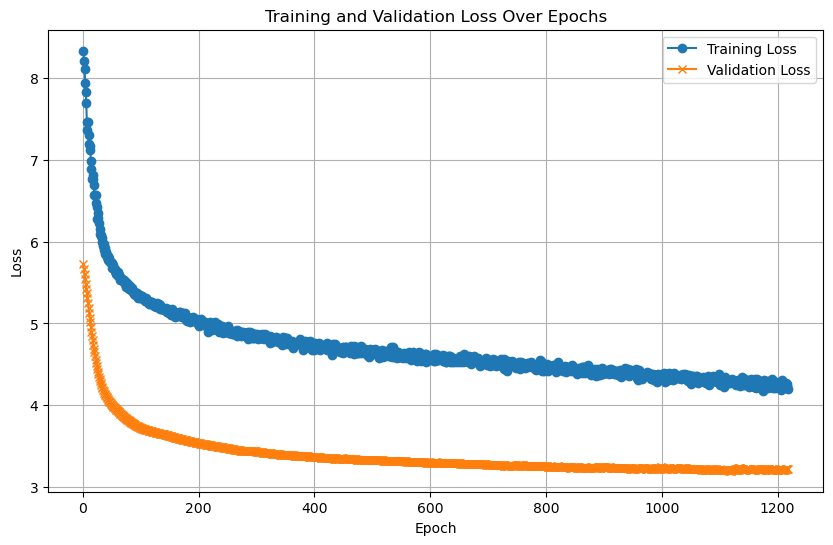

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/19], Loss: 5.8531

Test Loss: 5.2105


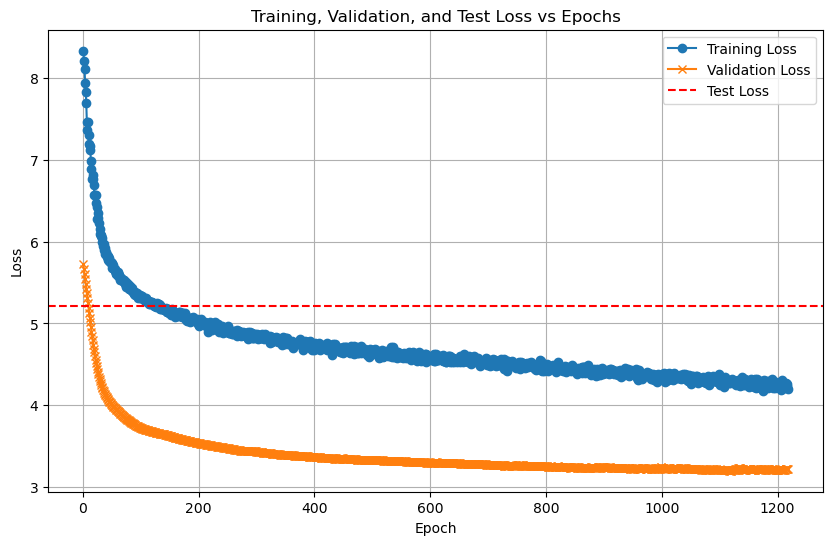

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/19 for test dataset.


Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (520, 128)
Train labels shape: (520,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4626, 128)
Test labels shape: (4626,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...


LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 53.85%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.56      1.00      0.71         5
           1       0.50      0.20      0.29         5
           2       0.50      0.80      0.62         5
           3       0.00      0.00      0.00         5
           4       1.00      0.80      0.89         5
           5       0.29      0.40      0.33         5
           6       0.00      0.00      0.00         5
           7       0.36      0.80      0.50         5
           8       0.67      0.80      0.73         5
           9       0.00      0.00      0.00         5
          10       1.00      1.00      1.00         5
          11       0.67      0.40      0.50         5
          12       0.57      0.80      0.67         5

    accuracy                           0.54        65
   macro avg       0.47      0.54     

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (520, 128)
Train labels shape: (520,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4626, 128)
Test labels shape: (4626,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7017  |  Val Loss: 2.6843
Validation loss improved from inf to 2.6843.
[Epoch 2/1000] Train Loss: 2.6505  |  Val Loss: 2.6387
Validation loss improved from 2.6843 to 2.6387.
[Epoch 3/1000] Train Loss: 2.6073  |  Val Loss: 2.6016
Validation loss improved from 2.6387 to 2.6016.
[Epoch 4/1000] Train Loss: 2.5712  |  Val Loss: 2.5712
Validation loss improved from 2.6016 to 2.5712.
[Epoch 5/1000] Train Loss: 2.5396  |  Val Loss: 2.5496
Validation loss improved from 2.5712 to 2.5496.


[Epoch 6/1000] Train Loss: 2.5169  |  Val Loss: 2.5328
Validation loss improved from 2.5496 to 2.5328.
[Epoch 7/1000] Train Loss: 2.4985  |  Val Loss: 2.5197
Validation loss improved from 2.5328 to 2.5197.
[Epoch 8/1000] Train Loss: 2.4823  |  Val Loss: 2.5095
Validation loss improved from 2.5197 to 2.5095.


[Epoch 9/1000] Train Loss: 2.4659  |  Val Loss: 2.5016
Validation loss improved from 2.5095 to 2.5016.
[Epoch 10/1000] Train Loss: 2.4512  |  Val Loss: 2.4927
Validation loss improved from 2.5016 to 2.4927.


[Epoch 11/1000] Train Loss: 2.4385  |  Val Loss: 2.4836
Validation loss improved from 2.4927 to 2.4836.


[Epoch 12/1000] Train Loss: 2.4267  |  Val Loss: 2.4754
Validation loss improved from 2.4836 to 2.4754.
[Epoch 13/1000] Train Loss: 2.4161  |  Val Loss: 2.4701
Validation loss improved from 2.4754 to 2.4701.
[Epoch 14/1000] Train Loss: 2.4077  |  Val Loss: 2.4645
Validation loss improved from 2.4701 to 2.4645.
[Epoch 15/1000] Train Loss: 2.3986  |  Val Loss: 2.4596
Validation loss improved from 2.4645 to 2.4596.
[Epoch 16/1000] Train Loss: 2.3912  |  Val Loss: 2.4547
Validation loss improved from 2.4596 to 2.4547.
[Epoch 17/1000] Train Loss: 2.3832  |  Val Loss: 2.4491
Validation loss improved from 2.4547 to 2.4491.


[Epoch 18/1000] Train Loss: 2.3749  |  Val Loss: 2.4431
Validation loss improved from 2.4491 to 2.4431.
[Epoch 19/1000] Train Loss: 2.3673  |  Val Loss: 2.4401
Validation loss improved from 2.4431 to 2.4401.


[Epoch 20/1000] Train Loss: 2.3597  |  Val Loss: 2.4364
Validation loss improved from 2.4401 to 2.4364.
[Epoch 21/1000] Train Loss: 2.3520  |  Val Loss: 2.4322
Validation loss improved from 2.4364 to 2.4322.
[Epoch 22/1000] Train Loss: 2.3447  |  Val Loss: 2.4295
Validation loss improved from 2.4322 to 2.4295.


[Epoch 23/1000] Train Loss: 2.3364  |  Val Loss: 2.4246
Validation loss improved from 2.4295 to 2.4246.
[Epoch 24/1000] Train Loss: 2.3290  |  Val Loss: 2.4230
Validation loss improved from 2.4246 to 2.4230.
[Epoch 25/1000] Train Loss: 2.3209  |  Val Loss: 2.4180
Validation loss improved from 2.4230 to 2.4180.
[Epoch 26/1000] Train Loss: 2.3126  |  Val Loss: 2.4145
Validation loss improved from 2.4180 to 2.4145.
[Epoch 27/1000] Train Loss: 2.3042  |  Val Loss: 2.4103
Validation loss improved from 2.4145 to 2.4103.
[Epoch 28/1000] Train Loss: 2.2961  |  Val Loss: 2.4082
Validation loss improved from 2.4103 to 2.4082.
[Epoch 29/1000] Train Loss: 2.2880  |  Val Loss: 2.4028
Validation loss improved from 2.4082 to 2.4028.


[Epoch 30/1000] Train Loss: 2.2793  |  Val Loss: 2.3976
Validation loss improved from 2.4028 to 2.3976.
[Epoch 31/1000] Train Loss: 2.2702  |  Val Loss: 2.3951
Validation loss improved from 2.3976 to 2.3951.


[Epoch 32/1000] Train Loss: 2.2622  |  Val Loss: 2.3911
Validation loss improved from 2.3951 to 2.3911.
[Epoch 33/1000] Train Loss: 2.2537  |  Val Loss: 2.3912
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 34/1000] Train Loss: 2.2456  |  Val Loss: 2.3844
Validation loss improved from 2.3911 to 2.3844.


[Epoch 35/1000] Train Loss: 2.2373  |  Val Loss: 2.3829
Validation loss improved from 2.3844 to 2.3829.
[Epoch 36/1000] Train Loss: 2.2282  |  Val Loss: 2.3775
Validation loss improved from 2.3829 to 2.3775.
[Epoch 37/1000] Train Loss: 2.2195  |  Val Loss: 2.3716
Validation loss improved from 2.3775 to 2.3716.
[Epoch 38/1000] Train Loss: 2.2115  |  Val Loss: 2.3668
Validation loss improved from 2.3716 to 2.3668.
[Epoch 39/1000] Train Loss: 2.2032  |  Val Loss: 2.3636
Validation loss improved from 2.3668 to 2.3636.
[Epoch 40/1000] Train Loss: 2.1945  |  Val Loss: 2.3579
Validation loss improved from 2.3636 to 2.3579.


[Epoch 41/1000] Train Loss: 2.1863  |  Val Loss: 2.3548
Validation loss improved from 2.3579 to 2.3548.
[Epoch 42/1000] Train Loss: 2.1777  |  Val Loss: 2.3532
Validation loss improved from 2.3548 to 2.3532.
[Epoch 43/1000] Train Loss: 2.1692  |  Val Loss: 2.3521
Validation loss improved from 2.3532 to 2.3521.


[Epoch 44/1000] Train Loss: 2.1611  |  Val Loss: 2.3503
Validation loss improved from 2.3521 to 2.3503.


[Epoch 45/1000] Train Loss: 2.1528  |  Val Loss: 2.3450
Validation loss improved from 2.3503 to 2.3450.
[Epoch 46/1000] Train Loss: 2.1442  |  Val Loss: 2.3362
Validation loss improved from 2.3450 to 2.3362.
[Epoch 47/1000] Train Loss: 2.1345  |  Val Loss: 2.3328
Validation loss improved from 2.3362 to 2.3328.
[Epoch 48/1000] Train Loss: 2.1262  |  Val Loss: 2.3285
Validation loss improved from 2.3328 to 2.3285.
[Epoch 49/1000] Train Loss: 2.1178  |  Val Loss: 2.3335
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 50/1000] Train Loss: 2.1114  |  Val Loss: 2.3323
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 51/1000] Train Loss: 2.1006  |  Val Loss: 2.3208
Validation loss improved from 2.3285 to 2.3208.
[Epoch 52/1000] Train Loss: 2.0912  |  Val Loss: 2.3104
Validation loss improved from 2.3208 to 2.3104.


[Epoch 53/1000] Train Loss: 2.0816  |  Val Loss: 2.3075
Validation loss improved from 2.3104 to 2.3075.
[Epoch 54/1000] Train Loss: 2.0724  |  Val Loss: 2.3103
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 55/1000] Train Loss: 2.0639  |  Val Loss: 2.3039
Validation loss improved from 2.3075 to 2.3039.


[Epoch 56/1000] Train Loss: 2.0547  |  Val Loss: 2.2964
Validation loss improved from 2.3039 to 2.2964.
[Epoch 57/1000] Train Loss: 2.0469  |  Val Loss: 2.2883
Validation loss improved from 2.2964 to 2.2883.
[Epoch 58/1000] Train Loss: 2.0381  |  Val Loss: 2.2893
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 59/1000] Train Loss: 2.0295  |  Val Loss: 2.2862
Validation loss improved from 2.2883 to 2.2862.
[Epoch 60/1000] Train Loss: 2.0217  |  Val Loss: 2.2827
Validation loss improved from 2.2862 to 2.2827.
[Epoch 61/1000] Train Loss: 2.0140  |  Val Loss: 2.2618
Validation loss improved from 2.2827 to 2.2618.
[Epoch 62/1000] Train Loss: 2.0110  |  Val Loss: 2.2453
Validation loss improved from 2.2618 to 2.2453.
[Epoch 63/1000] Train Loss: 2.0010  |  Val Loss: 2.2622
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 64/1000] Train Loss: 1.9906  |  Val Loss: 2.2729
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 65/1000] Train Loss: 1.9840  |  Val Loss: 2.2741
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 66/1000] Train Loss: 1.9760  |  Val Loss: 2.2663
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 67/1000] Train Loss: 1.9676  |  Val Loss: 2.2621
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 68/1000] Train Loss: 1.9601  |  Val Loss: 2.2587
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 69/1000] Train Loss: 1.9525  |  Val Loss: 2.2536
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 70/1000] Train Loss: 1.9447  |  Val Loss: 2.2465
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 71/1000] Train Loss: 1.9392  |  Val Loss: 2.2353
Validation loss improved from 2.2453 to 2.2353.
[Epoch 72/1000] Train Loss: 1.9310  |  Val Loss: 2.2375
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 73/1000] Train Loss: 1.9226  |  Val Loss: 2.2465
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 74/1000] Train Loss: 1.9160  |  Val Loss: 2.2448
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 75/1000] Train Loss: 1.9077  |  Val Loss: 2.2398
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 76/1000] Train Loss: 1.9007  |  Val Loss: 2.2201
Validation loss improved from 2.2353 to 2.2201.


[Epoch 77/1000] Train Loss: 1.8917  |  Val Loss: 2.2239
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 78/1000] Train Loss: 1.8833  |  Val Loss: 2.2312
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 79/1000] Train Loss: 1.8754  |  Val Loss: 2.2332
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 80/1000] Train Loss: 1.8685  |  Val Loss: 2.2228
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 81/1000] Train Loss: 1.8642  |  Val Loss: 2.1880
Validation loss improved from 2.2201 to 2.1880.
[Epoch 82/1000] Train Loss: 1.8593  |  Val Loss: 2.1897
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 83/1000] Train Loss: 1.8460  |  Val Loss: 2.2244
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 84/1000] Train Loss: 1.8388  |  Val Loss: 2.2372
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 85/1000] Train Loss: 1.8303  |  Val Loss: 2.2381
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 86/1000] Train Loss: 1.8236  |  Val Loss: 2.2263
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 87/1000] Train Loss: 1.8150  |  Val Loss: 2.2219
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 88/1000] Train Loss: 1.8068  |  Val Loss: 2.2083
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 89/1000] Train Loss: 1.7972  |  Val Loss: 2.2050
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 90/1000] Train Loss: 1.7899  |  Val Loss: 2.1895
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 91/1000] Train Loss: 1.7804  |  Val Loss: 2.2011
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 92/1000] Train Loss: 1.7728  |  Val Loss: 2.2010
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 93/1000] Train Loss: 1.7649  |  Val Loss: 2.2139
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 94/1000] Train Loss: 1.7584  |  Val Loss: 2.2065
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 95/1000] Train Loss: 1.7487  |  Val Loss: 2.2022
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 96/1000] Train Loss: 1.7398  |  Val Loss: 2.1751
Validation loss improved from 2.1880 to 2.1751.
[Epoch 97/1000] Train Loss: 1.7323  |  Val Loss: 2.1749
Validation loss improved from 2.1751 to 2.1749.
[Epoch 98/1000] T

[Epoch 100/1000] Train Loss: 1.7051  |  Val Loss: 2.1807
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 101/1000] Train Loss: 1.6967  |  Val Loss: 2.1740
Validation loss improved from 2.1749 to 2.1740.
[Epoch 102/1000] Train Loss: 1.6904  |  Val Loss: 2.1617
Validation loss improved from 2.1740 to 2.1617.
[Epoch 103/1000] Train Loss: 1.6786  |  Val Loss: 2.1666
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 104/1000] Train Loss: 1.6691  |  Val Loss: 2.1689
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 105/1000] Train Loss: 1.6599  |  Val Loss: 2.1699
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 106/1000] Train Loss: 1.6511  |  Val Loss: 2.1644
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 107/1000] Train Loss: 1.6419  |  Val Loss: 2.1614
Validation loss improved from 2.1617 to 2.1614.
[Epoch 108/1000] Train Loss: 1.6329  |  Val Loss: 2.1614
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 109/1000] Train Loss: 1.6239  |  Val Loss: 2.1649
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 110/1000] Tr

[Epoch 113/1000] Train Loss: 1.5871  |  Val Loss: 2.1526
Validation loss improved from 2.1583 to 2.1526.
[Epoch 114/1000] Train Loss: 1.5788  |  Val Loss: 2.1511
Validation loss improved from 2.1526 to 2.1511.
[Epoch 115/1000] Train Loss: 1.5721  |  Val Loss: 2.1096
Validation loss improved from 2.1511 to 2.1096.
[Epoch 116/1000] Train Loss: 1.5697  |  Val Loss: 2.1230
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 117/1000] Train Loss: 1.5532  |  Val Loss: 2.1458
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 118/1000] Train Loss: 1.5413  |  Val Loss: 2.1537
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 119/1000] Train Loss: 1.5330  |  Val Loss: 2.1533
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 120/1000] Train Loss: 1.5226  |  Val Loss: 2.1438
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 121/1000] Train Loss: 1.5135  |  Val Loss: 2.1440
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 122/1000] Tr

[Epoch 124/1000] Train Loss: 1.4855  |  Val Loss: 2.1372
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 125/1000] Train Loss: 1.4762  |  Val Loss: 2.1484
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 126/1000] Train Loss: 1.4675  |  Val Loss: 2.1372
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 127/1000] Train Loss: 1.4581  |  Val Loss: 2.1493
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 128/1000] Train Loss: 1.4489  |  Val Loss: 2.1477
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 129/1000] Train Loss: 1.4398  |  Val Loss: 2.1402
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 130/1000] Train Loss: 1.4306  |  Val Loss: 2.1440
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 131/1000] Train Loss: 1.4214  |  Val Loss: 2.1413
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 132/1000] Train Loss: 1.4137  |  Val Loss: 2.1504
!! Validation loss did NOT improve !! Patience: 

[Epoch 136/1000] Train Loss: 1.3773  |  Val Loss: 2.1363
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 137/1000] Train Loss: 1.3689  |  Val Loss: 2.1349
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 138/1000] Train Loss: 1.3598  |  Val Loss: 2.1380
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 139/1000] Train Loss: 1.3515  |  Val Loss: 2.1418
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 140/1000] Train Loss: 1.3426  |  Val Loss: 2.1424
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 141/1000] Train Loss: 1.3342  |  Val Loss: 2.1450
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 142/1000] Train Loss: 1.3264  |  Val Loss: 2.1469
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 143/1000] Train Loss: 1.3176  |  Val Loss: 2.1357
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 144/1000] Train Loss: 1.3093  |  Val Loss: 2.1344
!! Validation loss did NOT improve !! Patience:

[Epoch 147/1000] Train Loss: 1.2852  |  Val Loss: 2.1552
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 148/1000] Train Loss: 1.2786  |  Val Loss: 2.1649
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 149/1000] Train Loss: 1.2697  |  Val Loss: 2.1548
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 150/1000] Train Loss: 1.2665  |  Val Loss: 2.1872
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 151/1000] Train Loss: 1.2568  |  Val Loss: 2.1568
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 152/1000] Train Loss: 1.2455  |  Val Loss: 2.1708
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 153/1000] Train Loss: 1.2385  |  Val Loss: 2.1737
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 154/1000] Train Loss: 1.2292  |  Val Loss: 2.1822
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 155/1000] Train Loss: 1.2231  |  Val Loss: 2.1670
!! Validation loss did NOT improve !! Patience:

[Epoch 160/1000] Train Loss: 1.1851  |  Val Loss: 2.2079
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 161/1000] Train Loss: 1.1782  |  Val Loss: 2.2086
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 162/1000] Train Loss: 1.1709  |  Val Loss: 2.2145
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 163/1000] Train Loss: 1.1629  |  Val Loss: 2.2152
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 164/1000] Train Loss: 1.1554  |  Val Loss: 2.2000
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 165/1000] Train Loss: 1.1489  |  Val Loss: 2.1864
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 166/1000] Train Loss: 1.1439  |  Val Loss: 2.2158
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 167/1000] Train Loss: 1.1368  |  Val Loss: 2.2332
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 168/1000] Train Loss: 1.1280  |  Val Loss: 2.2278
!! Validation loss did NOT improve !! Patience:

[Epoch 172/1000] Train Loss: 1.1066  |  Val Loss: 2.2121
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 173/1000] Train Loss: 1.0971  |  Val Loss: 2.2524
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 174/1000] Train Loss: 1.0931  |  Val Loss: 2.2934
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 175/1000] Train Loss: 1.0929  |  Val Loss: 2.3016
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 176/1000] Train Loss: 1.0811  |  Val Loss: 2.2852
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 177/1000] Train Loss: 1.0678  |  Val Loss: 2.2885
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 178/1000] Train Loss: 1.0632  |  Val Loss: 2.2905
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 179/1000] Train Loss: 1.0553  |  Val Loss: 2.3096
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 180/1000] Train Loss: 1.0494  |  Val Loss: 2.3136
!! Validation loss did NOT improve !! Patience:

[Epoch 182/1000] Train Loss: 1.0367  |  Val Loss: 2.3322
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 183/1000] Train Loss: 1.0304  |  Val Loss: 2.3290
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 184/1000] Train Loss: 1.0252  |  Val Loss: 2.3408
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 185/1000] Train Loss: 1.0191  |  Val Loss: 2.3510
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 186/1000] Train Loss: 1.0137  |  Val Loss: 2.3659
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 187/1000] Train Loss: 1.0073  |  Val Loss: 2.3685
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 188/1000] Train Loss: 1.0039  |  Val Loss: 2.3682
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 189/1000] Train Loss: 0.9958  |  Val Loss: 2.3052
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 190/1000] Train Loss: 1.0255  |  Val Loss: 2.3420
!! Validation loss did NOT improve !! Patience:

[Epoch 193/1000] Train Loss: 0.9780  |  Val Loss: 2.4341
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 194/1000] Train Loss: 0.9707  |  Val Loss: 2.4219
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 195/1000] Train Loss: 0.9652  |  Val Loss: 2.4348
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 196/1000] Train Loss: 0.9598  |  Val Loss: 2.4208
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 197/1000] Train Loss: 0.9551  |  Val Loss: 2.4409
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 198/1000] Train Loss: 0.9500  |  Val Loss: 2.4542
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 199/1000] Train Loss: 0.9460  |  Val Loss: 2.4610
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 200/1000] Train Loss: 0.9403  |  Val Loss: 2.4757
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 201/1000] Train Loss: 0.9357  |  Val Loss: 2.4879
!! Validation loss did NOT improve !! Patience:

[Epoch 205/1000] Train Loss: 0.9163  |  Val Loss: 2.5182
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 206/1000] Train Loss: 0.9118  |  Val Loss: 2.5340
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 207/1000] Train Loss: 0.9074  |  Val Loss: 2.5475
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 208/1000] Train Loss: 0.9030  |  Val Loss: 2.5399
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 209/1000] Train Loss: 0.8991  |  Val Loss: 2.5410
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 210/1000] Train Loss: 0.8943  |  Val Loss: 2.5525
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 211/1000] Train Loss: 0.8905  |  Val Loss: 2.5311
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 212/1000] Train Loss: 0.8860  |  Val Loss: 2.5577
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 213/1000] Train Loss: 0.8818  |  Val Loss: 2.5815
!! Validation loss did NOT improve !! Patience:

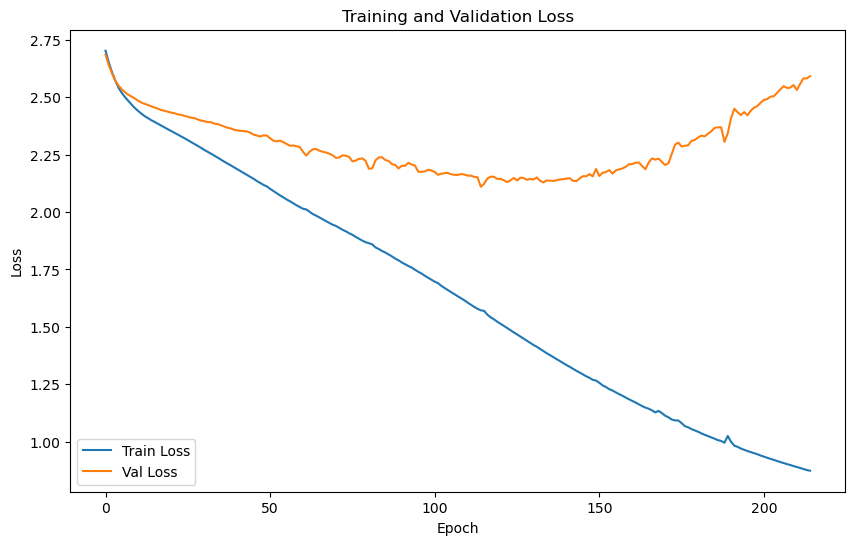

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 2.3713 | Test Accuracy: 60.92%


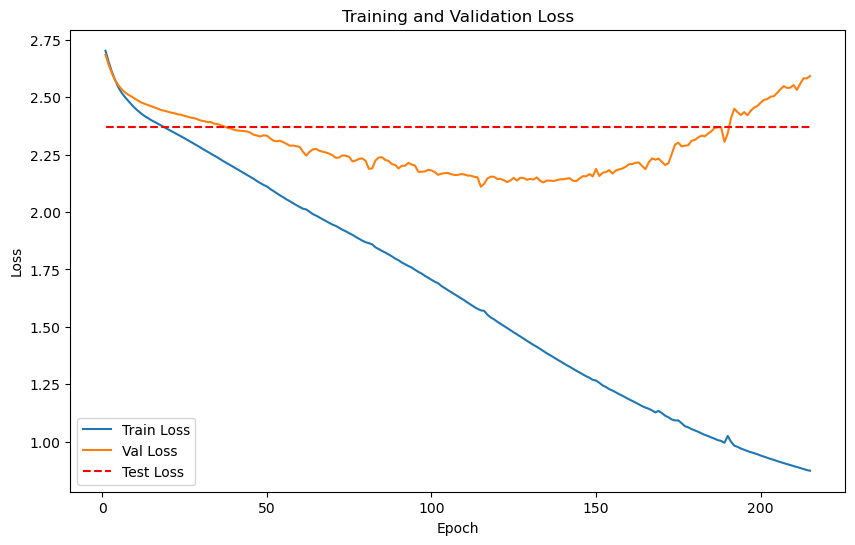

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 520 samples with 64 features each
LOG: Labels shape: (520,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4626 samples with 64 features each
LOG: Labels shape: (4626,)


Train embeddings shape: (520, 64), 
Train labels shape: (520,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (4626, 64), 
Test labels shape: (4626,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}
Training batch size: 260


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.5434
    Batch [2/2], Train Loss: 0.5368
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.6382
    Batch [2/2], Val Loss: 0.5000
Epoch [1/2000], Avg Train Loss: 0.5401, Avg Val Loss: 0.5691

Validation loss improved from inf to 0.5691. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/2], Train Loss: 0.5389
    Batch [2/2], Train Loss: 0.5406
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.6363
    Batch [2/2], Val Loss: 0.5000
Epoch [2/2000], Avg Train Loss: 0.5398, Avg Val Loss: 0.5682

Validation loss improved from 0.5691 to 0.5682. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/2], Train Loss: 0.5329
    Batch [2/2], Train Loss: 0.5343
LOG: Epoch [3/2000] - Validation


    Batch [1/2], Val Loss: 0.6315
    Batch [2/2], Val Loss: 0.5000
Epoch [3/2000], Avg Train Loss: 0.5336, Avg Val Loss: 0.5657

Validation loss improved from 0.5682 to 0.5657. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 0.5359


    Batch [2/2], Train Loss: 0.5323
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.6277
    Batch [2/2], Val Loss: 0.5000
Epoch [4/2000], Avg Train Loss: 0.5341, Avg Val Loss: 0.5638

Validation loss improved from 0.5657 to 0.5638. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss: 0.5286


    Batch [2/2], Train Loss: 0.5314
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.6248
    Batch [2/2], Val Loss: 0.5000
Epoch [5/2000], Avg Train Loss: 0.5300, Avg Val Loss: 0.5624

Validation loss improved from 0.5638 to 0.5624. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/2], Train Loss: 0.5288


    Batch [2/2], Train Loss: 0.5275
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.6205
    Batch [2/2], Val Loss: 0.5000
Epoch [6/2000], Avg Train Loss: 0.5282, Avg Val Loss: 0.5602

Validation loss improved from 0.5624 to 0.5602. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/2], Train Loss: 0.5287


    Batch [2/2], Train Loss: 0.5267
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.6150
    Batch [2/2], Val Loss: 0.5000
Epoch [7/2000], Avg Train Loss: 0.5277, Avg Val Loss: 0.5575

Validation loss improved from 0.5602 to 0.5575. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/2], Train Loss: 0.5225


    Batch [2/2], Train Loss: 0.5247
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.6092
    Batch [2/2], Val Loss: 0.5000
Epoch [8/2000], Avg Train Loss: 0.5236, Avg Val Loss: 0.5546

Validation loss improved from 0.5575 to 0.5546. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/2], Train Loss: 0.5249
    Batch [2/2], Train Loss: 0.5225
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.6043
    Batch [2/2], Val Loss: 0.5000
Epoch [9/2000], Avg Train Loss: 0.5237, Avg Val Loss: 0.5521

Validation loss improved from 0.5546 to 0.5521. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/2], Train Loss: 0.5238
    Batch [2/2], Train Loss: 0.5182
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.5978
    Batch [2/2], Val Loss: 0.5000
Epoch [10/2000], Avg Train Loss: 0.5210, Avg Val Loss: 0.5489

Validation loss improved from 0.5521 to 0.5489. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/2], Train Loss: 0.5249
    Batch [2/2], Train Loss: 0.5194
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.5933
    Batch [2/2], Val Loss: 0.5000
Epoch [11/2000], Avg Train Loss: 0.5222, Avg Val Loss: 0.5467

Validation loss improved from 0.5489 to 0.5467. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/2], Train Loss: 0.5213
    Batch [2/2], Train Loss: 0.5154
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.5875
    Batch [2/2], Val Loss: 0.5000
Epoch [12/2000], Avg Train Loss: 0.5184, Avg Val Loss: 0.5437

Validation loss improved from 0.5467 to 0.5437. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/2], Train Loss: 0.5174
    Batch [2/2], Train Loss: 0.5187
LOG: Epoch [13/2000] - Validation


    Batch [1/2], Val Loss: 0.5820
    Batch [2/2], Val Loss: 0.5000
Epoch [13/2000], Avg Train Loss: 0.5181, Avg Val Loss: 0.5410

Validation loss improved from 0.5437 to 0.5410. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 0.5208


    Batch [2/2], Train Loss: 0.5189
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.5768
    Batch [2/2], Val Loss: 0.5000
Epoch [14/2000], Avg Train Loss: 0.5199, Avg Val Loss: 0.5384

Validation loss improved from 0.5410 to 0.5384. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 0.5138


    Batch [2/2], Train Loss: 0.5163
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.5710
    Batch [2/2], Val Loss: 0.5000
Epoch [15/2000], Avg Train Loss: 0.5150, Avg Val Loss: 0.5355

Validation loss improved from 0.5384 to 0.5355. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/2], Train Loss: 0.5172


    Batch [2/2], Train Loss: 0.5139
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5655
    Batch [2/2], Val Loss: 0.5000
Epoch [16/2000], Avg Train Loss: 0.5156, Avg Val Loss: 0.5327

Validation loss improved from 0.5355 to 0.5327. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/2], Train Loss: 0.5123


    Batch [2/2], Train Loss: 0.5119
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.5604
    Batch [2/2], Val Loss: 0.5000
Epoch [17/2000], Avg Train Loss: 0.5121, Avg Val Loss: 0.5302

Validation loss improved from 0.5327 to 0.5302. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/2], Train Loss: 0.5124


    Batch [2/2], Train Loss: 0.5138
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.5551
    Batch [2/2], Val Loss: 0.5000
Epoch [18/2000], Avg Train Loss: 0.5131, Avg Val Loss: 0.5276

Validation loss improved from 0.5302 to 0.5276. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/2], Train Loss: 0.5117


    Batch [2/2], Train Loss: 0.5137
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.5499
    Batch [2/2], Val Loss: 0.5000
Epoch [19/2000], Avg Train Loss: 0.5127, Avg Val Loss: 0.5249

Validation loss improved from 0.5276 to 0.5249. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/2], Train Loss: 0.5131
    Batch [2/2], Train Loss: 0.5125
LOG: Epoch [20/2000] - Validation


    Batch [1/2], Val Loss: 0.5453
    Batch [2/2], Val Loss: 0.5000
Epoch [20/2000], Avg Train Loss: 0.5128, Avg Val Loss: 0.5227

Validation loss improved from 0.5249 to 0.5227. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/2], Train Loss: 0.5128


    Batch [2/2], Train Loss: 0.5114
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.5416
    Batch [2/2], Val Loss: 0.5000
Epoch [21/2000], Avg Train Loss: 0.5121, Avg Val Loss: 0.5208

Validation loss improved from 0.5227 to 0.5208. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/2], Train Loss: 0.5082
    Batch [2/2], Train Loss: 0.5104
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.5378
    Batch [2/2], Val Loss: 0.5000
Epoch [22/2000], Avg Train Loss: 0.5093, Avg Val Loss: 0.5189

Validation loss improved from 0.5208 to 0.5189. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/2], Train Loss: 0.5088
    Batch [2/2], Train Loss: 0.5108
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.5348
    Batch [2/2], Val Loss: 0.5000
Epoch [23/2000], Avg Train Loss: 0.5098, Avg Val Loss: 0.5174

Validation loss improved from 0.5189 to 0.5174. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/2], Train Loss: 0.5102
    Batch [2/2], Train Loss: 0.5106
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.5322
    Batch [2/2], Val Loss: 0.5000
Epoch [24/2000], Avg Train Loss: 0.5104, Avg Val Loss: 0.5161

Validation loss improved from 0.5174 to 0.5161. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/2], Train Loss: 0.5082
    Batch [2/2], Train Loss: 0.5108
LOG: Epoch [25/2000] - Validation


    Batch [1/2], Val Loss: 0.5291
    Batch [2/2], Val Loss: 0.5000
Epoch [25/2000], Avg Train Loss: 0.5095, Avg Val Loss: 0.5146

Validation loss improved from 0.5161 to 0.5146. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/2], Train Loss: 0.5100


    Batch [2/2], Train Loss: 0.5053
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.5271
    Batch [2/2], Val Loss: 0.5000
Epoch [26/2000], Avg Train Loss: 0.5077, Avg Val Loss: 0.5136

Validation loss improved from 0.5146 to 0.5136. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/2], Train Loss: 0.5077


    Batch [2/2], Train Loss: 0.5076
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.5254
    Batch [2/2], Val Loss: 0.5000
Epoch [27/2000], Avg Train Loss: 0.5077, Avg Val Loss: 0.5127

Validation loss improved from 0.5136 to 0.5127. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/2], Train Loss: 0.5090


    Batch [2/2], Train Loss: 0.5067
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.5242
    Batch [2/2], Val Loss: 0.5000
Epoch [28/2000], Avg Train Loss: 0.5078, Avg Val Loss: 0.5121

Validation loss improved from 0.5127 to 0.5121. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/2], Train Loss: 0.5052


    Batch [2/2], Train Loss: 0.5062
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.5225
    Batch [2/2], Val Loss: 0.5000
Epoch [29/2000], Avg Train Loss: 0.5057, Avg Val Loss: 0.5113

Validation loss improved from 0.5121 to 0.5113. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/2], Train Loss: 0.5068


    Batch [2/2], Train Loss: 0.5065
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.5219
    Batch [2/2], Val Loss: 0.5000
Epoch [30/2000], Avg Train Loss: 0.5066, Avg Val Loss: 0.5110

Validation loss improved from 0.5113 to 0.5110. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/2], Train Loss: 0.5083
    Batch [2/2], Train Loss: 0.5064
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.5207
    Batch [2/2], Val Loss: 0.5000
Epoch [31/2000], Avg Train Loss: 0.5073, Avg Val Loss: 0.5103

Validation loss improved from 0.5110 to 0.5103. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/2], Train Loss: 0.5060
    Batch [2/2], Train Loss: 0.5073
LOG: Epoch [32/2000] - Validation


    Batch [1/2], Val Loss: 0.5193
    Batch [2/2], Val Loss: 0.5000
Epoch [32/2000], Avg Train Loss: 0.5066, Avg Val Loss: 0.5097

Validation loss improved from 0.5103 to 0.5097. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/2], Train Loss: 0.5039


    Batch [2/2], Train Loss: 0.5056
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.5182
    Batch [2/2], Val Loss: 0.5000
Epoch [33/2000], Avg Train Loss: 0.5047, Avg Val Loss: 0.5091

Validation loss improved from 0.5097 to 0.5091. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/2], Train Loss: 0.5071
    Batch [2/2], Train Loss: 0.5054
LOG: Epoch [34/2000] - Validation


    Batch [1/2], Val Loss: 0.5178
    Batch [2/2], Val Loss: 0.5000
Epoch [34/2000], Avg Train Loss: 0.5062, Avg Val Loss: 0.5089

Validation loss improved from 0.5091 to 0.5089. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 0.5055


    Batch [2/2], Train Loss: 0.5045
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.5172
    Batch [2/2], Val Loss: 0.5000
Epoch [35/2000], Avg Train Loss: 0.5050, Avg Val Loss: 0.5086

Validation loss improved from 0.5089 to 0.5086. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 0.5075


    Batch [2/2], Train Loss: 0.5044
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.5166
    Batch [2/2], Val Loss: 0.5000
Epoch [36/2000], Avg Train Loss: 0.5060, Avg Val Loss: 0.5083

Validation loss improved from 0.5086 to 0.5083. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/2], Train Loss: 0.5063


    Batch [2/2], Train Loss: 0.5082
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.5163
    Batch [2/2], Val Loss: 0.5000
Epoch [37/2000], Avg Train Loss: 0.5073, Avg Val Loss: 0.5081

Validation loss improved from 0.5083 to 0.5081. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/2], Train Loss: 0.5069


    Batch [2/2], Train Loss: 0.5058
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.5000
Epoch [38/2000], Avg Train Loss: 0.5063, Avg Val Loss: 0.5079

Validation loss improved from 0.5081 to 0.5079. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/2], Train Loss: 0.5040


    Batch [2/2], Train Loss: 0.5060
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.5153
    Batch [2/2], Val Loss: 0.5000
Epoch [39/2000], Avg Train Loss: 0.5050, Avg Val Loss: 0.5076

Validation loss improved from 0.5079 to 0.5076. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/2], Train Loss: 0.5051
    Batch [2/2], Train Loss: 0.5050
LOG: Epoch [40/2000] - Validation


    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [40/2000], Avg Train Loss: 0.5050, Avg Val Loss: 0.5075

Validation loss improved from 0.5076 to 0.5075. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/2], Train Loss: 0.5061


    Batch [2/2], Train Loss: 0.5040
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.5144
    Batch [2/2], Val Loss: 0.5000
Epoch [41/2000], Avg Train Loss: 0.5050, Avg Val Loss: 0.5072

Validation loss improved from 0.5075 to 0.5072. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/2], Train Loss: 0.5042


    Batch [2/2], Train Loss: 0.5041
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.5140
    Batch [2/2], Val Loss: 0.5000
Epoch [42/2000], Avg Train Loss: 0.5041, Avg Val Loss: 0.5070

Validation loss improved from 0.5072 to 0.5070. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/2], Train Loss: 0.5063


    Batch [2/2], Train Loss: 0.5023
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.5128
    Batch [2/2], Val Loss: 0.5000
Epoch [43/2000], Avg Train Loss: 0.5043, Avg Val Loss: 0.5064

Validation loss improved from 0.5070 to 0.5064. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/2], Train Loss: 0.5047


    Batch [2/2], Train Loss: 0.5036
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.5123
    Batch [2/2], Val Loss: 0.5000
Epoch [44/2000], Avg Train Loss: 0.5042, Avg Val Loss: 0.5061

Validation loss improved from 0.5064 to 0.5061. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/2], Train Loss: 0.5043
    Batch [2/2], Train Loss: 0.5040
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.5119
    Batch [2/2], Val Loss: 0.5000
Epoch [45/2000], Avg Train Loss: 0.5042, Avg Val Loss: 0.5060

Validation loss improved from 0.5061 to 0.5060. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/2], Train Loss: 0.5057
    Batch [2/2], Train Loss: 0.5048
LOG: Epoch [46/2000] - Validation


    Batch [1/2], Val Loss: 0.5119
    Batch [2/2], Val Loss: 0.5000
Epoch [46/2000], Avg Train Loss: 0.5052, Avg Val Loss: 0.5059

Validation loss improved from 0.5060 to 0.5059. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/2], Train Loss: 0.5080


    Batch [2/2], Train Loss: 0.5048
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.5115
    Batch [2/2], Val Loss: 0.5000
Epoch [47/2000], Avg Train Loss: 0.5064, Avg Val Loss: 0.5058

Validation loss improved from 0.5059 to 0.5058. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/2], Train Loss: 0.5047
    Batch [2/2], Train Loss: 0.5015
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.5114
    Batch [2/2], Val Loss: 0.5000
Epoch [48/2000], Avg Train Loss: 0.5031, Avg Val Loss: 0.5057

Validation loss improved from 0.5058 to 0.5057. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/2], Train Loss: 0.5016
    Batch [2/2], Train Loss: 0.5054
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.5109
    Batch [2/2], Val Loss: 0.5000
Epoch [49/2000], Avg Train Loss: 0.5035, Avg Val Loss: 0.5054

Validation loss improved from 0.5057 to 0.5054. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/2], Train Loss: 0.5031
    Batch [2/2], Train Loss: 0.5052
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.5107
    Batch [2/2], Val Loss: 0.5000
Epoch [50/2000], Avg Train Loss: 0.5041, Avg Val Loss: 0.5054

Validation loss improved from 0.5054 to 0.5054. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/2], Train Loss: 0.5005
    Batch [2/2], Train Loss: 0.5028
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.5105
    Batch [2/2], Val Loss: 0.5000
Epoch [51/2000], Avg Train Loss: 0.5016, Avg Val Loss: 0.5053

Validation loss improved from 0.5054 to 0.5053. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/2], Train Loss: 0.5041
    Batch [2/2], Train Loss: 0.5007
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.5103
    Batch [2/2], Val Loss: 0.5000
Epoch [52/2000], Avg Train Loss: 0.5024, Avg Val Loss: 0.5052

Validation loss improved from 0.5053 to 0.5052. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/2], Train Loss: 0.5031
    Batch [2/2], Train Loss: 0.5024
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.5100
    Batch [2/2], Val Loss: 0.5000
Epoch [53/2000], Avg Train Loss: 0.5028, Avg Val Loss: 0.5050

Validation loss improved from 0.5052 to 0.5050. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/2], Train Loss: 0.5028
    Batch [2/2], Train Loss: 0.5042
LOG: Epoch [54/2000] - Validation


    Batch [1/2], Val Loss: 0.5104
    Batch [2/2], Val Loss: 0.5000
Epoch [54/2000], Avg Train Loss: 0.5035, Avg Val Loss: 0.5052

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 0.5032


    Batch [2/2], Train Loss: 0.5027
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.5108
    Batch [2/2], Val Loss: 0.5000
Epoch [55/2000], Avg Train Loss: 0.5030, Avg Val Loss: 0.5054

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 0.5016


    Batch [2/2], Train Loss: 0.5019
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.5107
    Batch [2/2], Val Loss: 0.5000
Epoch [56/2000], Avg Train Loss: 0.5018, Avg Val Loss: 0.5054

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [57/2000] - Training


    Batch [1/2], Train Loss: 0.5029
    Batch [2/2], Train Loss: 0.4993
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.5102
    Batch [2/2], Val Loss: 0.5000
Epoch [57/2000], Avg Train Loss: 0.5011, Avg Val Loss: 0.5051

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [58/2000] - Training


    Batch [1/2], Train Loss: 0.4984
    Batch [2/2], Train Loss: 0.5010
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.5098
    Batch [2/2], Val Loss: 0.5000
Epoch [58/2000], Avg Train Loss: 0.4997, Avg Val Loss: 0.5049

Validation loss improved from 0.5050 to 0.5049. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/2], Train Loss: 0.5018
    Batch [2/2], Train Loss: 0.4974
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.5094
    Batch [2/2], Val Loss: 0.5000
Epoch [59/2000], Avg Train Loss: 0.4996, Avg Val Loss: 0.5047

Validation loss improved from 0.5049 to 0.5047. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/2], Train Loss: 0.5051
    Batch [2/2], Train Loss: 0.5014
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.5090
    Batch [2/2], Val Loss: 0.5000
Epoch [60/2000], Avg Train Loss: 0.5033, Avg Val Loss: 0.5045

Validation loss improved from 0.5047 to 0.5045. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/2], Train Loss: 0.5016
    Batch [2/2], Train Loss: 0.5011
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.5088
    Batch [2/2], Val Loss: 0.5000
Epoch [61/2000], Avg Train Loss: 0.5013, Avg Val Loss: 0.5044

Validation loss improved from 0.5045 to 0.5044. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/2], Train Loss: 0.5022
    Batch [2/2], Train Loss: 0.4997
LOG: Epoch [62/2000] - Validation


    Batch [1/2], Val Loss: 0.5082
    Batch [2/2], Val Loss: 0.5000
Epoch [62/2000], Avg Train Loss: 0.5009, Avg Val Loss: 0.5041

Validation loss improved from 0.5044 to 0.5041. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/2], Train Loss: 0.4988


    Batch [2/2], Train Loss: 0.5023
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.5076
    Batch [2/2], Val Loss: 0.5000
Epoch [63/2000], Avg Train Loss: 0.5005, Avg Val Loss: 0.5038

Validation loss improved from 0.5041 to 0.5038. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/2], Train Loss: 0.5014
    Batch [2/2], Train Loss: 0.4976
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.5000
Epoch [64/2000], Avg Train Loss: 0.4995, Avg Val Loss: 0.5034

Validation loss improved from 0.5038 to 0.5034. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/2], Train Loss: 0.5007
    Batch [2/2], Train Loss: 0.4989
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.5063
    Batch [2/2], Val Loss: 0.5000
Epoch [65/2000], Avg Train Loss: 0.4998, Avg Val Loss: 0.5032

Validation loss improved from 0.5034 to 0.5032. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/2], Train Loss: 0.5000
    Batch [2/2], Train Loss: 0.4994
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.5059
    Batch [2/2], Val Loss: 0.5000
Epoch [66/2000], Avg Train Loss: 0.4997, Avg Val Loss: 0.5029

Validation loss improved from 0.5032 to 0.5029. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/2], Train Loss: 0.5010
    Batch [2/2], Train Loss: 0.5015
LOG: Epoch [67/2000] - Validation


    Batch [1/2], Val Loss: 0.5056
    Batch [2/2], Val Loss: 0.5000
Epoch [67/2000], Avg Train Loss: 0.5013, Avg Val Loss: 0.5028

Validation loss improved from 0.5029 to 0.5028. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/2], Train Loss: 0.5022


    Batch [2/2], Train Loss: 0.4964
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.5052
    Batch [2/2], Val Loss: 0.5000
Epoch [68/2000], Avg Train Loss: 0.4993, Avg Val Loss: 0.5026

Validation loss improved from 0.5028 to 0.5026. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 0.5004


    Batch [2/2], Train Loss: 0.4958
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.5047
    Batch [2/2], Val Loss: 0.5000
Epoch [69/2000], Avg Train Loss: 0.4981, Avg Val Loss: 0.5024

Validation loss improved from 0.5026 to 0.5024. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/2], Train Loss: 0.4994
    Batch [2/2], Train Loss: 0.4989
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.5049
    Batch [2/2], Val Loss: 0.5000
Epoch [70/2000], Avg Train Loss: 0.4991, Avg Val Loss: 0.5024

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [71/2000] - Training


    Batch [1/2], Train Loss: 0.5007
    Batch [2/2], Train Loss: 0.4982
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.5047
    Batch [2/2], Val Loss: 0.5000
Epoch [71/2000], Avg Train Loss: 0.4994, Avg Val Loss: 0.5023

Validation loss improved from 0.5024 to 0.5023. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/2], Train Loss: 0.4967
    Batch [2/2], Train Loss: 0.4985
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.5050
    Batch [2/2], Val Loss: 0.5000
Epoch [72/2000], Avg Train Loss: 0.4976, Avg Val Loss: 0.5025

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [73/2000] - Training


    Batch [1/2], Train Loss: 0.4993
    Batch [2/2], Train Loss: 0.4984
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.5049
    Batch [2/2], Val Loss: 0.5000
Epoch [73/2000], Avg Train Loss: 0.4989, Avg Val Loss: 0.5025

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [74/2000] - Training


    Batch [1/2], Train Loss: 0.4989
    Batch [2/2], Train Loss: 0.5011
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.5051
    Batch [2/2], Val Loss: 0.5000
Epoch [74/2000], Avg Train Loss: 0.5000, Avg Val Loss: 0.5025

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [75/2000] - Training


    Batch [1/2], Train Loss: 0.4967
    Batch [2/2], Train Loss: 0.4955
LOG: Epoch [75/2000] - Validation


    Batch [1/2], Val Loss: 0.5050
    Batch [2/2], Val Loss: 0.5000
Epoch [75/2000], Avg Train Loss: 0.4961, Avg Val Loss: 0.5025

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [76/2000] - Training
    Batch [1/2], Train Loss: 0.4986


    Batch [2/2], Train Loss: 0.4961
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.5000
Epoch [76/2000], Avg Train Loss: 0.4974, Avg Val Loss: 0.5019

Validation loss improved from 0.5023 to 0.5019. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/2], Train Loss: 0.4981
    Batch [2/2], Train Loss: 0.4961
LOG: Epoch [77/2000] - Validation


    Batch [1/2], Val Loss: 0.5036
    Batch [2/2], Val Loss: 0.5000
Epoch [77/2000], Avg Train Loss: 0.4971, Avg Val Loss: 0.5018

Validation loss improved from 0.5019 to 0.5018. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/2], Train Loss: 0.4961


    Batch [2/2], Train Loss: 0.4993
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.5029
    Batch [2/2], Val Loss: 0.5000
Epoch [78/2000], Avg Train Loss: 0.4977, Avg Val Loss: 0.5015

Validation loss improved from 0.5018 to 0.5015. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/2], Train Loss: 0.5000


    Batch [2/2], Train Loss: 0.4973
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.5029
    Batch [2/2], Val Loss: 0.5000
Epoch [79/2000], Avg Train Loss: 0.4986, Avg Val Loss: 0.5014

Validation loss improved from 0.5015 to 0.5014. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/2], Train Loss: 0.4971


    Batch [2/2], Train Loss: 0.4951
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.5017
    Batch [2/2], Val Loss: 0.5000
Epoch [80/2000], Avg Train Loss: 0.4961, Avg Val Loss: 0.5008

Validation loss improved from 0.5014 to 0.5008. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 0.4980


    Batch [2/2], Train Loss: 0.5005
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.5015
    Batch [2/2], Val Loss: 0.5000
Epoch [81/2000], Avg Train Loss: 0.4992, Avg Val Loss: 0.5007

Validation loss improved from 0.5008 to 0.5007. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/2], Train Loss: 0.4948


    Batch [2/2], Train Loss: 0.4955
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.5013
    Batch [2/2], Val Loss: 0.5000
Epoch [82/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.5006

Validation loss improved from 0.5007 to 0.5006. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/2], Train Loss: 0.4964
    Batch [2/2], Train Loss: 0.4990
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.5011
    Batch [2/2], Val Loss: 0.5000
Epoch [83/2000], Avg Train Loss: 0.4977, Avg Val Loss: 0.5006

Validation loss improved from 0.5006 to 0.5006. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/2], Train Loss: 0.4995
    Batch [2/2], Train Loss: 0.4984
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.5000
Epoch [84/2000], Avg Train Loss: 0.4989, Avg Val Loss: 0.5004

Validation loss improved from 0.5006 to 0.5004. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/2], Train Loss: 0.4976
    Batch [2/2], Train Loss: 0.4990
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.5012
    Batch [2/2], Val Loss: 0.5000
Epoch [85/2000], Avg Train Loss: 0.4983, Avg Val Loss: 0.5006

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [86/2000] - Training


    Batch [1/2], Train Loss: 0.4925
    Batch [2/2], Train Loss: 0.4971
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.5006
    Batch [2/2], Val Loss: 0.5000
Epoch [86/2000], Avg Train Loss: 0.4948, Avg Val Loss: 0.5003

Validation loss improved from 0.5004 to 0.5003. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/2], Train Loss: 0.4933
    Batch [2/2], Train Loss: 0.4948
LOG: Epoch [87/2000] - Validation


    Batch [1/2], Val Loss: 0.4999
    Batch [2/2], Val Loss: 0.5000
Epoch [87/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5000

Validation loss improved from 0.5003 to 0.5000. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/2], Train Loss: 0.4935


    Batch [2/2], Train Loss: 0.4984
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4988
    Batch [2/2], Val Loss: 0.5000
Epoch [88/2000], Avg Train Loss: 0.4960, Avg Val Loss: 0.4994

Validation loss improved from 0.5000 to 0.4994. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/2], Train Loss: 0.4986


    Batch [2/2], Train Loss: 0.4955
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4989
    Batch [2/2], Val Loss: 0.5000
Epoch [89/2000], Avg Train Loss: 0.4971, Avg Val Loss: 0.4994

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [90/2000] - Training


    Batch [1/2], Train Loss: 0.4961
    Batch [2/2], Train Loss: 0.4954
LOG: Epoch [90/2000] - Validation


    Batch [1/2], Val Loss: 0.4985
    Batch [2/2], Val Loss: 0.5000
Epoch [90/2000], Avg Train Loss: 0.4958, Avg Val Loss: 0.4993

Validation loss improved from 0.4994 to 0.4993. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/2], Train Loss: 0.4979


    Batch [2/2], Train Loss: 0.4927
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4982
    Batch [2/2], Val Loss: 0.5000
Epoch [91/2000], Avg Train Loss: 0.4953, Avg Val Loss: 0.4991

Validation loss improved from 0.4993 to 0.4991. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/2], Train Loss: 0.4952


    Batch [2/2], Train Loss: 0.4949
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [92/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [93/2000] - Training
    Batch [1/2], Train Loss: 0.4954


    Batch [2/2], Train Loss: 0.4942
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4981
    Batch [2/2], Val Loss: 0.5000
Epoch [93/2000], Avg Train Loss: 0.4948, Avg Val Loss: 0.4991

Validation loss improved from 0.4991 to 0.4991. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/2], Train Loss: 0.4932


    Batch [2/2], Train Loss: 0.4963
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4980
    Batch [2/2], Val Loss: 0.5000
Epoch [94/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.4990

Validation loss improved from 0.4991 to 0.4990. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/2], Train Loss: 0.4945


    Batch [2/2], Train Loss: 0.4949
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4973
    Batch [2/2], Val Loss: 0.5000
Epoch [95/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.4986

Validation loss improved from 0.4990 to 0.4986. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/2], Train Loss: 0.4965


    Batch [2/2], Train Loss: 0.4946
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4977
    Batch [2/2], Val Loss: 0.5000
Epoch [96/2000], Avg Train Loss: 0.4955, Avg Val Loss: 0.4988

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [97/2000] - Training
    Batch [1/2], Train Loss: 0.4917


    Batch [2/2], Train Loss: 0.4942
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [97/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [98/2000] - Training
    Batch [1/2], Train Loss: 0.4941


    Batch [2/2], Train Loss: 0.4929
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [98/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [99/2000] - Training
    Batch [1/2], Train Loss: 0.4972


    Batch [2/2], Train Loss: 0.4917
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4989
    Batch [2/2], Val Loss: 0.5000
Epoch [99/2000], Avg Train Loss: 0.4945, Avg Val Loss: 0.4995

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [100/2000] - Training
    Batch [1/2], Train Loss: 0.4938


    Batch [2/2], Train Loss: 0.4959
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4985
    Batch [2/2], Val Loss: 0.5000
Epoch [100/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.4993

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [101/2000] - Training


    Batch [1/2], Train Loss: 0.4924
    Batch [2/2], Train Loss: 0.4945
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4982
    Batch [2/2], Val Loss: 0.5000
Epoch [101/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.4991

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [102/2000] - Training


    Batch [1/2], Train Loss: 0.4891
    Batch [2/2], Train Loss: 0.4907
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4977
    Batch [2/2], Val Loss: 0.5000
Epoch [102/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4988

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [103/2000] - Training


    Batch [1/2], Train Loss: 0.4935
    Batch [2/2], Train Loss: 0.4897
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4966
    Batch [2/2], Val Loss: 0.5000
Epoch [103/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.4983

Validation loss improved from 0.4986 to 0.4983. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/2], Train Loss: 0.4878
    Batch [2/2], Train Loss: 0.4884
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4960
    Batch [2/2], Val Loss: 0.5000
Epoch [104/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4980

Validation loss improved from 0.4983 to 0.4980. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/2], Train Loss: 0.4887
    Batch [2/2], Train Loss: 0.4890
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4961
    Batch [2/2], Val Loss: 0.5000
Epoch [105/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.4980

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [106/2000] - Training


    Batch [1/2], Train Loss: 0.4944
    Batch [2/2], Train Loss: 0.4898
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4969
    Batch [2/2], Val Loss: 0.5000
Epoch [106/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.4984

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [107/2000] - Training


    Batch [1/2], Train Loss: 0.4919
    Batch [2/2], Train Loss: 0.4914
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [107/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.4984

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [108/2000] - Training


    Batch [1/2], Train Loss: 0.4890
    Batch [2/2], Train Loss: 0.4890
LOG: Epoch [108/2000] - Validation


    Batch [1/2], Val Loss: 0.4969
    Batch [2/2], Val Loss: 0.5000
Epoch [108/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4984

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [109/2000] - Training
    Batch [1/2], Train Loss: 0.4886


    Batch [2/2], Train Loss: 0.4901
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4963
    Batch [2/2], Val Loss: 0.5000
Epoch [109/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4981

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [110/2000] - Training


    Batch [1/2], Train Loss: 0.4946
    Batch [2/2], Train Loss: 0.4856
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4967
    Batch [2/2], Val Loss: 0.5000
Epoch [110/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4983

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [111/2000] - Training


    Batch [1/2], Train Loss: 0.4889
    Batch [2/2], Train Loss: 0.4882
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4972
    Batch [2/2], Val Loss: 0.5000
Epoch [111/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4986

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [112/2000] - Training


    Batch [1/2], Train Loss: 0.4888
    Batch [2/2], Train Loss: 0.4871
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4972
    Batch [2/2], Val Loss: 0.5000
Epoch [112/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4986

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [113/2000] - Training


    Batch [1/2], Train Loss: 0.4853
    Batch [2/2], Train Loss: 0.4930
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4974


    Batch [2/2], Val Loss: 0.5000
Epoch [113/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4987

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 0.4916


    Batch [2/2], Train Loss: 0.4909
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4972
    Batch [2/2], Val Loss: 0.5000
Epoch [114/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4986

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [115/2000] - Training


    Batch [1/2], Train Loss: 0.4889
    Batch [2/2], Train Loss: 0.4921
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4974
    Batch [2/2], Val Loss: 0.5000
Epoch [115/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4987

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [116/2000] - Training


    Batch [1/2], Train Loss: 0.4933
    Batch [2/2], Train Loss: 0.4850
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4973
    Batch [2/2], Val Loss: 0.5000
Epoch [116/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4986

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [117/2000] - Training


    Batch [1/2], Train Loss: 0.4900
    Batch [2/2], Train Loss: 0.4891
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [117/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4983

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [118/2000] - Training


    Batch [1/2], Train Loss: 0.4913
    Batch [2/2], Train Loss: 0.4873
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4965


    Batch [2/2], Val Loss: 0.5000
Epoch [118/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [119/2000] - Training
    Batch [1/2], Train Loss: 0.4915


    Batch [2/2], Train Loss: 0.4844
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4961
    Batch [2/2], Val Loss: 0.5000
Epoch [119/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4980

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [120/2000] - Training


    Batch [1/2], Train Loss: 0.4932
    Batch [2/2], Train Loss: 0.4851
LOG: Epoch [120/2000] - Validation


    Batch [1/2], Val Loss: 0.4960
    Batch [2/2], Val Loss: 0.5000
Epoch [120/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4980

Validation loss improved from 0.4980 to 0.4980. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 0.4883


    Batch [2/2], Train Loss: 0.4877
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4948
    Batch [2/2], Val Loss: 0.5000
Epoch [121/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4974

Validation loss improved from 0.4980 to 0.4974. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/2], Train Loss: 0.4864
    Batch [2/2], Train Loss: 0.4860
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4943
    Batch [2/2], Val Loss: 0.5000
Epoch [122/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.4971

Validation loss improved from 0.4974 to 0.4971. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/2], Train Loss: 0.4846
    Batch [2/2], Train Loss: 0.4875
LOG: Epoch [123/2000] - Validation


    Batch [1/2], Val Loss: 0.4931
    Batch [2/2], Val Loss: 0.5000
Epoch [123/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.4965

Validation loss improved from 0.4971 to 0.4965. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/2], Train Loss: 0.4881


    Batch [2/2], Train Loss: 0.4858
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4937
    Batch [2/2], Val Loss: 0.5000
Epoch [124/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.4969

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [125/2000] - Training
    Batch [1/2], Train Loss: 0.4856


    Batch [2/2], Train Loss: 0.4873
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4943
    Batch [2/2], Val Loss: 0.5000
Epoch [125/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.4972

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [126/2000] - Training
    Batch [1/2], Train Loss: 0.4835


    Batch [2/2], Train Loss: 0.4872
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4946
    Batch [2/2], Val Loss: 0.5000
Epoch [126/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.4973

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [127/2000] - Training
    Batch [1/2], Train Loss: 0.4846


    Batch [2/2], Train Loss: 0.4853
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4947
    Batch [2/2], Val Loss: 0.5000
Epoch [127/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4973

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [128/2000] - Training
    Batch [1/2], Train Loss: 0.4867


    Batch [2/2], Train Loss: 0.4855
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4944
    Batch [2/2], Val Loss: 0.5000
Epoch [128/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.4972

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [129/2000] - Training
    Batch [1/2], Train Loss: 0.4880


    Batch [2/2], Train Loss: 0.4870
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4946
    Batch [2/2], Val Loss: 0.5000
Epoch [129/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4973

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [130/2000] - Training


    Batch [1/2], Train Loss: 0.4866
    Batch [2/2], Train Loss: 0.4829
LOG: Epoch [130/2000] - Validation


    Batch [1/2], Val Loss: 0.4945
    Batch [2/2], Val Loss: 0.5000
Epoch [130/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.4973

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [131/2000] - Training
    Batch [1/2], Train Loss: 0.4842


    Batch [2/2], Train Loss: 0.4872
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4943
    Batch [2/2], Val Loss: 0.5000
Epoch [131/2000], Avg Train Loss: 0.4857, Avg Val Loss: 0.4972

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [132/2000] - Training
    Batch [1/2], Train Loss: 0.4867


    Batch [2/2], Train Loss: 0.4809
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4933
    Batch [2/2], Val Loss: 0.5000
Epoch [132/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.4967

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [133/2000] - Training
    Batch [1/2], Train Loss: 0.4866


    Batch [2/2], Train Loss: 0.4878
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4929
    Batch [2/2], Val Loss: 0.5000
Epoch [133/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4964

Validation loss improved from 0.4965 to 0.4964. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/2], Train Loss: 0.4789
    Batch [2/2], Train Loss: 0.4866
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4927
    Batch [2/2], Val Loss: 0.5000
Epoch [134/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4964

Validation loss improved from 0.4964 to 0.4964. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/2], Train Loss: 0.4828
    Batch [2/2], Train Loss: 0.4831
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4932
    Batch [2/2], Val Loss: 0.5000
Epoch [135/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4966

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [136/2000] - Training


    Batch [1/2], Train Loss: 0.4804
    Batch [2/2], Train Loss: 0.4851
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4925
    Batch [2/2], Val Loss: 0.5000
Epoch [136/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.4962

Validation loss improved from 0.4964 to 0.4962. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/2], Train Loss: 0.4835
    Batch [2/2], Train Loss: 0.4833
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4921
    Batch [2/2], Val Loss: 0.5000
Epoch [137/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4960

Validation loss improved from 0.4962 to 0.4960. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/2], Train Loss: 0.4814
    Batch [2/2], Train Loss: 0.4812
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4916
    Batch [2/2], Val Loss: 0.5000
Epoch [138/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4958

Validation loss improved from 0.4960 to 0.4958. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/2], Train Loss: 0.4812
    Batch [2/2], Train Loss: 0.4836
LOG: Epoch [139/2000] - Validation


    Batch [1/2], Val Loss: 0.4912
    Batch [2/2], Val Loss: 0.5000
Epoch [139/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4956

Validation loss improved from 0.4958 to 0.4956. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/2], Train Loss: 0.4812


    Batch [2/2], Train Loss: 0.4848
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4914
    Batch [2/2], Val Loss: 0.5000
Epoch [140/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4957

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [141/2000] - Training
    Batch [1/2], Train Loss: 0.4783


    Batch [2/2], Train Loss: 0.4820
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4911
    Batch [2/2], Val Loss: 0.5000
Epoch [141/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4956

Validation loss improved from 0.4956 to 0.4956. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/2], Train Loss: 0.4803


    Batch [2/2], Train Loss: 0.4848
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4912
    Batch [2/2], Val Loss: 0.5000
Epoch [142/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4956

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [143/2000] - Training


    Batch [1/2], Train Loss: 0.4811
    Batch [2/2], Train Loss: 0.4834
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4906
    Batch [2/2], Val Loss: 0.5000
Epoch [143/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4953

Validation loss improved from 0.4956 to 0.4953. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/2], Train Loss: 0.4800
    Batch [2/2], Train Loss: 0.4782
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4897
    Batch [2/2], Val Loss: 0.5000
Epoch [144/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.4948

Validation loss improved from 0.4953 to 0.4948. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/2], Train Loss: 0.4804
    Batch [2/2], Train Loss: 0.4838
LOG: Epoch [145/2000] - Validation


    Batch [1/2], Val Loss: 0.4885
    Batch [2/2], Val Loss: 0.5000
Epoch [145/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4942

Validation loss improved from 0.4948 to 0.4942. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/2], Train Loss: 0.4774


    Batch [2/2], Train Loss: 0.4763
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4882
    Batch [2/2], Val Loss: 0.5000
Epoch [146/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.4941

Validation loss improved from 0.4942 to 0.4941. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/2], Train Loss: 0.4783
    Batch [2/2], Train Loss: 0.4812
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4884
    Batch [2/2], Val Loss: 0.5000
Epoch [147/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4942

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [148/2000] - Training


    Batch [1/2], Train Loss: 0.4802
    Batch [2/2], Train Loss: 0.4821
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4881
    Batch [2/2], Val Loss: 0.5000
Epoch [148/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4940

Validation loss improved from 0.4941 to 0.4940. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/2], Train Loss: 0.4754
    Batch [2/2], Train Loss: 0.4782
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4873
    Batch [2/2], Val Loss: 0.5000
Epoch [149/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.4936

Validation loss improved from 0.4940 to 0.4936. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/2], Train Loss: 0.4785
    Batch [2/2], Train Loss: 0.4814
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4875
    Batch [2/2], Val Loss: 0.5000
Epoch [150/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.4938

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [151/2000] - Training


    Batch [1/2], Train Loss: 0.4810
    Batch [2/2], Train Loss: 0.4819
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4872
    Batch [2/2], Val Loss: 0.5000
Epoch [151/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4936

Validation loss improved from 0.4936 to 0.4936. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/2], Train Loss: 0.4732
    Batch [2/2], Train Loss: 0.4819
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4871
    Batch [2/2], Val Loss: 0.5000
Epoch [152/2000], Avg Train Loss: 0.4776, Avg Val Loss: 0.4936

Validation loss improved from 0.4936 to 0.4936. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/2], Train Loss: 0.4808
    Batch [2/2], Train Loss: 0.4804
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4881
    Batch [2/2], Val Loss: 0.5000
Epoch [153/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4940

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [154/2000] - Training


    Batch [1/2], Train Loss: 0.4738
    Batch [2/2], Train Loss: 0.4828
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4884
    Batch [2/2], Val Loss: 0.5000
Epoch [154/2000], Avg Train Loss: 0.4783, Avg Val Loss: 0.4942

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [155/2000] - Training


    Batch [1/2], Train Loss: 0.4758
    Batch [2/2], Train Loss: 0.4801
LOG: Epoch [155/2000] - Validation


    Batch [1/2], Val Loss: 0.4884
    Batch [2/2], Val Loss: 0.5000
Epoch [155/2000], Avg Train Loss: 0.4779, Avg Val Loss: 0.4942

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [156/2000] - Training
    Batch [1/2], Train Loss: 0.4809


    Batch [2/2], Train Loss: 0.4837
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4892
    Batch [2/2], Val Loss: 0.5000
Epoch [156/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4946

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [157/2000] - Training


    Batch [1/2], Train Loss: 0.4779
    Batch [2/2], Train Loss: 0.4825
LOG: Epoch [157/2000] - Validation


    Batch [1/2], Val Loss: 0.4881
    Batch [2/2], Val Loss: 0.5000
Epoch [157/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4941

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 0.4731


    Batch [2/2], Train Loss: 0.4765
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4881
    Batch [2/2], Val Loss: 0.5000
Epoch [158/2000], Avg Train Loss: 0.4748, Avg Val Loss: 0.4940

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [159/2000] - Training
    Batch [1/2], Train Loss: 0.4790


    Batch [2/2], Train Loss: 0.4832
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4877
    Batch [2/2], Val Loss: 0.5000
Epoch [159/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4938

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [160/2000] - Training
    Batch [1/2], Train Loss: 0.4803


    Batch [2/2], Train Loss: 0.4776
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4875
    Batch [2/2], Val Loss: 0.5000
Epoch [160/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.4938

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [161/2000] - Training
    Batch [1/2], Train Loss: 0.4798


    Batch [2/2], Train Loss: 0.4758
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4869
    Batch [2/2], Val Loss: 0.5000
Epoch [161/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.4934

Validation loss improved from 0.4936 to 0.4934. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/2], Train Loss: 0.4716
    Batch [2/2], Train Loss: 0.4773
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4857
    Batch [2/2], Val Loss: 0.5000
Epoch [162/2000], Avg Train Loss: 0.4745, Avg Val Loss: 0.4928

Validation loss improved from 0.4934 to 0.4928. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/2], Train Loss: 0.4736
    Batch [2/2], Train Loss: 0.4755
LOG: Epoch [163/2000] - Validation


    Batch [1/2], Val Loss: 0.4849
    Batch [2/2], Val Loss: 0.5000
Epoch [163/2000], Avg Train Loss: 0.4746, Avg Val Loss: 0.4924

Validation loss improved from 0.4928 to 0.4924. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/2], Train Loss: 0.4760


    Batch [2/2], Train Loss: 0.4741
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4854
    Batch [2/2], Val Loss: 0.5000
Epoch [164/2000], Avg Train Loss: 0.4751, Avg Val Loss: 0.4927

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [165/2000] - Training


    Batch [1/2], Train Loss: 0.4757
    Batch [2/2], Train Loss: 0.4757
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4858
    Batch [2/2], Val Loss: 0.5000
Epoch [165/2000], Avg Train Loss: 0.4757, Avg Val Loss: 0.4929

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [166/2000] - Training


    Batch [1/2], Train Loss: 0.4751
    Batch [2/2], Train Loss: 0.4805
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4861
    Batch [2/2], Val Loss: 0.5000
Epoch [166/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.4931

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [167/2000] - Training


    Batch [1/2], Train Loss: 0.4830
    Batch [2/2], Train Loss: 0.4815
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4848
    Batch [2/2], Val Loss: 0.5000
Epoch [167/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4924

Validation loss improved from 0.4924 to 0.4924. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/2], Train Loss: 0.4804
    Batch [2/2], Train Loss: 0.4776
LOG: Epoch [168/2000] - Validation


    Batch [1/2], Val Loss: 0.4848
    Batch [2/2], Val Loss: 0.5000
Epoch [168/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.4924

Validation loss improved from 0.4924 to 0.4924. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/2], Train Loss: 0.4718


    Batch [2/2], Train Loss: 0.4775
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4839
    Batch [2/2], Val Loss: 0.5000
Epoch [169/2000], Avg Train Loss: 0.4747, Avg Val Loss: 0.4919

Validation loss improved from 0.4924 to 0.4919. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/2], Train Loss: 0.4723


    Batch [2/2], Train Loss: 0.4701
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4839
    Batch [2/2], Val Loss: 0.5000
Epoch [170/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.4920

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [171/2000] - Training


    Batch [1/2], Train Loss: 0.4762
    Batch [2/2], Train Loss: 0.4822
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4844
    Batch [2/2], Val Loss: 0.5000
Epoch [171/2000], Avg Train Loss: 0.4792, Avg Val Loss: 0.4922

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [172/2000] - Training


    Batch [1/2], Train Loss: 0.4738
    Batch [2/2], Train Loss: 0.4754
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4844
    Batch [2/2], Val Loss: 0.5000
Epoch [172/2000], Avg Train Loss: 0.4746, Avg Val Loss: 0.4922

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [173/2000] - Training


    Batch [1/2], Train Loss: 0.4694
    Batch [2/2], Train Loss: 0.4739
LOG: Epoch [173/2000] - Validation


    Batch [1/2], Val Loss: 0.4847
    Batch [2/2], Val Loss: 0.5000
Epoch [173/2000], Avg Train Loss: 0.4716, Avg Val Loss: 0.4923

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [174/2000] - Training
    Batch [1/2], Train Loss: 0.4751


    Batch [2/2], Train Loss: 0.4720
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4846
    Batch [2/2], Val Loss: 0.5000
Epoch [174/2000], Avg Train Loss: 0.4735, Avg Val Loss: 0.4923

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [175/2000] - Training
    Batch [1/2], Train Loss: 0.4747


    Batch [2/2], Train Loss: 0.4738
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4842
    Batch [2/2], Val Loss: 0.5000
Epoch [175/2000], Avg Train Loss: 0.4743, Avg Val Loss: 0.4921

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 0.4775


    Batch [2/2], Train Loss: 0.4732
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4856
    Batch [2/2], Val Loss: 0.5000
Epoch [176/2000], Avg Train Loss: 0.4753, Avg Val Loss: 0.4928

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [177/2000] - Training
    Batch [1/2], Train Loss: 0.4714


    Batch [2/2], Train Loss: 0.4725
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4860
    Batch [2/2], Val Loss: 0.5000
Epoch [177/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.4930

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [178/2000] - Training


    Batch [1/2], Train Loss: 0.4786
    Batch [2/2], Train Loss: 0.4778
LOG: Epoch [178/2000] - Validation


    Batch [1/2], Val Loss: 0.4866
    Batch [2/2], Val Loss: 0.5000
Epoch [178/2000], Avg Train Loss: 0.4782, Avg Val Loss: 0.4933

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [179/2000] - Training
    Batch [1/2], Train Loss: 0.4700


    Batch [2/2], Train Loss: 0.4721
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4856
    Batch [2/2], Val Loss: 0.5000
Epoch [179/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.4928

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [180/2000] - Training
    Batch [1/2], Train Loss: 0.4714


    Batch [2/2], Train Loss: 0.4724
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4842
    Batch [2/2], Val Loss: 0.5000
Epoch [180/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.4921

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [181/2000] - Training
    Batch [1/2], Train Loss: 0.4763


    Batch [2/2], Train Loss: 0.4765
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4844
    Batch [2/2], Val Loss: 0.5000
Epoch [181/2000], Avg Train Loss: 0.4764, Avg Val Loss: 0.4922

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [182/2000] - Training
    Batch [1/2], Train Loss: 0.4695


    Batch [2/2], Train Loss: 0.4749
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4851
    Batch [2/2], Val Loss: 0.5000
Epoch [182/2000], Avg Train Loss: 0.4722, Avg Val Loss: 0.4926

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [183/2000] - Training


    Batch [1/2], Train Loss: 0.4729
    Batch [2/2], Train Loss: 0.4695
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4857
    Batch [2/2], Val Loss: 0.5000
Epoch [183/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.4929

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [184/2000] - Training


    Batch [1/2], Train Loss: 0.4746
    Batch [2/2], Train Loss: 0.4723
LOG: Epoch [184/2000] - Validation


    Batch [1/2], Val Loss: 0.4857
    Batch [2/2], Val Loss: 0.5000
Epoch [184/2000], Avg Train Loss: 0.4734, Avg Val Loss: 0.4928

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [185/2000] - Training
    Batch [1/2], Train Loss: 0.4717


    Batch [2/2], Train Loss: 0.4729
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4865
    Batch [2/2], Val Loss: 0.5000
Epoch [185/2000], Avg Train Loss: 0.4723, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [186/2000] - Training
    Batch [1/2], Train Loss: 0.4699


    Batch [2/2], Train Loss: 0.4698
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4861
    Batch [2/2], Val Loss: 0.5000
Epoch [186/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.4931

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [187/2000] - Training
    Batch [1/2], Train Loss: 0.4680


    Batch [2/2], Train Loss: 0.4682
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4847
    Batch [2/2], Val Loss: 0.5000
Epoch [187/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.4924

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [188/2000] - Training
    Batch [1/2], Train Loss: 0.4637


    Batch [2/2], Train Loss: 0.4738
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4842
    Batch [2/2], Val Loss: 0.5000
Epoch [188/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.4921

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [189/2000] - Training
    Batch [1/2], Train Loss: 0.4720


    Batch [2/2], Train Loss: 0.4736
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4837
    Batch [2/2], Val Loss: 0.5000
Epoch [189/2000], Avg Train Loss: 0.4728, Avg Val Loss: 0.4919

Validation loss improved from 0.4919 to 0.4919. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/2], Train Loss: 0.4743
    Batch [2/2], Train Loss: 0.4736
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4828
    Batch [2/2], Val Loss: 0.5000
Epoch [190/2000], Avg Train Loss: 0.4740, Avg Val Loss: 0.4914

Validation loss improved from 0.4919 to 0.4914. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/2], Train Loss: 0.4730
    Batch [2/2], Train Loss: 0.4680
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4814
    Batch [2/2], Val Loss: 0.5000
Epoch [191/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.4907

Validation loss improved from 0.4914 to 0.4907. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/2], Train Loss: 0.4682
    Batch [2/2], Train Loss: 0.4741
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4827
    Batch [2/2], Val Loss: 0.5000
Epoch [192/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.4914

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [193/2000] - Training


    Batch [1/2], Train Loss: 0.4707
    Batch [2/2], Train Loss: 0.4675
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4843
    Batch [2/2], Val Loss: 0.5000
Epoch [193/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.4921

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [194/2000] - Training


    Batch [1/2], Train Loss: 0.4749
    Batch [2/2], Train Loss: 0.4654
LOG: Epoch [194/2000] - Validation


    Batch [1/2], Val Loss: 0.4860
    Batch [2/2], Val Loss: 0.5000
Epoch [194/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.4930

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [195/2000] - Training
    Batch [1/2], Train Loss: 0.4746


    Batch [2/2], Train Loss: 0.4620
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [195/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [196/2000] - Training


    Batch [1/2], Train Loss: 0.4689
    Batch [2/2], Train Loss: 0.4674
LOG: Epoch [196/2000] - Validation


    Batch [1/2], Val Loss: 0.4858
    Batch [2/2], Val Loss: 0.5000
Epoch [196/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.4929

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [197/2000] - Training
    Batch [1/2], Train Loss: 0.4715


    Batch [2/2], Train Loss: 0.4692
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4850
    Batch [2/2], Val Loss: 0.5000
Epoch [197/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.4925

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [198/2000] - Training


    Batch [1/2], Train Loss: 0.4686
    Batch [2/2], Train Loss: 0.4726
LOG: Epoch [198/2000] - Validation


    Batch [1/2], Val Loss: 0.4844
    Batch [2/2], Val Loss: 0.5000
Epoch [198/2000], Avg Train Loss: 0.4706, Avg Val Loss: 0.4922

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [199/2000] - Training
    Batch [1/2], Train Loss: 0.4661


    Batch [2/2], Train Loss: 0.4650
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4830
    Batch [2/2], Val Loss: 0.5000
Epoch [199/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.4915

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [200/2000] - Training
    Batch [1/2], Train Loss: 0.4716


    Batch [2/2], Train Loss: 0.4684
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4833
    Batch [2/2], Val Loss: 0.5000
Epoch [200/2000], Avg Train Loss: 0.4700, Avg Val Loss: 0.4917

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [201/2000] - Training
    Batch [1/2], Train Loss: 0.4616


    Batch [2/2], Train Loss: 0.4689
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4837
    Batch [2/2], Val Loss: 0.5000
Epoch [201/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.4918

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [202/2000] - Training


    Batch [1/2], Train Loss: 0.4693
    Batch [2/2], Train Loss: 0.4671
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4840
    Batch [2/2], Val Loss: 0.5000
Epoch [202/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.4920

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [203/2000] - Training


    Batch [1/2], Train Loss: 0.4712
    Batch [2/2], Train Loss: 0.4668
LOG: Epoch [203/2000] - Validation


    Batch [1/2], Val Loss: 0.4837
    Batch [2/2], Val Loss: 0.5000
Epoch [203/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.4919

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [204/2000] - Training
    Batch [1/2], Train Loss: 0.4648


    Batch [2/2], Train Loss: 0.4715
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4833
    Batch [2/2], Val Loss: 0.5000
Epoch [204/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.4917

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [205/2000] - Training
    Batch [1/2], Train Loss: 0.4684


    Batch [2/2], Train Loss: 0.4622
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4821
    Batch [2/2], Val Loss: 0.5000
Epoch [205/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.4911

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [206/2000] - Training
    Batch [1/2], Train Loss: 0.4626


    Batch [2/2], Train Loss: 0.4715
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4803
    Batch [2/2], Val Loss: 0.5000
Epoch [206/2000], Avg Train Loss: 0.4670, Avg Val Loss: 0.4901

Validation loss improved from 0.4907 to 0.4901. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/2], Train Loss: 0.4609
    Batch [2/2], Train Loss: 0.4664
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.5000
Epoch [207/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.4894

Validation loss improved from 0.4901 to 0.4894. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/2], Train Loss: 0.4645
    Batch [2/2], Train Loss: 0.4651
LOG: Epoch [208/2000] - Validation


    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.5000
Epoch [208/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.4887

Validation loss improved from 0.4894 to 0.4887. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 0.4725


    Batch [2/2], Train Loss: 0.4705
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4773
    Batch [2/2], Val Loss: 0.5000
Epoch [209/2000], Avg Train Loss: 0.4715, Avg Val Loss: 0.4887

Validation loss improved from 0.4887 to 0.4887. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/2], Train Loss: 0.4643


    Batch [2/2], Train Loss: 0.4611
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4789
    Batch [2/2], Val Loss: 0.5000
Epoch [210/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.4895

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [211/2000] - Training
    Batch [1/2], Train Loss: 0.4747


    Batch [2/2], Train Loss: 0.4655
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.4801
    Batch [2/2], Val Loss: 0.5000
Epoch [211/2000], Avg Train Loss: 0.4701, Avg Val Loss: 0.4901

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [212/2000] - Training


    Batch [1/2], Train Loss: 0.4672
    Batch [2/2], Train Loss: 0.4729
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4806


    Batch [2/2], Val Loss: 0.5000
Epoch [212/2000], Avg Train Loss: 0.4701, Avg Val Loss: 0.4903

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [213/2000] - Training
    Batch [1/2], Train Loss: 0.4706


    Batch [2/2], Train Loss: 0.4729
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.4806
    Batch [2/2], Val Loss: 0.5000
Epoch [213/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.4903

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [214/2000] - Training
    Batch [1/2], Train Loss: 0.4694


    Batch [2/2], Train Loss: 0.4581
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.5000
Epoch [214/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.4897

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [215/2000] - Training


    Batch [1/2], Train Loss: 0.4640
    Batch [2/2], Train Loss: 0.4592
LOG: Epoch [215/2000] - Validation


    Batch [1/2], Val Loss: 0.4773
    Batch [2/2], Val Loss: 0.5000
Epoch [215/2000], Avg Train Loss: 0.4616, Avg Val Loss: 0.4887

Validation loss improved from 0.4887 to 0.4887. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/2], Train Loss: 0.4635


    Batch [2/2], Train Loss: 0.4682
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.5000
Epoch [216/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.4879

Validation loss improved from 0.4887 to 0.4879. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/2], Train Loss: 0.4666
    Batch [2/2], Train Loss: 0.4671
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.5000
Epoch [217/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.4879

Validation loss improved from 0.4879 to 0.4879. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/2], Train Loss: 0.4752
    Batch [2/2], Train Loss: 0.4603
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.4772
    Batch [2/2], Val Loss: 0.5000
Epoch [218/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.4886

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [219/2000] - Training


    Batch [1/2], Train Loss: 0.4680
    Batch [2/2], Train Loss: 0.4642
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4790
    Batch [2/2], Val Loss: 0.5000
Epoch [219/2000], Avg Train Loss: 0.4661, Avg Val Loss: 0.4895

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [220/2000] - Training


    Batch [1/2], Train Loss: 0.4638
    Batch [2/2], Train Loss: 0.4639
LOG: Epoch [220/2000] - Validation


    Batch [1/2], Val Loss: 0.4810
    Batch [2/2], Val Loss: 0.5000
Epoch [220/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.4905

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [221/2000] - Training
    Batch [1/2], Train Loss: 0.4660


    Batch [2/2], Train Loss: 0.4628
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.4815
    Batch [2/2], Val Loss: 0.5000
Epoch [221/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.4908

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [222/2000] - Training


    Batch [1/2], Train Loss: 0.4649
    Batch [2/2], Train Loss: 0.4622
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.4801
    Batch [2/2], Val Loss: 0.5000
Epoch [222/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.4900

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [223/2000] - Training


    Batch [1/2], Train Loss: 0.4661
    Batch [2/2], Train Loss: 0.4610
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.4789
    Batch [2/2], Val Loss: 0.5000
Epoch [223/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.4894

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [224/2000] - Training


    Batch [1/2], Train Loss: 0.4560
    Batch [2/2], Train Loss: 0.4719
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.5000
Epoch [224/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.4888

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [225/2000] - Training


    Batch [1/2], Train Loss: 0.4667
    Batch [2/2], Train Loss: 0.4599
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.4766
    Batch [2/2], Val Loss: 0.5000
Epoch [225/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.4883

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [226/2000] - Training


    Batch [1/2], Train Loss: 0.4630
    Batch [2/2], Train Loss: 0.4614
LOG: Epoch [226/2000] - Validation


    Batch [1/2], Val Loss: 0.4767
    Batch [2/2], Val Loss: 0.5000
Epoch [226/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [227/2000] - Training
    Batch [1/2], Train Loss: 0.4650


    Batch [2/2], Train Loss: 0.4668
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.5000
Epoch [227/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [228/2000] - Training


    Batch [1/2], Train Loss: 0.4633
    Batch [2/2], Train Loss: 0.4594
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [228/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.4884

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [229/2000] - Training


    Batch [1/2], Train Loss: 0.4681
    Batch [2/2], Train Loss: 0.4619
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.4765
    Batch [2/2], Val Loss: 0.5000
Epoch [229/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.4882

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [230/2000] - Training


    Batch [1/2], Train Loss: 0.4685
    Batch [2/2], Train Loss: 0.4641
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.5000
Epoch [230/2000], Avg Train Loss: 0.4663, Avg Val Loss: 0.4879

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [231/2000] - Training


    Batch [1/2], Train Loss: 0.4661
    Batch [2/2], Train Loss: 0.4658
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4752
    Batch [2/2], Val Loss: 0.5000
Epoch [231/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.4876

Validation loss improved from 0.4879 to 0.4876. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/2], Train Loss: 0.4646
    Batch [2/2], Train Loss: 0.4607
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.4756
    Batch [2/2], Val Loss: 0.5000
Epoch [232/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.4878

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [233/2000] - Training


    Batch [1/2], Train Loss: 0.4606
    Batch [2/2], Train Loss: 0.4627
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.4755
    Batch [2/2], Val Loss: 0.5000
Epoch [233/2000], Avg Train Loss: 0.4617, Avg Val Loss: 0.4877

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [234/2000] - Training


    Batch [1/2], Train Loss: 0.4639
    Batch [2/2], Train Loss: 0.4616
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4747
    Batch [2/2], Val Loss: 0.5000
Epoch [234/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.4874

Validation loss improved from 0.4876 to 0.4874. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/2], Train Loss: 0.4668
    Batch [2/2], Train Loss: 0.4564
LOG: Epoch [235/2000] - Validation


    Batch [1/2], Val Loss: 0.4750
    Batch [2/2], Val Loss: 0.5000
Epoch [235/2000], Avg Train Loss: 0.4616, Avg Val Loss: 0.4875

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [236/2000] - Training
    Batch [1/2], Train Loss: 0.4632


    Batch [2/2], Train Loss: 0.4632
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4754
    Batch [2/2], Val Loss: 0.5000
Epoch [236/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.4877

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [237/2000] - Training
    Batch [1/2], Train Loss: 0.4558


    Batch [2/2], Train Loss: 0.4574
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4754
    Batch [2/2], Val Loss: 0.5000
Epoch [237/2000], Avg Train Loss: 0.4566, Avg Val Loss: 0.4877

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [238/2000] - Training
    Batch [1/2], Train Loss: 0.4611


    Batch [2/2], Train Loss: 0.4633
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4763
    Batch [2/2], Val Loss: 0.5000
Epoch [238/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.4881

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [239/2000] - Training


    Batch [1/2], Train Loss: 0.4655
    Batch [2/2], Train Loss: 0.4648
LOG: Epoch [239/2000] - Validation


    Batch [1/2], Val Loss: 0.4772
    Batch [2/2], Val Loss: 0.5000
Epoch [239/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.4886

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [240/2000] - Training
    Batch [1/2], Train Loss: 0.4587


    Batch [2/2], Train Loss: 0.4632
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4766
    Batch [2/2], Val Loss: 0.5000
Epoch [240/2000], Avg Train Loss: 0.4609, Avg Val Loss: 0.4883

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [241/2000] - Training
    Batch [1/2], Train Loss: 0.4591


    Batch [2/2], Train Loss: 0.4615
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4764
    Batch [2/2], Val Loss: 0.5000
Epoch [241/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.4882

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [242/2000] - Training
    Batch [1/2], Train Loss: 0.4605


    Batch [2/2], Train Loss: 0.4658
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4749
    Batch [2/2], Val Loss: 0.5000
Epoch [242/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.4874

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [243/2000] - Training


    Batch [1/2], Train Loss: 0.4615
    Batch [2/2], Train Loss: 0.4586
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4741
    Batch [2/2], Val Loss: 0.5000
Epoch [243/2000], Avg Train Loss: 0.4601, Avg Val Loss: 0.4870

Validation loss improved from 0.4874 to 0.4870. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/2], Train Loss: 0.4640
    Batch [2/2], Train Loss: 0.4621
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4733
    Batch [2/2], Val Loss: 0.5000
Epoch [244/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.4866

Validation loss improved from 0.4870 to 0.4866. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/2], Train Loss: 0.4618
    Batch [2/2], Train Loss: 0.4571
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.4739
    Batch [2/2], Val Loss: 0.5000
Epoch [245/2000], Avg Train Loss: 0.4594, Avg Val Loss: 0.4870

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [246/2000] - Training


    Batch [1/2], Train Loss: 0.4603
    Batch [2/2], Train Loss: 0.4547
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4736
    Batch [2/2], Val Loss: 0.5000
Epoch [246/2000], Avg Train Loss: 0.4575, Avg Val Loss: 0.4868

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [247/2000] - Training


    Batch [1/2], Train Loss: 0.4605
    Batch [2/2], Train Loss: 0.4588
LOG: Epoch [247/2000] - Validation


    Batch [1/2], Val Loss: 0.4740
    Batch [2/2], Val Loss: 0.5000
Epoch [247/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.4870

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [248/2000] - Training
    Batch [1/2], Train Loss: 0.4578


    Batch [2/2], Train Loss: 0.4566
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4738
    Batch [2/2], Val Loss: 0.5000
Epoch [248/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.4869

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [249/2000] - Training


    Batch [1/2], Train Loss: 0.4615
    Batch [2/2], Train Loss: 0.4545
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4739
    Batch [2/2], Val Loss: 0.5000
Epoch [249/2000], Avg Train Loss: 0.4580, Avg Val Loss: 0.4870

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [250/2000] - Training


    Batch [1/2], Train Loss: 0.4586
    Batch [2/2], Train Loss: 0.4565
LOG: Epoch [250/2000] - Validation


    Batch [1/2], Val Loss: 0.4737
    Batch [2/2], Val Loss: 0.5000
Epoch [250/2000], Avg Train Loss: 0.4575, Avg Val Loss: 0.4869

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [251/2000] - Training
    Batch [1/2], Train Loss: 0.4599


    Batch [2/2], Train Loss: 0.4658
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.4747
    Batch [2/2], Val Loss: 0.5000
Epoch [251/2000], Avg Train Loss: 0.4629, Avg Val Loss: 0.4874

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [252/2000] - Training
    Batch [1/2], Train Loss: 0.4616


    Batch [2/2], Train Loss: 0.4558
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4747
    Batch [2/2], Val Loss: 0.5000
Epoch [252/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.4873

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [253/2000] - Training
    Batch [1/2], Train Loss: 0.4594


    Batch [2/2], Train Loss: 0.4562
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4743
    Batch [2/2], Val Loss: 0.5000
Epoch [253/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.4871

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [254/2000] - Training
    Batch [1/2], Train Loss: 0.4589


    Batch [2/2], Train Loss: 0.4521
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.4732
    Batch [2/2], Val Loss: 0.5000
Epoch [254/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.4866

Validation loss improved from 0.4866 to 0.4866. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/2], Train Loss: 0.4626


    Batch [2/2], Train Loss: 0.4534
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.5000
Epoch [255/2000], Avg Train Loss: 0.4580, Avg Val Loss: 0.4864

Validation loss improved from 0.4866 to 0.4864. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/2], Train Loss: 0.4601


    Batch [2/2], Train Loss: 0.4597
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.4720
    Batch [2/2], Val Loss: 0.5000
Epoch [256/2000], Avg Train Loss: 0.4599, Avg Val Loss: 0.4860

Validation loss improved from 0.4864 to 0.4860. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/2], Train Loss: 0.4572


    Batch [2/2], Train Loss: 0.4566
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4715
    Batch [2/2], Val Loss: 0.5000
Epoch [257/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.4857

Validation loss improved from 0.4860 to 0.4857. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/2], Train Loss: 0.4582


    Batch [2/2], Train Loss: 0.4582
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.4704
    Batch [2/2], Val Loss: 0.5000
Epoch [258/2000], Avg Train Loss: 0.4582, Avg Val Loss: 0.4852

Validation loss improved from 0.4857 to 0.4852. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/2], Train Loss: 0.4600


    Batch [2/2], Train Loss: 0.4594
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4697
    Batch [2/2], Val Loss: 0.5000
Epoch [259/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.4848

Validation loss improved from 0.4852 to 0.4848. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/2], Train Loss: 0.4564


    Batch [2/2], Train Loss: 0.4563
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4694
    Batch [2/2], Val Loss: 0.5000
Epoch [260/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.4847

Validation loss improved from 0.4848 to 0.4847. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/2], Train Loss: 0.4526


    Batch [2/2], Train Loss: 0.4530
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4701
    Batch [2/2], Val Loss: 0.5000
Epoch [261/2000], Avg Train Loss: 0.4528, Avg Val Loss: 0.4850

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [262/2000] - Training
    Batch [1/2], Train Loss: 0.4578


    Batch [2/2], Train Loss: 0.4613
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.5000
Epoch [262/2000], Avg Train Loss: 0.4596, Avg Val Loss: 0.4853

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [263/2000] - Training


    Batch [1/2], Train Loss: 0.4564
    Batch [2/2], Train Loss: 0.4518
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4703
    Batch [2/2], Val Loss: 0.5000
Epoch [263/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.4852

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [264/2000] - Training


    Batch [1/2], Train Loss: 0.4615
    Batch [2/2], Train Loss: 0.4546
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4711
    Batch [2/2], Val Loss: 0.5000
Epoch [264/2000], Avg Train Loss: 0.4580, Avg Val Loss: 0.4856

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [265/2000] - Training


    Batch [1/2], Train Loss: 0.4593
    Batch [2/2], Train Loss: 0.4585
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.4713
    Batch [2/2], Val Loss: 0.5000
Epoch [265/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.4856

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [266/2000] - Training


    Batch [1/2], Train Loss: 0.4546
    Batch [2/2], Train Loss: 0.4584
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.4713
    Batch [2/2], Val Loss: 0.5000
Epoch [266/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.4856

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [267/2000] - Training


    Batch [1/2], Train Loss: 0.4619
    Batch [2/2], Train Loss: 0.4609
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4708
    Batch [2/2], Val Loss: 0.5000
Epoch [267/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.4854

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [268/2000] - Training


    Batch [1/2], Train Loss: 0.4578
    Batch [2/2], Train Loss: 0.4481
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.4698
    Batch [2/2], Val Loss: 0.5000
Epoch [268/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.4849

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [269/2000] - Training


    Batch [1/2], Train Loss: 0.4545
    Batch [2/2], Train Loss: 0.4531
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.5000
Epoch [269/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.4842

Validation loss improved from 0.4847 to 0.4842. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/2], Train Loss: 0.4487
    Batch [2/2], Train Loss: 0.4564
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4679
    Batch [2/2], Val Loss: 0.5000
Epoch [270/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.4839

Validation loss improved from 0.4842 to 0.4839. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/2], Train Loss: 0.4566
    Batch [2/2], Train Loss: 0.4533
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.5000
Epoch [271/2000], Avg Train Loss: 0.4549, Avg Val Loss: 0.4843

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [272/2000] - Training


    Batch [1/2], Train Loss: 0.4621
    Batch [2/2], Train Loss: 0.4594
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.4700
    Batch [2/2], Val Loss: 0.5000
Epoch [272/2000], Avg Train Loss: 0.4608, Avg Val Loss: 0.4850

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [273/2000] - Training


    Batch [1/2], Train Loss: 0.4578
    Batch [2/2], Train Loss: 0.4525
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4712
    Batch [2/2], Val Loss: 0.5000
Epoch [273/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.4856

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [274/2000] - Training


    Batch [1/2], Train Loss: 0.4474
    Batch [2/2], Train Loss: 0.4540
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4715
    Batch [2/2], Val Loss: 0.5000
Epoch [274/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.4858

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [275/2000] - Training


    Batch [1/2], Train Loss: 0.4560
    Batch [2/2], Train Loss: 0.4534
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4726
    Batch [2/2], Val Loss: 0.5000
Epoch [275/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.4863

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [276/2000] - Training


    Batch [1/2], Train Loss: 0.4589
    Batch [2/2], Train Loss: 0.4478
LOG: Epoch [276/2000] - Validation


    Batch [1/2], Val Loss: 0.4735
    Batch [2/2], Val Loss: 0.5000
Epoch [276/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.4868

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 0.4509


    Batch [2/2], Train Loss: 0.4532
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4725
    Batch [2/2], Val Loss: 0.5000
Epoch [277/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.4862

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [278/2000] - Training
    Batch [1/2], Train Loss: 0.4604


    Batch [2/2], Train Loss: 0.4530
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4710
    Batch [2/2], Val Loss: 0.5000
Epoch [278/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.4855

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [279/2000] - Training
    Batch [1/2], Train Loss: 0.4558


    Batch [2/2], Train Loss: 0.4546
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.5000
Epoch [279/2000], Avg Train Loss: 0.4552, Avg Val Loss: 0.4842

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [280/2000] - Training
    Batch [1/2], Train Loss: 0.4518


    Batch [2/2], Train Loss: 0.4499
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.5000
Epoch [280/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.4843

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [281/2000] - Training


    Batch [1/2], Train Loss: 0.4542
    Batch [2/2], Train Loss: 0.4511
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.5000
Epoch [281/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.4842

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [282/2000] - Training


    Batch [1/2], Train Loss: 0.4523
    Batch [2/2], Train Loss: 0.4584
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.5000
Epoch [282/2000], Avg Train Loss: 0.4553, Avg Val Loss: 0.4842

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [283/2000] - Training


    Batch [1/2], Train Loss: 0.4548
    Batch [2/2], Train Loss: 0.4576
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.5000
Epoch [283/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.4843

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [284/2000] - Training


    Batch [1/2], Train Loss: 0.4536
    Batch [2/2], Train Loss: 0.4538
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4691
    Batch [2/2], Val Loss: 0.5000
Epoch [284/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.4846

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [285/2000] - Training


    Batch [1/2], Train Loss: 0.4518
    Batch [2/2], Train Loss: 0.4488
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.5000
Epoch [285/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.4849

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [286/2000] - Training


    Batch [1/2], Train Loss: 0.4498
    Batch [2/2], Train Loss: 0.4515
LOG: Epoch [286/2000] - Validation


    Batch [1/2], Val Loss: 0.4703
    Batch [2/2], Val Loss: 0.5000
Epoch [286/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.4852

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [287/2000] - Training
    Batch [1/2], Train Loss: 0.4443


    Batch [2/2], Train Loss: 0.4481
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4713
    Batch [2/2], Val Loss: 0.5000
Epoch [287/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.4856

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [288/2000] - Training


    Batch [1/2], Train Loss: 0.4494
    Batch [2/2], Train Loss: 0.4529
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.4707


    Batch [2/2], Val Loss: 0.5000
Epoch [288/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.4854

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [289/2000] - Training
    Batch [1/2], Train Loss: 0.4600


    Batch [2/2], Train Loss: 0.4559
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4698
    Batch [2/2], Val Loss: 0.5000
Epoch [289/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.4849

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [290/2000] - Training
    Batch [1/2], Train Loss: 0.4509


    Batch [2/2], Train Loss: 0.4554
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4695
    Batch [2/2], Val Loss: 0.5000
Epoch [290/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.4847

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [291/2000] - Training
    Batch [1/2], Train Loss: 0.4470


    Batch [2/2], Train Loss: 0.4498
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.5000
Epoch [291/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.4844

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [292/2000] - Training
    Batch [1/2], Train Loss: 0.4489


    Batch [2/2], Train Loss: 0.4495
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.5000
Epoch [292/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.4843

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [293/2000] - Training
    Batch [1/2], Train Loss: 0.4508


    Batch [2/2], Train Loss: 0.4573
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.5000
Epoch [293/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.4844

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [294/2000] - Training
    Batch [1/2], Train Loss: 0.4470


    Batch [2/2], Train Loss: 0.4529
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4698
    Batch [2/2], Val Loss: 0.5000
Epoch [294/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.4849

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [295/2000] - Training


    Batch [1/2], Train Loss: 0.4503
    Batch [2/2], Train Loss: 0.4509
LOG: Epoch [295/2000] - Validation


    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.5000
Epoch [295/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.4849

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [296/2000] - Training
    Batch [1/2], Train Loss: 0.4524


    Batch [2/2], Train Loss: 0.4483
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4703
    Batch [2/2], Val Loss: 0.5000
Epoch [296/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.4852

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [297/2000] - Training
    Batch [1/2], Train Loss: 0.4568


    Batch [2/2], Train Loss: 0.4510
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4693
    Batch [2/2], Val Loss: 0.5000
Epoch [297/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.4847

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [298/2000] - Training
    Batch [1/2], Train Loss: 0.4514


    Batch [2/2], Train Loss: 0.4509
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.5000
Epoch [298/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.4841

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [299/2000] - Training
    Batch [1/2], Train Loss: 0.4528


    Batch [2/2], Train Loss: 0.4492
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.4679
    Batch [2/2], Val Loss: 0.5000
Epoch [299/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.4839

Validation loss improved from 0.4839 to 0.4839. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/2], Train Loss: 0.4480
    Batch [2/2], Train Loss: 0.4529
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.5000
Epoch [300/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.4838

Validation loss improved from 0.4839 to 0.4838. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/2], Train Loss: 0.4510
    Batch [2/2], Train Loss: 0.4490
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4669
    Batch [2/2], Val Loss: 0.5000
Epoch [301/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.4834

Validation loss improved from 0.4838 to 0.4834. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/2], Train Loss: 0.4543
    Batch [2/2], Train Loss: 0.4471
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4666
    Batch [2/2], Val Loss: 0.5000
Epoch [302/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.4833

Validation loss improved from 0.4834 to 0.4833. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/2], Train Loss: 0.4488
    Batch [2/2], Train Loss: 0.4541
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4676
    Batch [2/2], Val Loss: 0.5000
Epoch [303/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.4838

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [304/2000] - Training


    Batch [1/2], Train Loss: 0.4495
    Batch [2/2], Train Loss: 0.4527
LOG: Epoch [304/2000] - Validation


    Batch [1/2], Val Loss: 0.4671
    Batch [2/2], Val Loss: 0.5000
Epoch [304/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.4836

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 0.4434


    Batch [2/2], Train Loss: 0.4446
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.5000
Epoch [305/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.4834

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [306/2000] - Training
    Batch [1/2], Train Loss: 0.4499


    Batch [2/2], Train Loss: 0.4542
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4679
    Batch [2/2], Val Loss: 0.5000
Epoch [306/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.4839

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [307/2000] - Training


    Batch [1/2], Train Loss: 0.4516
    Batch [2/2], Train Loss: 0.4517
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.5000
Epoch [307/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.4841

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [308/2000] - Training


    Batch [1/2], Train Loss: 0.4528
    Batch [2/2], Train Loss: 0.4543
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.5000
Epoch [308/2000], Avg Train Loss: 0.4535, Avg Val Loss: 0.4842

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [309/2000] - Training


    Batch [1/2], Train Loss: 0.4516
    Batch [2/2], Train Loss: 0.4539
LOG: Epoch [309/2000] - Validation


    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.5000
Epoch [309/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.4844

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [310/2000] - Training
    Batch [1/2], Train Loss: 0.4561


    Batch [2/2], Train Loss: 0.4448
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.4690
    Batch [2/2], Val Loss: 0.5000
Epoch [310/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.4845

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [311/2000] - Training
    Batch [1/2], Train Loss: 0.4522


    Batch [2/2], Train Loss: 0.4456
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.5000
Epoch [311/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.4841

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [312/2000] - Training


    Batch [1/2], Train Loss: 0.4441
    Batch [2/2], Train Loss: 0.4548
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.5000
Epoch [312/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.4839

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [313/2000] - Training


    Batch [1/2], Train Loss: 0.4476
    Batch [2/2], Train Loss: 0.4435
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.5000
Epoch [313/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.4839

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [314/2000] - Training


    Batch [1/2], Train Loss: 0.4474
    Batch [2/2], Train Loss: 0.4526
LOG: Epoch [314/2000] - Validation


    Batch [1/2], Val Loss: 0.4672
    Batch [2/2], Val Loss: 0.5000
Epoch [314/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.4836

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [315/2000] - Training
    Batch [1/2], Train Loss: 0.4515


    Batch [2/2], Train Loss: 0.4506
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4674
    Batch [2/2], Val Loss: 0.5000
Epoch [315/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.4837

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [316/2000] - Training
    Batch [1/2], Train Loss: 0.4522


    Batch [2/2], Train Loss: 0.4457
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.5000
Epoch [316/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.4841

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [317/2000] - Training
    Batch [1/2], Train Loss: 0.4538


    Batch [2/2], Train Loss: 0.4496
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.5000
Epoch [317/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.4843

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [318/2000] - Training
    Batch [1/2], Train Loss: 0.4514


    Batch [2/2], Train Loss: 0.4424
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.5000
Epoch [318/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.4843

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [319/2000] - Training


    Batch [1/2], Train Loss: 0.4448
    Batch [2/2], Train Loss: 0.4552
LOG: Epoch [319/2000] - Validation


    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.5000
Epoch [319/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.4843

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [320/2000] - Training
    Batch [1/2], Train Loss: 0.4490


    Batch [2/2], Train Loss: 0.4487
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4695
    Batch [2/2], Val Loss: 0.5000
Epoch [320/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.4848

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [321/2000] - Training
    Batch [1/2], Train Loss: 0.4448


    Batch [2/2], Train Loss: 0.4525
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.4693
    Batch [2/2], Val Loss: 0.5000
Epoch [321/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.4846

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [322/2000] - Training


    Batch [1/2], Train Loss: 0.4463
    Batch [2/2], Train Loss: 0.4452
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.5000
Epoch [322/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.4845

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [323/2000] - Training


    Batch [1/2], Train Loss: 0.4445
    Batch [2/2], Train Loss: 0.4464
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.5000
Epoch [323/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.4844

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [324/2000] - Training


    Batch [1/2], Train Loss: 0.4531
    Batch [2/2], Train Loss: 0.4562
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.5000
Epoch [324/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.4841

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [325/2000] - Training


    Batch [1/2], Train Loss: 0.4556
    Batch [2/2], Train Loss: 0.4480
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.5000
Epoch [325/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.4841

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [326/2000] - Training


    Batch [1/2], Train Loss: 0.4534
    Batch [2/2], Train Loss: 0.4469
LOG: Epoch [326/2000] - Validation


    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.5000
Epoch [326/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.4842

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [327/2000] - Training
    Batch [1/2], Train Loss: 0.4575


    Batch [2/2], Train Loss: 0.4477
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.5000
Epoch [327/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.4844

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [328/2000] - Training


    Batch [1/2], Train Loss: 0.4523
    Batch [2/2], Train Loss: 0.4568
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.5000
Epoch [328/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.4842

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [329/2000] - Training


    Batch [1/2], Train Loss: 0.4442
    Batch [2/2], Train Loss: 0.4442
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.5000
Epoch [329/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.4843

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [330/2000] - Training


    Batch [1/2], Train Loss: 0.4507
    Batch [2/2], Train Loss: 0.4475
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.5000
Epoch [330/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.4844

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [331/2000] - Training


    Batch [1/2], Train Loss: 0.4505
    Batch [2/2], Train Loss: 0.4528
LOG: Epoch [331/2000] - Validation


    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.5000
Epoch [331/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.4841

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [332/2000] - Training
    Batch [1/2], Train Loss: 0.4544


    Batch [2/2], Train Loss: 0.4485
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4671
    Batch [2/2], Val Loss: 0.5000
Epoch [332/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.4836

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [333/2000] - Training
    Batch [1/2], Train Loss: 0.4517


    Batch [2/2], Train Loss: 0.4522
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4668
    Batch [2/2], Val Loss: 0.5000
Epoch [333/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.4834

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [334/2000] - Training
    Batch [1/2], Train Loss: 0.4462


    Batch [2/2], Train Loss: 0.4517
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4679
    Batch [2/2], Val Loss: 0.5000
Epoch [334/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.4840

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [335/2000] - Training
    Batch [1/2], Train Loss: 0.4472


    Batch [2/2], Train Loss: 0.4517
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.5000
Epoch [335/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.4840

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [336/2000] - Training
    Batch [1/2], Train Loss: 0.4508


    Batch [2/2], Train Loss: 0.4546
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.5000
Epoch [336/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.4843

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [337/2000] - Training
    Batch [1/2], Train Loss: 0.4498


    Batch [2/2], Train Loss: 0.4447
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.5000
Epoch [337/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.4843

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [338/2000] - Training


    Batch [1/2], Train Loss: 0.4597
    Batch [2/2], Train Loss: 0.4539
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4678


    Batch [2/2], Val Loss: 0.5000
Epoch [338/2000], Avg Train Loss: 0.4568, Avg Val Loss: 0.4839

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [339/2000] - Training
    Batch [1/2], Train Loss: 0.4517


    Batch [2/2], Train Loss: 0.4510
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.4672
    Batch [2/2], Val Loss: 0.5000
Epoch [339/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.4836

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [340/2000] - Training
    Batch [1/2], Train Loss: 0.4544


    Batch [2/2], Train Loss: 0.4517
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4677
    Batch [2/2], Val Loss: 0.5000
Epoch [340/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.4839

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [341/2000] - Training
    Batch [1/2], Train Loss: 0.4486


    Batch [2/2], Train Loss: 0.4485
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.5000
Epoch [341/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.4840

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [342/2000] - Training
    Batch [1/2], Train Loss: 0.4488


    Batch [2/2], Train Loss: 0.4497
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4661
    Batch [2/2], Val Loss: 0.5000
Epoch [342/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.4831

Validation loss improved from 0.4833 to 0.4831. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/2], Train Loss: 0.4469


    Batch [2/2], Train Loss: 0.4516
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4669
    Batch [2/2], Val Loss: 0.5000
Epoch [343/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.4835

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 0.4481


    Batch [2/2], Train Loss: 0.4480
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.5000
Epoch [344/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.4833

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 0.4418


    Batch [2/2], Train Loss: 0.4452
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4674
    Batch [2/2], Val Loss: 0.5000
Epoch [345/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.4837

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [346/2000] - Training
    Batch [1/2], Train Loss: 0.4520


    Batch [2/2], Train Loss: 0.4537
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4677
    Batch [2/2], Val Loss: 0.5000
Epoch [346/2000], Avg Train Loss: 0.4528, Avg Val Loss: 0.4839

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [347/2000] - Training
    Batch [1/2], Train Loss: 0.4448


    Batch [2/2], Train Loss: 0.4478
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.5000
Epoch [347/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.4841

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [348/2000] - Training
    Batch [1/2], Train Loss: 0.4465


    Batch [2/2], Train Loss: 0.4479
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.5000
Epoch [348/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.4838

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [349/2000] - Training


    Batch [1/2], Train Loss: 0.4415
    Batch [2/2], Train Loss: 0.4546
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.5000
Epoch [349/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.4840

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [350/2000] - Training


    Batch [1/2], Train Loss: 0.4494
    Batch [2/2], Train Loss: 0.4462
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.5000
Epoch [350/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.4840

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [351/2000] - Training


    Batch [1/2], Train Loss: 0.4500
    Batch [2/2], Train Loss: 0.4492
LOG: Epoch [351/2000] - Validation


    Batch [1/2], Val Loss: 0.4679
    Batch [2/2], Val Loss: 0.5000
Epoch [351/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.4840

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [352/2000] - Training
    Batch [1/2], Train Loss: 0.4536


    Batch [2/2], Train Loss: 0.4452
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.4679
    Batch [2/2], Val Loss: 0.5000
Epoch [352/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.4840

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [353/2000] - Training
    Batch [1/2], Train Loss: 0.4536


    Batch [2/2], Train Loss: 0.4487
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.5000
Epoch [353/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.4841

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [354/2000] - Training
    Batch [1/2], Train Loss: 0.4462


    Batch [2/2], Train Loss: 0.4489
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.5000
Epoch [354/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.4841

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [355/2000] - Training
    Batch [1/2], Train Loss: 0.4433


    Batch [2/2], Train Loss: 0.4434
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.5000
Epoch [355/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.4843

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [356/2000] - Training


    Batch [1/2], Train Loss: 0.4468
    Batch [2/2], Train Loss: 0.4521
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.5000
Epoch [356/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.4841

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [357/2000] - Training


    Batch [1/2], Train Loss: 0.4562
    Batch [2/2], Train Loss: 0.4498
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4679
    Batch [2/2], Val Loss: 0.5000
Epoch [357/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.4840

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [358/2000] - Training


    Batch [1/2], Train Loss: 0.4476
    Batch [2/2], Train Loss: 0.4512
LOG: Epoch [358/2000] - Validation


    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.5000
Epoch [358/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.4842

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [359/2000] - Training
    Batch [1/2], Train Loss: 0.4462


    Batch [2/2], Train Loss: 0.4456
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.5000
Epoch [359/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.4840

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [360/2000] - Training
    Batch [1/2], Train Loss: 0.4519


    Batch [2/2], Train Loss: 0.4459
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.5000
Epoch [360/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.4841

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [361/2000] - Training
    Batch [1/2], Train Loss: 0.4545


    Batch [2/2], Train Loss: 0.4468
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.5000
Epoch [361/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.4841

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [362/2000] - Training


    Batch [1/2], Train Loss: 0.4506
    Batch [2/2], Train Loss: 0.4550
LOG: Epoch [362/2000] - Validation


    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.5000
Epoch [362/2000], Avg Train Loss: 0.4528, Avg Val Loss: 0.4840

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [363/2000] - Training
    Batch [1/2], Train Loss: 0.4480


    Batch [2/2], Train Loss: 0.4478
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.5000
Epoch [363/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.4843

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [364/2000] - Training
    Batch [1/2], Train Loss: 0.4520


    Batch [2/2], Train Loss: 0.4450
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.5000
Epoch [364/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.4841

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [365/2000] - Training
    Batch [1/2], Train Loss: 0.4456


    Batch [2/2], Train Loss: 0.4473
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.5000
Epoch [365/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.4844

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [366/2000] - Training
    Batch [1/2], Train Loss: 0.4502


    Batch [2/2], Train Loss: 0.4508
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.5000
Epoch [366/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.4842

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [367/2000] - Training
    Batch [1/2], Train Loss: 0.4512


    Batch [2/2], Train Loss: 0.4472
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4679
    Batch [2/2], Val Loss: 0.5000
Epoch [367/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.4839

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [368/2000] - Training
    Batch [1/2], Train Loss: 0.4464


    Batch [2/2], Train Loss: 0.4451
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.5000
Epoch [368/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.4833

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 0.4530


    Batch [2/2], Train Loss: 0.4567
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4665
    Batch [2/2], Val Loss: 0.5000
Epoch [369/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.4832

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [370/2000] - Training
    Batch [1/2], Train Loss: 0.4500


    Batch [2/2], Train Loss: 0.4502
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.5000
Epoch [370/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.4833

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [371/2000] - Training
    Batch [1/2], Train Loss: 0.4461


    Batch [2/2], Train Loss: 0.4517
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4669
    Batch [2/2], Val Loss: 0.5000
Epoch [371/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.4834

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [372/2000] - Training
    Batch [1/2], Train Loss: 0.4494


    Batch [2/2], Train Loss: 0.4456
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.4665
    Batch [2/2], Val Loss: 0.5000
Epoch [372/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.4833

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [373/2000] - Training
    Batch [1/2], Train Loss: 0.4512


    Batch [2/2], Train Loss: 0.4465
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.5000
Epoch [373/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.4834

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [374/2000] - Training
    Batch [1/2], Train Loss: 0.4497


    Batch [2/2], Train Loss: 0.4481
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.5000
Epoch [374/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.4833

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [375/2000] - Training
    Batch [1/2], Train Loss: 0.4447


    Batch [2/2], Train Loss: 0.4528
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4670
    Batch [2/2], Val Loss: 0.5000
Epoch [375/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.4835

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [376/2000] - Training
    Batch [1/2], Train Loss: 0.4553


    Batch [2/2], Train Loss: 0.4485
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4672
    Batch [2/2], Val Loss: 0.5000
Epoch [376/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.4836

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [377/2000] - Training
    Batch [1/2], Train Loss: 0.4461


    Batch [2/2], Train Loss: 0.4573
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.5000
Epoch [377/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.4833

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [378/2000] - Training
    Batch [1/2], Train Loss: 0.4490


    Batch [2/2], Train Loss: 0.4490
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4672
    Batch [2/2], Val Loss: 0.5000
Epoch [378/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.4836

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [379/2000] - Training
    Batch [1/2], Train Loss: 0.4546


    Batch [2/2], Train Loss: 0.4423
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.5000
Epoch [379/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.4839

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [380/2000] - Training


    Batch [1/2], Train Loss: 0.4483
    Batch [2/2], Train Loss: 0.4454
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.5000
Epoch [380/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.4838

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [381/2000] - Training


    Batch [1/2], Train Loss: 0.4495
    Batch [2/2], Train Loss: 0.4523
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4673
    Batch [2/2], Val Loss: 0.5000
Epoch [381/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.4836

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [382/2000] - Training


    Batch [1/2], Train Loss: 0.4509
    Batch [2/2], Train Loss: 0.4448
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.4669
    Batch [2/2], Val Loss: 0.5000
Epoch [382/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.4834

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [383/2000] - Training


    Batch [1/2], Train Loss: 0.4484
    Batch [2/2], Train Loss: 0.4493
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4670
    Batch [2/2], Val Loss: 0.5000
Epoch [383/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.4835

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [384/2000] - Training


    Batch [1/2], Train Loss: 0.4519
    Batch [2/2], Train Loss: 0.4446
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4668
    Batch [2/2], Val Loss: 0.5000
Epoch [384/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.4834

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [385/2000] - Training


    Batch [1/2], Train Loss: 0.4602
    Batch [2/2], Train Loss: 0.4548
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4676
    Batch [2/2], Val Loss: 0.5000
Epoch [385/2000], Avg Train Loss: 0.4575, Avg Val Loss: 0.4838

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [386/2000] - Training


    Batch [1/2], Train Loss: 0.4497
    Batch [2/2], Train Loss: 0.4408
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.4672
    Batch [2/2], Val Loss: 0.5000
Epoch [386/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.4836

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [387/2000] - Training


    Batch [1/2], Train Loss: 0.4450
    Batch [2/2], Train Loss: 0.4496
LOG: Epoch [387/2000] - Validation


    Batch [1/2], Val Loss: 0.4673
    Batch [2/2], Val Loss: 0.5000
Epoch [387/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.4837

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [388/2000] - Training
    Batch [1/2], Train Loss: 0.4484


    Batch [2/2], Train Loss: 0.4516
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.5000
Epoch [388/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.4840

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [389/2000] - Training


    Batch [1/2], Train Loss: 0.4528
    Batch [2/2], Train Loss: 0.4520
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.5000
Epoch [389/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.4842

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [390/2000] - Training


    Batch [1/2], Train Loss: 0.4536
    Batch [2/2], Train Loss: 0.4520
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.5000
Epoch [390/2000], Avg Train Loss: 0.4528, Avg Val Loss: 0.4841

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [391/2000] - Training


    Batch [1/2], Train Loss: 0.4522
    Batch [2/2], Train Loss: 0.4520
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.4679
    Batch [2/2], Val Loss: 0.5000
Epoch [391/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.4840

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [392/2000] - Training


    Batch [1/2], Train Loss: 0.4478
    Batch [2/2], Train Loss: 0.4523
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.5000
Epoch [392/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.4840

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [393/2000] - Training


    Batch [1/2], Train Loss: 0.4494
    Batch [2/2], Train Loss: 0.4479
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.5000
Epoch [393/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.4841

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [394/2000] - Training


    Batch [1/2], Train Loss: 0.4500
    Batch [2/2], Train Loss: 0.4474
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.5000
Epoch [394/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.4841

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [395/2000] - Training


    Batch [1/2], Train Loss: 0.4515
    Batch [2/2], Train Loss: 0.4495
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.5000
Epoch [395/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.4841

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [396/2000] - Training


    Batch [1/2], Train Loss: 0.4464
    Batch [2/2], Train Loss: 0.4476
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4677
    Batch [2/2], Val Loss: 0.5000
Epoch [396/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.4839

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [397/2000] - Training


    Batch [1/2], Train Loss: 0.4405
    Batch [2/2], Train Loss: 0.4516
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4679
    Batch [2/2], Val Loss: 0.5000
Epoch [397/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.4840

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [398/2000] - Training


    Batch [1/2], Train Loss: 0.4489
    Batch [2/2], Train Loss: 0.4463
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4677
    Batch [2/2], Val Loss: 0.5000
Epoch [398/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.4839

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [399/2000] - Training


    Batch [1/2], Train Loss: 0.4541
    Batch [2/2], Train Loss: 0.4484
LOG: Epoch [399/2000] - Validation


    Batch [1/2], Val Loss: 0.4676
    Batch [2/2], Val Loss: 0.5000
Epoch [399/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.4838

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [400/2000] - Training
    Batch [1/2], Train Loss: 0.4479


    Batch [2/2], Train Loss: 0.4497
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.4672
    Batch [2/2], Val Loss: 0.5000
Epoch [400/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.4836

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [401/2000] - Training


    Batch [1/2], Train Loss: 0.4489
    Batch [2/2], Train Loss: 0.4434
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.4668
    Batch [2/2], Val Loss: 0.5000
Epoch [401/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.4834

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [402/2000] - Training


    Batch [1/2], Train Loss: 0.4511
    Batch [2/2], Train Loss: 0.4499
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4674
    Batch [2/2], Val Loss: 0.5000
Epoch [402/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.4837

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [403/2000] - Training


    Batch [1/2], Train Loss: 0.4467
    Batch [2/2], Train Loss: 0.4557
LOG: Epoch [403/2000] - Validation


    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.5000
Epoch [403/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.4841

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [404/2000] - Training
    Batch [1/2], Train Loss: 0.4489


    Batch [2/2], Train Loss: 0.4538
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.5000
Epoch [404/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.4839

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [405/2000] - Training


    Batch [1/2], Train Loss: 0.4524
    Batch [2/2], Train Loss: 0.4527
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.5000
Epoch [405/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.4841

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [406/2000] - Training


    Batch [1/2], Train Loss: 0.4477
    Batch [2/2], Train Loss: 0.4471
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.5000
Epoch [406/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.4838

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [407/2000] - Training


    Batch [1/2], Train Loss: 0.4452
    Batch [2/2], Train Loss: 0.4526
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.4674
    Batch [2/2], Val Loss: 0.5000
Epoch [407/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.4837

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [408/2000] - Training


    Batch [1/2], Train Loss: 0.4489
    Batch [2/2], Train Loss: 0.4447
LOG: Epoch [408/2000] - Validation


    Batch [1/2], Val Loss: 0.4679
    Batch [2/2], Val Loss: 0.5000
Epoch [408/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.4839

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [409/2000] - Training
    Batch [1/2], Train Loss: 0.4486


    Batch [2/2], Train Loss: 0.4510
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.5000
Epoch [409/2000], Avg Train Loss: 0.4498, Avg Val Loss: 0.4842

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [410/2000] - Training


    Batch [1/2], Train Loss: 0.4453
    Batch [2/2], Train Loss: 0.4565
LOG: Epoch [410/2000] - Validation


    Batch [1/2], Val Loss: 0.4691
    Batch [2/2], Val Loss: 0.5000
Epoch [410/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.4845

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [411/2000] - Training
    Batch [1/2], Train Loss: 0.4507


    Batch [2/2], Train Loss: 0.4479
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.5000
Epoch [411/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.4843

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [412/2000] - Training
    Batch [1/2], Train Loss: 0.4390


    Batch [2/2], Train Loss: 0.4528
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.5000
Epoch [412/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.4844

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [413/2000] - Training
    Batch [1/2], Train Loss: 0.4509


    Batch [2/2], Train Loss: 0.4514
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.4692
    Batch [2/2], Val Loss: 0.5000
Epoch [413/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.4846

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [414/2000] - Training


    Batch [1/2], Train Loss: 0.4487
    Batch [2/2], Train Loss: 0.4496
LOG: Epoch [414/2000] - Validation


    Batch [1/2], Val Loss: 0.4694
    Batch [2/2], Val Loss: 0.5000
Epoch [414/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.4847

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [415/2000] - Training
    Batch [1/2], Train Loss: 0.4453


    Batch [2/2], Train Loss: 0.4425
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.4695
    Batch [2/2], Val Loss: 0.5000
Epoch [415/2000], Avg Train Loss: 0.4439, Avg Val Loss: 0.4848

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [416/2000] - Training


    Batch [1/2], Train Loss: 0.4436
    Batch [2/2], Train Loss: 0.4489
LOG: Epoch [416/2000] - Validation


    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.5000
Epoch [416/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.4842

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [417/2000] - Training
    Batch [1/2], Train Loss: 0.4505


    Batch [2/2], Train Loss: 0.4478
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.5000
Epoch [417/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.4842

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [418/2000] - Training


    Batch [1/2], Train Loss: 0.4442
    Batch [2/2], Train Loss: 0.4526
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.5000
Epoch [418/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.4845

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [419/2000] - Training


    Batch [1/2], Train Loss: 0.4542
    Batch [2/2], Train Loss: 0.4480
LOG: Epoch [419/2000] - Validation


    Batch [1/2], Val Loss: 0.4691
    Batch [2/2], Val Loss: 0.5000
Epoch [419/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.4846

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [420/2000] - Training
    Batch [1/2], Train Loss: 0.4556


    Batch [2/2], Train Loss: 0.4502
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.5000
Epoch [420/2000], Avg Train Loss: 0.4529, Avg Val Loss: 0.4850

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [421/2000] - Training
    Batch [1/2], Train Loss: 0.4507


    Batch [2/2], Train Loss: 0.4431
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.4690
    Batch [2/2], Val Loss: 0.5000
Epoch [421/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.4845

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [422/2000] - Training


    Batch [1/2], Train Loss: 0.4496
    Batch [2/2], Train Loss: 0.4500
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.5000
Epoch [422/2000], Avg Train Loss: 0.4498, Avg Val Loss: 0.4842

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [423/2000] - Training


    Batch [1/2], Train Loss: 0.4521
    Batch [2/2], Train Loss: 0.4468
LOG: Epoch [423/2000] - Validation


    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.5000
Epoch [423/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.4842

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [424/2000] - Training
    Batch [1/2], Train Loss: 0.4492


    Batch [2/2], Train Loss: 0.4479
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.5000
Epoch [424/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.4839

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [425/2000] - Training


    Batch [1/2], Train Loss: 0.4448
    Batch [2/2], Train Loss: 0.4471
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.5000
Epoch [425/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.4838

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [426/2000] - Training


    Batch [1/2], Train Loss: 0.4504
    Batch [2/2], Train Loss: 0.4511
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.4671
    Batch [2/2], Val Loss: 0.5000
Epoch [426/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.4836

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [427/2000] - Training


    Batch [1/2], Train Loss: 0.4488
    Batch [2/2], Train Loss: 0.4434
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.5000
Epoch [427/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.4837

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [428/2000] - Training


    Batch [1/2], Train Loss: 0.4383
    Batch [2/2], Train Loss: 0.4448
LOG: Epoch [428/2000] - Validation


    Batch [1/2], Val Loss: 0.4671
    Batch [2/2], Val Loss: 0.5000
Epoch [428/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.4836

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [429/2000] - Training
    Batch [1/2], Train Loss: 0.4486


    Batch [2/2], Train Loss: 0.4521
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.4677
    Batch [2/2], Val Loss: 0.5000
Epoch [429/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.4838

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [430/2000] - Training


    Batch [1/2], Train Loss: 0.4543
    Batch [2/2], Train Loss: 0.4485
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.4677
    Batch [2/2], Val Loss: 0.5000
Epoch [430/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.4839

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [431/2000] - Training


    Batch [1/2], Train Loss: 0.4454
    Batch [2/2], Train Loss: 0.4526
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.4674
    Batch [2/2], Val Loss: 0.5000
Epoch [431/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.4837

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [432/2000] - Training


    Batch [1/2], Train Loss: 0.4415
    Batch [2/2], Train Loss: 0.4470
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.4672
    Batch [2/2], Val Loss: 0.5000
Epoch [432/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.4836

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [433/2000] - Training


    Batch [1/2], Train Loss: 0.4521
    Batch [2/2], Train Loss: 0.4453
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.5000
Epoch [433/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.4837

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [434/2000] - Training


    Batch [1/2], Train Loss: 0.4484
    Batch [2/2], Train Loss: 0.4491
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.4676
    Batch [2/2], Val Loss: 0.5000
Epoch [434/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.4838

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [435/2000] - Training


    Batch [1/2], Train Loss: 0.4478
    Batch [2/2], Train Loss: 0.4503
LOG: Epoch [435/2000] - Validation


    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.5000
Epoch [435/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.4840

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [436/2000] - Training
    Batch [1/2], Train Loss: 0.4503


    Batch [2/2], Train Loss: 0.4560
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.4668
    Batch [2/2], Val Loss: 0.5000
Epoch [436/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.4834

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [437/2000] - Training
    Batch [1/2], Train Loss: 0.4502


    Batch [2/2], Train Loss: 0.4485
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.4673
    Batch [2/2], Val Loss: 0.5000
Epoch [437/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.4837

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [438/2000] - Training
    Batch [1/2], Train Loss: 0.4514


    Batch [2/2], Train Loss: 0.4537
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.5000
Epoch [438/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.4837

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [439/2000] - Training


    Batch [1/2], Train Loss: 0.4471
    Batch [2/2], Train Loss: 0.4498
LOG: Epoch [439/2000] - Validation


    Batch [1/2], Val Loss: 0.4672
    Batch [2/2], Val Loss: 0.5000
Epoch [439/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.4836

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [440/2000] - Training
    Batch [1/2], Train Loss: 0.4439


    Batch [2/2], Train Loss: 0.4547
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.5000
Epoch [440/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.4839

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [441/2000] - Training


    Batch [1/2], Train Loss: 0.4428
    Batch [2/2], Train Loss: 0.4472
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.5000
Epoch [441/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.4839

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [442/2000] - Training


    Batch [1/2], Train Loss: 0.4505
    Batch [2/2], Train Loss: 0.4536
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.5000
Epoch [442/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.4840

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 442!!
No improvement for 100 epochs


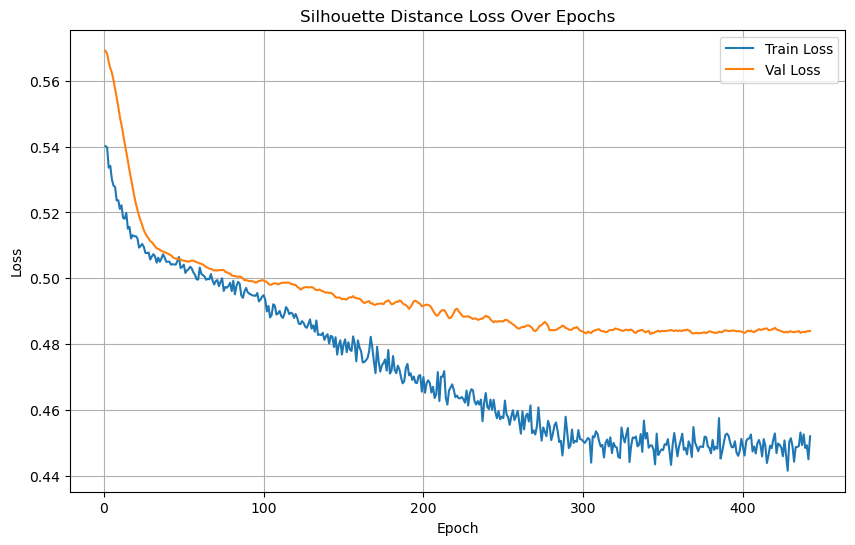

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/73], Loss: 0.3377
Test Batch [20/73], Loss: 0.1870
Test Batch [30/73], Loss: 0.3324
Test Batch [40/73], Loss: 0.5000
Test Batch [50/73], Loss: 0.4335
Test Batch [60/73], Loss: 0.4314
Test Batch [70/73], Loss: 0.2825



Test Loss: 0.3321


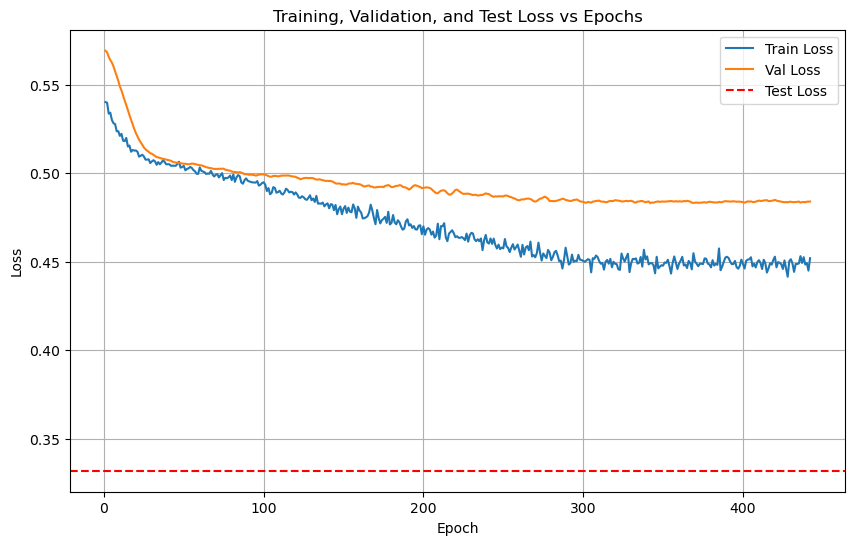

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/73 for test dataset.


  Processed batch 20/73 for test dataset.


  Processed batch 30/73 for test dataset.
  Processed batch 40/73 for test dataset.
  Processed batch 50/73 for test dataset.


  Processed batch 60/73 for test dataset.


  Processed batch 70/73 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (520, 128)
Train labels shape: (520,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4626, 128)
Test labels shape: (4626,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 43.08%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.60      0.50         5
           1       0.00      0.00      0.00         5
           2       0.25      0.20      0.22         5
           3       0.00      0.00      0.00         5
           4       0.67      0.80      0.73         5
           5       0.33      0.20      0.25         5
           6       0.50      0.60      0.55         5
           7       0.17      0.20      0.18         5
           8       0.50      0.80      0.62         5
           9       0.11      0.20      0.14         5
          10       1.00      0.80      0.89         5
          11       0.67      0.40      0.50         5
          12       0.67      0.80      0.73         5

    accuracy         

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (520, 128)
Train labels shape: (520,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4626, 128)
Test labels shape: (4626,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5702  |  Val Loss: 2.5971
Validation loss improved from inf to 2.5971.
[Epoch 2/1000] Train Loss: 2.5417  |  Val Loss: 2.5882
Validation loss improved from 2.5971 to 2.5882.
[Epoch 3/1000] Train Loss: 2.5210  |  Val Loss: 2.5795
Validation loss improved from 2.5882 to 2.5795.
[Epoch 4/1000] Train Loss: 2.5000  |  Val Loss: 2.5718
Validation loss improved from 2.5795 to 2.5718.
[Epoch 5/1000] Train Loss: 2.4847  |  Val Loss: 2.5653
Validation loss improved from 2.5718 to 2.5653.


[Epoch 6/1000] Train Loss: 2.4686  |  Val Loss: 2.5588
Validation loss improved from 2.5653 to 2.5588.
[Epoch 7/1000] Train Loss: 2.4534  |  Val Loss: 2.5518
Validation loss improved from 2.5588 to 2.5518.
[Epoch 8/1000] Train Loss: 2.4399  |  Val Loss: 2.5450
Validation loss improved from 2.5518 to 2.5450.
[Epoch 9/1000] Train Loss: 2.4274  |  Val Loss: 2.5391
Validation loss improved from 2.5450 to 2.5391.


[Epoch 10/1000] Train Loss: 2.4151  |  Val Loss: 2.5341
Validation loss improved from 2.5391 to 2.5341.


[Epoch 11/1000] Train Loss: 2.4033  |  Val Loss: 2.5293
Validation loss improved from 2.5341 to 2.5293.
[Epoch 12/1000] Train Loss: 2.3918  |  Val Loss: 2.5250
Validation loss improved from 2.5293 to 2.5250.
[Epoch 13/1000] Train Loss: 2.3801  |  Val Loss: 2.5208
Validation loss improved from 2.5250 to 2.5208.
[Epoch 14/1000] Train Loss: 2.3687  |  Val Loss: 2.5164
Validation loss improved from 2.5208 to 2.5164.
[Epoch 15/1000] Train Loss: 2.3570  |  Val Loss: 2.5123
Validation loss improved from 2.5164 to 2.5123.
[Epoch 16/1000] Train Loss: 2.3461  |  Val Loss: 2.5093
Validation loss improved from 2.5123 to 2.5093.
[Epoch 17/1000] Train Loss: 2.3355  |  Val Loss: 2.5064
Validation loss improved from 2.5093 to 2.5064.


[Epoch 18/1000] Train Loss: 2.3260  |  Val Loss: 2.5030
Validation loss improved from 2.5064 to 2.5030.
[Epoch 19/1000] Train Loss: 2.3170  |  Val Loss: 2.5004
Validation loss improved from 2.5030 to 2.5004.
[Epoch 20/1000] Train Loss: 2.3073  |  Val Loss: 2.4980
Validation loss improved from 2.5004 to 2.4980.
[Epoch 21/1000] Train Loss: 2.2984  |  Val Loss: 2.4954
Validation loss improved from 2.4980 to 2.4954.


[Epoch 22/1000] Train Loss: 2.2893  |  Val Loss: 2.4928
Validation loss improved from 2.4954 to 2.4928.
[Epoch 23/1000] Train Loss: 2.2805  |  Val Loss: 2.4904
Validation loss improved from 2.4928 to 2.4904.
[Epoch 24/1000] Train Loss: 2.2714  |  Val Loss: 2.4868
Validation loss improved from 2.4904 to 2.4868.
[Epoch 25/1000] Train Loss: 2.2624  |  Val Loss: 2.4834
Validation loss improved from 2.4868 to 2.4834.
[Epoch 26/1000] Train Loss: 2.2538  |  Val Loss: 2.4817
Validation loss improved from 2.4834 to 2.4817.
[Epoch 27/1000] Train Loss: 2.2451  |  Val Loss: 2.4803
Validation loss improved from 2.4817 to 2.4803.
[Epoch 28/1000] Train Loss: 2.2362  |  Val Loss: 2.4774
Validation loss improved from 2.4803 to 2.4774.


[Epoch 29/1000] Train Loss: 2.2274  |  Val Loss: 2.4760
Validation loss improved from 2.4774 to 2.4760.
[Epoch 30/1000] Train Loss: 2.2185  |  Val Loss: 2.4751
Validation loss improved from 2.4760 to 2.4751.
[Epoch 31/1000] Train Loss: 2.2101  |  Val Loss: 2.4745
Validation loss improved from 2.4751 to 2.4745.


[Epoch 32/1000] Train Loss: 2.2015  |  Val Loss: 2.4731
Validation loss improved from 2.4745 to 2.4731.
[Epoch 33/1000] Train Loss: 2.1925  |  Val Loss: 2.4718
Validation loss improved from 2.4731 to 2.4718.
[Epoch 34/1000] Train Loss: 2.1843  |  Val Loss: 2.4727
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 35/1000] Train Loss: 2.1760  |  Val Loss: 2.4718
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 36/1000] Train Loss: 2.1671  |  Val Loss: 2.4728
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 37/1000] Train Loss: 2.1585  |  Val Loss: 2.4708
Validation loss improved from 2.4718 to 2.4708.
[Epoch 38/1000] Train Loss: 2.1498  |  Val Loss: 2.4699
Validation loss improved from 2.4708 to 2.4699.
[Epoch 39/1000] Train Loss: 2.1412  |  Val Loss: 2.4694
Validation loss improved from 2.4699 to 2.4694.
[Epoch 40/1000] Train Loss: 2.1325  |  Val Loss: 2.4693
Validation loss improved from 2.4694 to 2.4693.


[Epoch 41/1000] Train Loss: 2.1236  |  Val Loss: 2.4671
Validation loss improved from 2.4693 to 2.4671.
[Epoch 42/1000] Train Loss: 2.1145  |  Val Loss: 2.4625
Validation loss improved from 2.4671 to 2.4625.


[Epoch 43/1000] Train Loss: 2.1054  |  Val Loss: 2.4613
Validation loss improved from 2.4625 to 2.4613.
[Epoch 44/1000] Train Loss: 2.0966  |  Val Loss: 2.4597
Validation loss improved from 2.4613 to 2.4597.
[Epoch 45/1000] Train Loss: 2.0876  |  Val Loss: 2.4553
Validation loss improved from 2.4597 to 2.4553.
[Epoch 46/1000] Train Loss: 2.0788  |  Val Loss: 2.4471
Validation loss improved from 2.4553 to 2.4471.
[Epoch 47/1000] Train Loss: 2.0703  |  Val Loss: 2.4470
Validation loss improved from 2.4471 to 2.4470.
[Epoch 48/1000] Train Loss: 2.0613  |  Val Loss: 2.4439
Validation loss improved from 2.4470 to 2.4439.
[Epoch 49/1000] Train Loss: 2.0516  |  Val Loss: 2.4488
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 50/1000] Train Loss: 2.0429  |  Val Loss: 2.4506
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 51/1000] Train Loss: 2.0333  |  Val Loss: 2.4465
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 52/1000] Train Loss: 2.0242  |  Val Los

[Epoch 53/1000] Train Loss: 2.0145  |  Val Loss: 2.4481
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 54/1000] Train Loss: 2.0050  |  Val Loss: 2.4469
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 55/1000] Train Loss: 1.9956  |  Val Loss: 2.4441
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 56/1000] Train Loss: 1.9861  |  Val Loss: 2.4447
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 57/1000] Train Loss: 1.9762  |  Val Loss: 2.4432
Validation loss improved from 2.4439 to 2.4432.
[Epoch 58/1000] Train Loss: 1.9666  |  Val Loss: 2.4355
Validation loss improved from 2.4432 to 2.4355.
[Epoch 59/1000] Train Loss: 1.9567  |  Val Loss: 2.4328
Validation loss improved from 2.4355 to 2.4328.
[Epoch 60/1000] Train Loss: 1.9469  |  Val Loss: 2.4310
Validation loss improved from 2.4328 to 2.4310.
[Epoch 61/1000] Train Loss: 1.9368  |  Val Loss: 2.4244
Validation loss improved from 2.4310 to 2.4244.
[Epoch 62/1000] Train Loss: 1.9263  |  Val Loss: 2.4296
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 63/1000] Train Loss: 1.9157  |  V

[Epoch 65/1000] Train Loss: 1.8931  |  Val Loss: 2.4194
Validation loss improved from 2.4236 to 2.4194.


[Epoch 66/1000] Train Loss: 1.8817  |  Val Loss: 2.4154
Validation loss improved from 2.4194 to 2.4154.
[Epoch 67/1000] Train Loss: 1.8703  |  Val Loss: 2.4090
Validation loss improved from 2.4154 to 2.4090.
[Epoch 68/1000] Train Loss: 1.8586  |  Val Loss: 2.4093
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 69/1000] Train Loss: 1.8472  |  Val Loss: 2.4088
Validation loss improved from 2.4090 to 2.4088.
[Epoch 70/1000] Train Loss: 1.8351  |  Val Loss: 2.4046
Validation loss improved from 2.4088 to 2.4046.
[Epoch 71/1000] Train Loss: 1.8233  |  Val Loss: 2.3978
Validation loss improved from 2.4046 to 2.3978.
[Epoch 72/1000] Train Loss: 1.8116  |  Val Loss: 2.3982
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 73/1000] Train Loss: 1.7997  |  Val Loss: 2.3969
Validation loss improved from 2.3978 to 2.3969.
[Epoch 74/1000] Train Loss: 1.7879  |  Val Loss: 2.3931
Validation loss improved from 2.3969 to 2.3931.
[Epoch 75/1000] Train Loss: 1.7760  |  Val Loss: 2.3

[Epoch 77/1000] Train Loss: 1.7527  |  Val Loss: 2.3920
Validation loss improved from 2.3931 to 2.3920.
[Epoch 78/1000] Train Loss: 1.7405  |  Val Loss: 2.3906
Validation loss improved from 2.3920 to 2.3906.
[Epoch 79/1000] Train Loss: 1.7288  |  Val Loss: 2.3870
Validation loss improved from 2.3906 to 2.3870.
[Epoch 80/1000] Train Loss: 1.7167  |  Val Loss: 2.3862
Validation loss improved from 2.3870 to 2.3862.
[Epoch 81/1000] Train Loss: 1.7046  |  Val Loss: 2.3892
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 82/1000] Train Loss: 1.6931  |  Val Loss: 2.3959
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 83/1000] Train Loss: 1.6816  |  Val Loss: 2.3896
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 84/1000] Train Loss: 1.6695  |  Val Loss: 2.3843
Validation loss improved from 2.3862 to 2.3843.
[Epoch 85/1000] Train Loss: 1.6580  |  Val Loss: 2.3851
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 86/1000] Train Loss: 1.6467  |  V

[Epoch 88/1000] Train Loss: 1.6241  |  Val Loss: 2.3929
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 89/1000] Train Loss: 1.6125  |  Val Loss: 2.3940
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 90/1000] Train Loss: 1.6011  |  Val Loss: 2.3905
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 91/1000] Train Loss: 1.5896  |  Val Loss: 2.3877
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 92/1000] Train Loss: 1.5790  |  Val Loss: 2.3849
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 93/1000] Train Loss: 1.5673  |  Val Loss: 2.3878
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 94/1000] Train Loss: 1.5559  |  Val Loss: 2.3880
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 95/1000] Train Loss: 1.5446  |  Val Loss: 2.3853
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 96/1000] Train Loss: 1.5342  |  Val Loss: 2.3940
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 

[Epoch 99/1000] Train Loss: 1.5012  |  Val Loss: 2.3955
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 100/1000] Train Loss: 1.4899  |  Val Loss: 2.3963
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 101/1000] Train Loss: 1.4791  |  Val Loss: 2.3963
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 102/1000] Train Loss: 1.4682  |  Val Loss: 2.3963
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 103/1000] Train Loss: 1.4574  |  Val Loss: 2.4032
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 104/1000] Train Loss: 1.4473  |  Val Loss: 2.4115
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 105/1000] Train Loss: 1.4364  |  Val Loss: 2.4099
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 106/1000] Train Loss: 1.4255  |  Val Loss: 2.4047
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 107/1000] Train Loss: 1.4150  |  Val Loss: 2.4058
!! Validation loss did NOT improve !! Patience: 

[Epoch 110/1000] Train Loss: 1.3838  |  Val Loss: 2.4137
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 111/1000] Train Loss: 1.3737  |  Val Loss: 2.4174
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 112/1000] Train Loss: 1.3630  |  Val Loss: 2.4193
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 113/1000] Train Loss: 1.3531  |  Val Loss: 2.4196
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 114/1000] Train Loss: 1.3428  |  Val Loss: 2.4260
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 115/1000] Train Loss: 1.3330  |  Val Loss: 2.4210
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 116/1000] Train Loss: 1.3230  |  Val Loss: 2.4235
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 117/1000] Train Loss: 1.3137  |  Val Loss: 2.4331
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 118/1000] Train Loss: 1.3040  |  Val Loss: 2.4377
!! Validation loss did NOT improve !! Patience:

[Epoch 123/1000] Train Loss: 1.2582  |  Val Loss: 2.4480
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 124/1000] Train Loss: 1.2488  |  Val Loss: 2.4515
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 125/1000] Train Loss: 1.2397  |  Val Loss: 2.4580
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 126/1000] Train Loss: 1.2314  |  Val Loss: 2.4711
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 127/1000] Train Loss: 1.2227  |  Val Loss: 2.4844
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 128/1000] Train Loss: 1.2143  |  Val Loss: 2.4892
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 129/1000] Train Loss: 1.2070  |  Val Loss: 2.5041
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 130/1000] Train Loss: 1.1991  |  Val Loss: 2.4978
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 131/1000] Train Loss: 1.1906  |  Val Loss: 2.4913
!! Validation loss did NOT improve !! Patience:

[Epoch 135/1000] Train Loss: 1.1607  |  Val Loss: 2.5270
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 136/1000] Train Loss: 1.1530  |  Val Loss: 2.5099
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 137/1000] Train Loss: 1.1463  |  Val Loss: 2.4934
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 138/1000] Train Loss: 1.1397  |  Val Loss: 2.4904
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 139/1000] Train Loss: 1.1329  |  Val Loss: 2.4928
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 140/1000] Train Loss: 1.1249  |  Val Loss: 2.5108
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 141/1000] Train Loss: 1.1175  |  Val Loss: 2.5281
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 142/1000] Train Loss: 1.1104  |  Val Loss: 2.5392
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 143/1000] Train Loss: 1.1035  |  Val Loss: 2.5431
!! Validation loss did NOT improve !! Patience:

[Epoch 146/1000] Train Loss: 1.0837  |  Val Loss: 2.5610
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 147/1000] Train Loss: 1.0779  |  Val Loss: 2.5657
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 148/1000] Train Loss: 1.0718  |  Val Loss: 2.5704
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 149/1000] Train Loss: 1.0660  |  Val Loss: 2.5793
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 150/1000] Train Loss: 1.0611  |  Val Loss: 2.5846
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 151/1000] Train Loss: 1.0554  |  Val Loss: 2.5880
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 152/1000] Train Loss: 1.0491  |  Val Loss: 2.5925
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 153/1000] Train Loss: 1.0441  |  Val Loss: 2.5920
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 154/1000] Train Loss: 1.0382  |  Val Loss: 2.6054
!! Validation loss did NOT improve !! Patience:

[Epoch 156/1000] Train Loss: 1.0274  |  Val Loss: 2.6097
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 157/1000] Train Loss: 1.0227  |  Val Loss: 2.6130
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 158/1000] Train Loss: 1.0173  |  Val Loss: 2.6267
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 159/1000] Train Loss: 1.0118  |  Val Loss: 2.6387
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 160/1000] Train Loss: 1.0068  |  Val Loss: 2.6503
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 161/1000] Train Loss: 1.0024  |  Val Loss: 2.6558
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 162/1000] Train Loss: 0.9976  |  Val Loss: 2.6523
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 163/1000] Train Loss: 0.9932  |  Val Loss: 2.6499
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 164/1000] Train Loss: 0.9881  |  Val Loss: 2.6697
!! Validation loss did NOT improve !! Patience:

[Epoch 168/1000] Train Loss: 0.9701  |  Val Loss: 2.6880
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 169/1000] Train Loss: 0.9657  |  Val Loss: 2.6903
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 170/1000] Train Loss: 0.9616  |  Val Loss: 2.7073
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 171/1000] Train Loss: 0.9576  |  Val Loss: 2.7053
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 172/1000] Train Loss: 0.9542  |  Val Loss: 2.7085
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 173/1000] Train Loss: 0.9503  |  Val Loss: 2.7063
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 174/1000] Train Loss: 0.9460  |  Val Loss: 2.7147
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 175/1000] Train Loss: 0.9419  |  Val Loss: 2.7231
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 176/1000] Train Loss: 0.9382  |  Val Loss: 2.7316
!! Validation loss did NOT improve !! Patience:

[Epoch 179/1000] Train Loss: 0.9275  |  Val Loss: 2.7703
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 180/1000] Train Loss: 0.9239  |  Val Loss: 2.7625
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 181/1000] Train Loss: 0.9202  |  Val Loss: 2.7534
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 182/1000] Train Loss: 0.9170  |  Val Loss: 2.7573
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 183/1000] Train Loss: 0.9133  |  Val Loss: 2.7682
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 184/1000] Train Loss: 0.9114  |  Val Loss: 2.7720
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 184 !!
No improvement for 100 epochs.


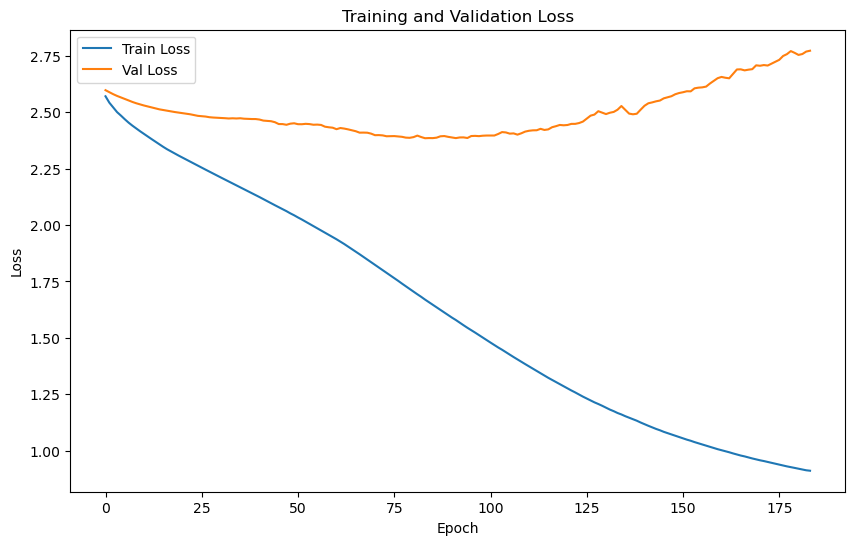

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 2.6748 | Test Accuracy: 61.74%


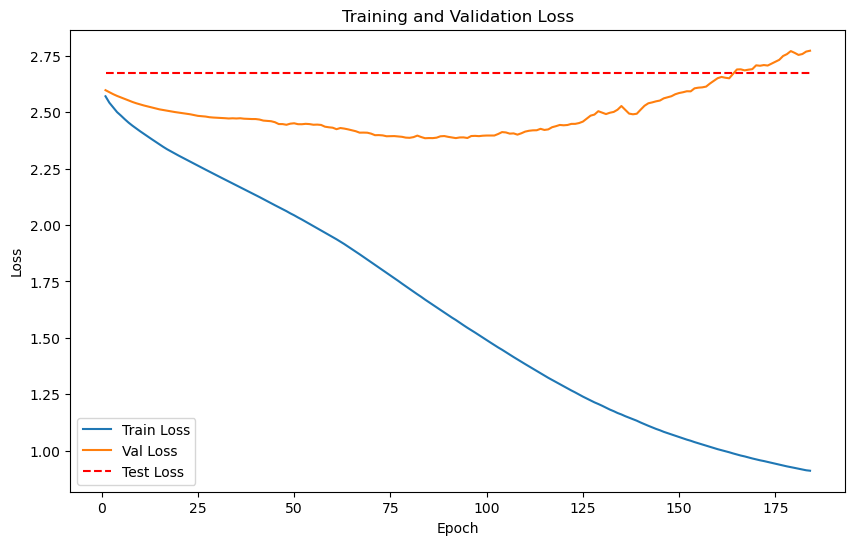

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


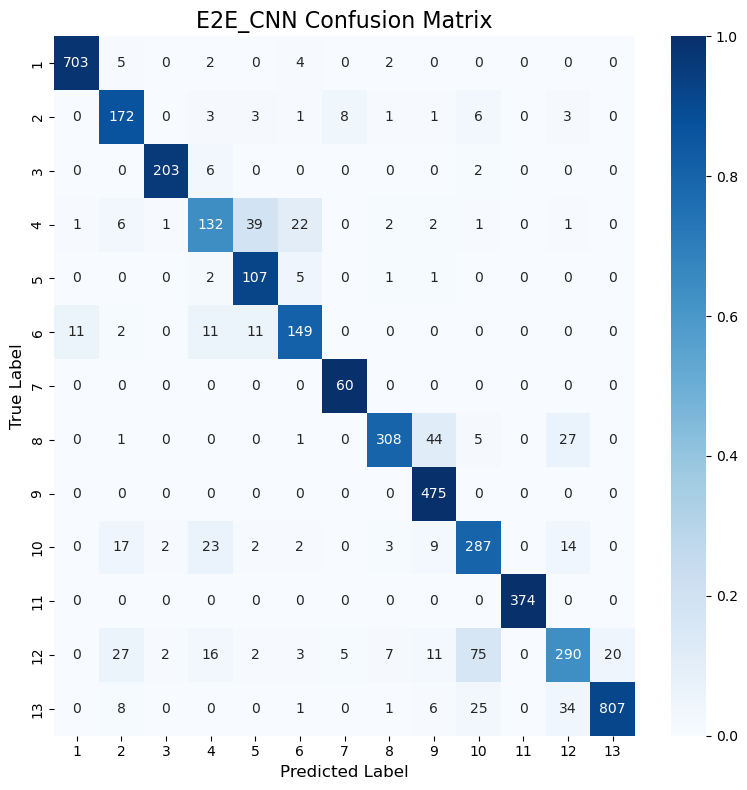

Classification Accuracy: 87.92%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


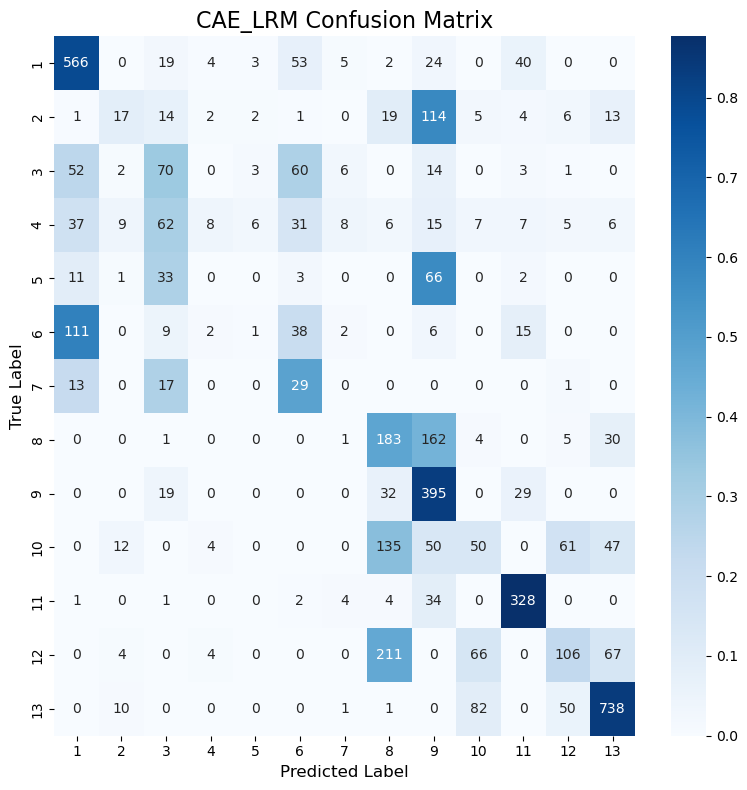

Classification Accuracy: 54.02%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


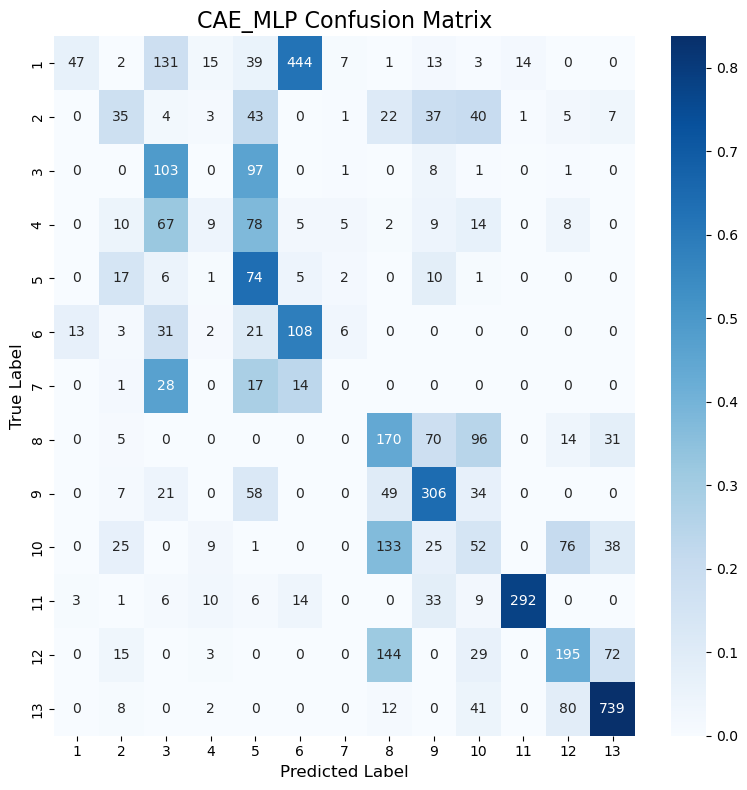

Classification Accuracy: 46.04%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


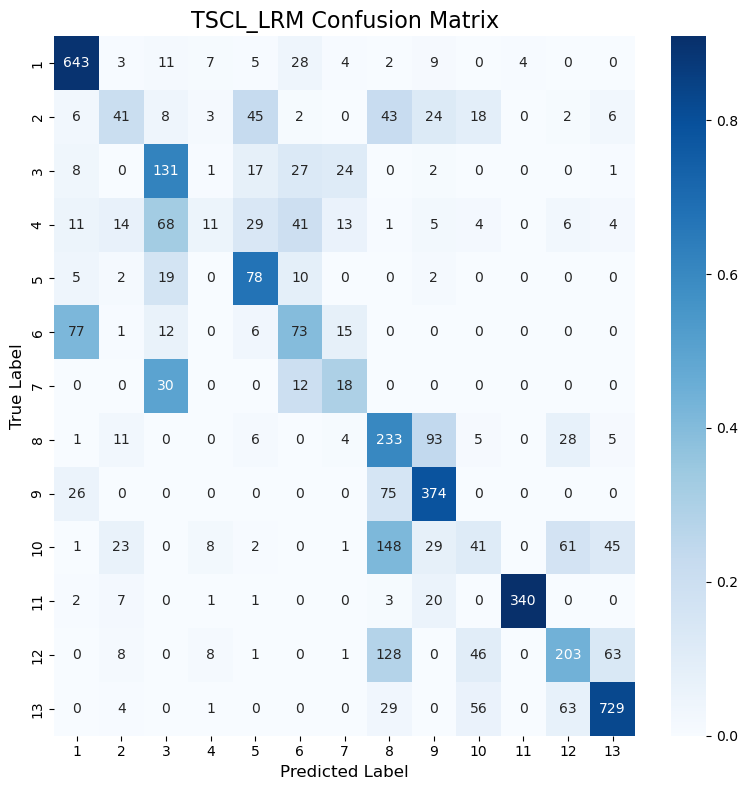

Classification Accuracy: 63.01%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


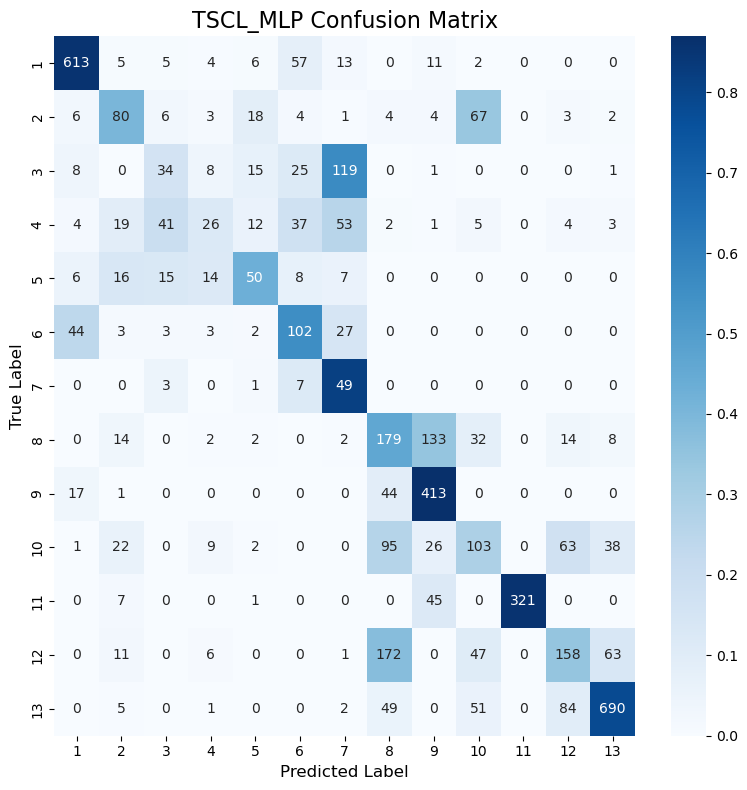

Classification Accuracy: 60.92%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


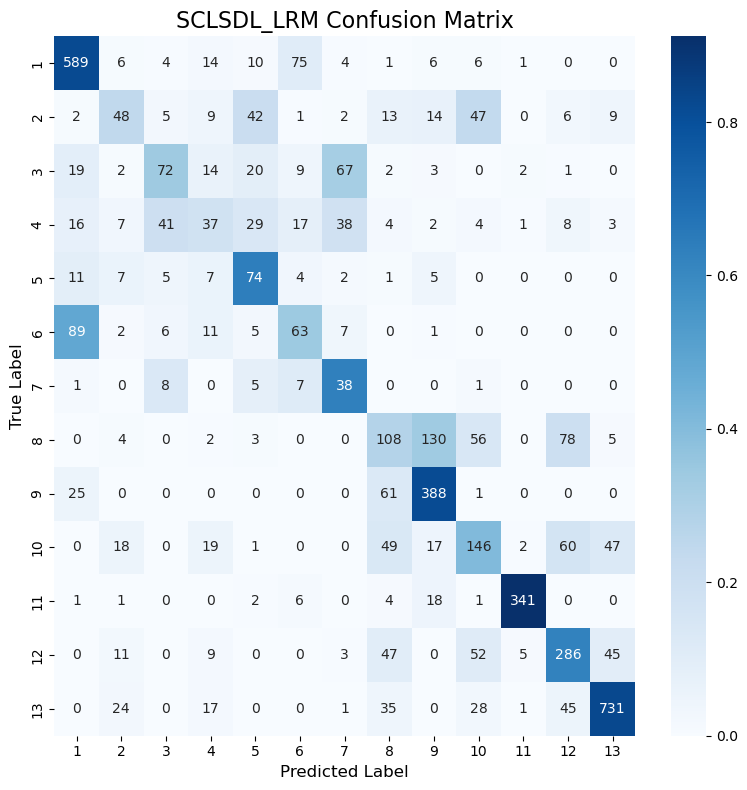

Classification Accuracy: 63.14%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


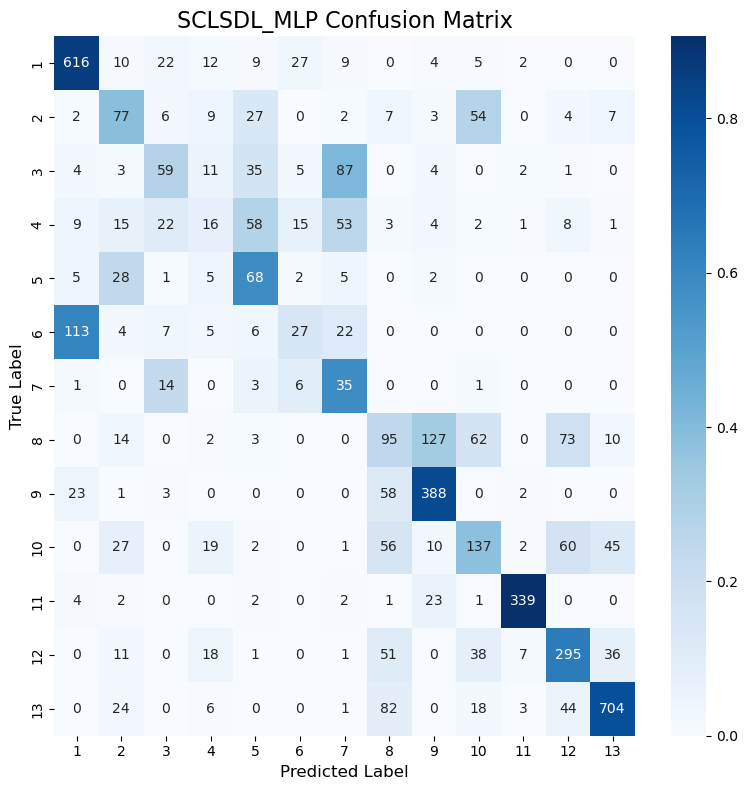

Classification Accuracy: 61.74%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          87.92
1    LRM (CAE)          54.02
2    MLP (CAE)          46.04
3     TSCL LRM          63.01
4     TSCL MLP          60.92
5  SCL_SDL LRM          63.14
6  SCL_SDL MLP          61.74

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          87.92
5  SCL_SDL LRM          63.14
3     TSCL LRM          63.01
6  SCL_SDL MLP          61.74
4     TSCL MLP          60.92
1    LRM (CAE)          54.02
2    MLP (CAE)          46.04
